# Cluster Modeling

In [285]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
from datetime import datetime
import datetime as dt  # Used to manage dates
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
from dateutil.parser import parse 
import pymysql # Import MySql 
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
import requests

from scipy import signal
from scipy.special import inv_boxcox
from scipy import stats as stats # Used for calculating z-values

import numpy as np # Used for calculating statistics on data
import random
import math
from math import sqrt, log, exp
import itertools

import pandas as pd # Used for loading-in and viewing data


import matplotlib.pyplot as plt # Used for creating graphics
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.pylab import rcParams 
from pylab import *
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl

import statsmodels.api as sm

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

import plotly.offline as py
from plotly import graph_objs as go
from plotly import figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots




%matplotlib inline
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# to make this notebook's output identical at every run
np.random.seed(42)

In [286]:
# Re initiate all features and data
def re_group(df_household):
    
    # Regroup Group Income
    group1 = ['UNDER 10K','10-19,999' , '20-29,999', '30-39,999']
    group2 = ['40-49,999', '50-59,999', '60-69,999', '70-79,999', '80-89,999', '90-99,999']
    group3 = ['100-149,999', '150 - 174,999', '175 - 199,999', '200 - 249,999', '250K+' ]
    for i in group1:
        df_household['income']=np.where(df_household['income']== i, 'UNDER 39,999', df_household['income'])
    for i in group2:
        df_household['income']=np.where(df_household['income']== i, '40 - 99,999', df_household['income'])
    for i in group3:
        df_household['income']=np.where(df_household['income']== i, '100k+', df_household['income'])
    
    # Regroup tenures
    group1 = ['BETWEEN 6 & 10 YEARS', 'BETWEEN 11 & 15 YEARS', 
          'BETWEEN 16 & 20 YEARS', 'BETWEEN 1 & 5 YEARS', '< 1 YEAR']
    group2 = ['BETWEEN 31 & 40 YEARS', 'BETWEEN 21 & 30 YEARS']
    group3 = ['+40 YEARS']
    for i in group1:
        df_household['tenure']=np.where(df_household['tenure']== i, 'UNDER 20 YEARS', df_household['tenure'])
    for i in group2:
        df_household['tenure']=np.where(df_household['tenure']== i, 'BETWEEN 21 & 40 YEARS', df_household['tenure'])
    for i in group3:
        df_household['tenure']=np.where(df_household['tenure']== i, '+40 YEARS', df_household['tenure'])
    
    # Regroup credit ranges
    group1 = ['499 & LESS', '500-549','550-599','600-649', '650-699']
    group2 = ['700-749', '750-799']
    group3 = ['800+']
    for i in group1:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BELOW 700', df_household['credit_ranges'])
    for i in group2:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BETWEEN 700 & 799', df_household['credit_ranges'])
    for i in group3:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, '800+', df_household['credit_ranges'])
    
    # Regroup Education
    df_household['education']=np.where(df_household['education'] =='GRADUATED SCHOOL', 
                                   'COMPLETED COLLEGE', df_household['education']
                                  )
    # Regroup Race
    group1 = ['CAUCASION / WHITE - EUROPEAN', 'CAUCASION / WHITE - ENGLISH', 'CAUCASION / WHITE - WHITE NON-AMERICAN',
          'CAUCASION / WHITE - UNKNOWN', 'CAUCASION / WHITE - EASTERN EUROPEAN', 'CAUCASION / WHITE - JEWISH',
          'CAUCASION / WHITE - GREEK', 'CAUCASION / WHITE - DUTCH'
         ]
    group2 = ['HISPANIC - HISPANIC ORIGIN', 'HISPANIC - PORTUGUESE ORIGIN']
    group3 = ['ASIAN - CHINESE', 'ASIAN - UNKNOWN', 'ASIAN - JAPANESE', 'ASIAN - INDIAN', 'ASIAN - ORIENTAL']
    group4 = ['MIDDLE EASTERN - ARAB', 'MIDDLE EASTERN - EGYPTIAN']
    group5 = ['AFRICAN AMERICAN - AFRICAN ORIGIN', 'AMERICAN INDIAN']

    for i in group1:
        df_household['race']=np.where(df_household['race']== i, 'CAUCASION / WHITE', df_household['race'])
    for i in group2:
        df_household['race']=np.where(df_household['race']== i, 'HISPANIC', df_household['race'])
    for i in group3:
        df_household['race']=np.where(df_household['race']== i, 'ASIAN', df_household['race'])
    for i in group4:
        df_household['race']=np.where(df_household['race']== i, 'ARABS', df_household['race'])
    for i in group5:
        df_household['race']=np.where(df_household['race']== i, 'AMERICAN AFRICANS / INDIANS', df_household['race'])

    # Regroup Home Owner
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE RENTER', 'RENTER', df_household['home_owner'])
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE HOME OWNER', 'HOME OWNER', df_household['home_owner'])
    
    # Regroup Cancel reason
    group1 = ['NON-PAYMENT', 'ERS DECLINE CC', 'BAD ADD SET BY PO ACS', '*BAD CHECKS*', 
         ]
    group2 = ['DECEASED', 'NO LONGER DRIVING', 'MEMBERS REQUEST', 'CANCELLED DO NOT RENEW', 'TRANSFER MEMBER',
              'DO NOT RENEW', 'MOVED OUT OF TERR', 'TRANSFER MEMBER SUSPEND', 'CANCELLED MBRS REQUEST',
              'HEALTH ISSUE', 'NONCOMPLIANT AGE', 'PO RETURN'
             ]
    group3 = ['DATA PROBLEM','DUP MEMBERSHIP','ERS CNCL MSHIP PROGRAM','MANAGEMENT REQUEST', 'CANCEL PROCESS - FUTURE CANCEL DNR']

    for i in group1:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'PAYMENT ISSUES', df_household['cancel_reason'])
    for i in group2:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'MEMBER ISSUES', df_household['cancel_reason'])
    for i in group3:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'DATA/AAA ISSUES', df_household['cancel_reason'])

    # Regroup Mosaic Global household
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'METROPOLITAN STRUGGLERS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'SOPHISTICATED SINGLES', 
                                                     'BOURGEOIS PROSPERITY', df_household['mosaic_global_household']
                                                    )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'RURAL INHERITANCE', 
                                                     'CAREER AND FAMILY', df_household['mosaic_global_household']
                                                    )
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'POST INDUSTRIAL SURVIVORS', 
                                                     'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                    )
    # Regroup Experian Group
    group1 = ['AUTUMN YEARS', 'GOLDEN YEAR GUARDIANS']
    group2 = ['BOOMING WITH CONFIDENCE', 'THRIVING BOOMERS', 'BLUE SKY BOOMERS']
    group3 = ['POWER ELITE', 'SURBURBAN STYLE', 'FLOURISHING FAMILIES']
    group4 = ['FAMILY UNION', 'MIDDLE CLASS MELTING POT', 'PROMISING FAMILIES', 'ECONOMIC CHALLENGES', 'FAMILIES IN MOTION',
              'PASTORAL PRIDE']
    group5 = ['SINGLES AND STARTERS', 'SIGNIFICANT SINGLES', 'YOUNG CITY SOLOS', 'CULTURAL CONNECTIONS',
             'ASPIRATIONAL FUSION']
    for i in group1:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'GOLDEN YEAR', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group2:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'BOOMERS', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group3:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'POWER ELITE', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group4:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'MIDDLE CLASS MELTING POT', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group5:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'SINGLES AND STARTERS', df_household['kcl_b_ind_mosaicsgrouping'])
    
    # Regroup Vehicle Manufaturer
    group1 = [ 'TOYOTA', 'FORD', 'HONDA', 'CHEVROLET', 'HYUNDAI', 'NISSAN', 'BUICK', 'SUBARU', 'SUZUKI',
         'DODGE', 'CHRYSLER', 'VOLKSWAGEN','KIA', 'MAZDA', 'SATURN', 'PONTIAC', 'SCION', 'MITSUBISHI',
          'GEO', 'CRYSLER', 'MG', 'FIAT', 'BICYCLE', 'ISUZU']
    group2 = ['JEEP', 'MERCURY','GMC', 'OLSMOBILE', 'RAM', 'PLYMOUTH', 'GENESIS', 'OLDSMOBILE', 'AMERICAN AUSTIN']
          
    group3 = ['LEXUS', 'VOLVO', 'MERCEDES-BENZ', 'CADILLAC','LINCOLN', 'ACURA', 'BMW', 'SAAB', 'AUDI', 'INFINITI',
          'LAND ROVER', 'MINI', 'JAGUAR', 'PORSCHE', 'HARLEY DAVIDSON', 'ALFA ROMEO']


    for i in group1:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'STANDARD END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group2:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'MIDDLE END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group3:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'LUXURY VEHICLE', df_household['sc_vehicle_manufacturer_name'])

    # Regroup Occupation Group
    group1 = ['PROFESSIONAL - KNOWN', 'PROFESSIONAL - INFERRED', 'OFFICE ADMINISTRATION - KNOWN',
         'SALES - KNOWN', 'OFFICE ADMINISTRATION - INFERRED', 'TECHNICAL - INFERRED',
         'SALES - INFERRED', 'TECHNICAL - KNOWN']
    group2 = ['MANAGEMENT - KNOWN', 'BLUE COLLAR - KNOWN', 'MANAGEMENT - INFERRED', 'BLUE COLLAR - INFERRED']
    group3 = ['RETIRED - INFERRED', 'RETIRED - KNOWN']
    group4 = ['OTHER - INFERRED', 'OTHER - KNOWN']

    for i in group1:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'PROFESSIONAL', df_household['occupation_group'])
    for i in group2:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'MANAGEMENT', df_household['occupation_group'])
    for i in group3:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'RETIRED', df_household['occupation_group'])
    for i in group4:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'OTHER', df_household['occupation_group'])

    # Regroup Total members inside a household
    df_household['no_members'] = ' '
    df_household['no_members']=np.where(df_household['total_members_in_household']== 1, '1 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 2, '2 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 3, '3 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 4, '4 - MEMBER', 
                                        df_household['no_members'])

    df_household['no_members']=np.where(df_household['total_members_in_household']> 4, '5 - MEMBER', 
                                        df_household['no_members'])
    group5 = np.arange(5,20,1)
    for i in group5:
        df_household['no_members']=np.where(df_household['total_members_in_household']== i, '+5 - MEMBER', 
                                        df_household['no_members'])
    
    # Create roadside usage
    df_household['use_road_side'] = df_household['total_calls'].apply(lambda x:road_side_usage(x))
    
    df_household.consumer_score = np.where(df_household.consumer_score!= np.nan, 1/df_household.consumer_score, 
                                        df_household.consumer_score)
    
    df_household.consumer_score = np.where(~(df_household.consumer_score > 0), df_household.consumer_score.mean(), 
                                           df_household.consumer_score)
    
    #df_household.consumer_score = np.where(df_household.consumer_score== np.nan, df_household.consumer_score.mean(), 
    #                                    df_household.consumer_score)
    
    # create feature Cancel = 1 - member cancelled, if 0 active member
    df_household['aaa_cancel'] = 1
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'ACTIVE', 0, 
                                        df_household['aaa_cancel'])
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'PENDING', 0, 
                                        df_household['aaa_cancel'])
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'CANCELLED', 1, 
                                        df_household['aaa_cancel'])
    
    return df_household

# Functions Definitions

In [287]:
def read_data(file_name, index):
    df = pd.read_csv(file_name, sep=',', index_col=index, header='infer', float_precision=2 )
    return df

def save_data(df, file_name):
    # Write data to CSV File
    df.to_csv(path_or_buf=file_name, sep=',',index=False, encoding='utf-8')
    return

def update_df(df_household, df, column):
    df_household[column] = df[column]
    return df_household

def road_side_usage(calls):
    if calls > 0: return 1
    elif calls == 0: return 0
    else: return np.nan

def fill_with_zeros(df_household, fields):
    for i in fields:
        df_household[i].fillna(value=0, inplace=True)
    return df_household

def join_data_from_models(df_household, fields):
    # Create feature Cancel = 1 - member cancelled, if 0 active member
    df_household['aaa_cancel'] = 1
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'ACTIVE', 0, 
                                        df_household['aaa_cancel'])
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'PENDING', 0, 
                                        df_household['aaa_cancel'])
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'CANCELLED', 1, 
                                        df_household['aaa_cancel'])
    # Create roadside usage
    df_household['use_road_side'] = df_household['total_calls'].apply(lambda x:road_side_usage(x))

    df_household.consumer_score = np.where(df_household.consumer_score!= np.nan, 1/df_household.consumer_score, 
                                           df_household.consumer_score)

    df_household.consumer_score = np.where(~(df_household.consumer_score > 0), df_household.consumer_score.mean(), 
                                           df_household.consumer_score)

    df_household.consumer_score = np.where(df_household.consumer_score== np.nan, df_household.consumer_score.mean(), 
                                           df_household.consumer_score)

    # Join results to main dataframe
    df_household = update_df(df_household, df_auto_insurance, 'yes_auto_insurance')
    df_household = update_df(df_household, df_cancel, 'will_cancel_prob')
    df_household = update_df(df_household, df_credit_card, 'yes_credit_card')
    df_household = update_df(df_household, df_deposit,'yes_deposit')
    df_household = update_df(df_household, df_home_equity, 'yes_home_equity')
    df_household = update_df(df_household, df_id_theft, 'yes_id_theft')
    df_household = update_df(df_household, df_mortgage, 'yes_mortgage')
    df_household = update_df(df_household, df_roadside, 'yes_roadside')
    df_household = update_df(df_household, df_travel, 'yes_travel')
    df_household = update_df(df_household, df_costs, 'estimated_cost')
    df_household['aaa_mean_age'] = np.round(df_household['aaa_mean_age'],0)
    df_household['aaa_mean_child'] = np.round(df_household['aaa_mean_child'],0)
    df_household = fill_with_zeros(df_household,fields)
    # Remove members with status CANCELLED
    df_household = df_household[df_household.member_status!='CANCELLED']
    return df_household

# Load Data outcomes from models

In [288]:
# Load House hold Data 
df_household = read_data('household_view.csv', 'membership_id')
# Load outcome of auto insurance model
df_auto_insurance = read_data('auto_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of customer cancel model
df_cancel = read_data('cancel_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of credit card model
df_credit_card = read_data('credit_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of deposit model
df_deposit = read_data('deposit_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of home equity model
df_home_equity = read_data('hequity_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of ID Theft model
df_id_theft = read_data('idtheft_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of Mortgage and Financial Services model
df_mortgage = read_data('mortgage_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of Roadside model
df_roadside = read_data('rds_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of Cost Prediction model
df_costs = read_data('totc_no_gap_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of Cost Prediction model
df_travel = read_data('travel_reduced_feature_outcome.csv', 'membership_id')

# Join results to main dataframe

In [289]:
fields = ['yes_auto_insurance','will_cancel_prob', 'yes_credit_card', 'yes_deposit',
          'yes_home_equity', 'yes_id_theft', 'yes_mortgage', 'yes_roadside', 'yes_travel',
          'estimated_cost', 'aaa_mean_age', 'aaa_mean_child', 
         ]
df_household = join_data_from_models(df_household, fields)

In [290]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 153 to 543695
Data columns (total 97 columns):
household_key                        2937 non-null int64
income                               2937 non-null object
member_status                        2937 non-null object
state_grouped                        2937 non-null object
credit_ranges                        2937 non-null object
cancel_reason                        2937 non-null object
renew_method                         2937 non-null object
plus_indicator_description           2937 non-null object
zip                                  2937 non-null int64
sc_vehicle_manufacturer_name         2937 non-null object
sc_vehicle_model_name                2937 non-null object
race                                 2937 non-null object
home_owner                           2937 non-null object
education                            2937 non-null object
dwelling_type                        2937 non-null object
gender               

# Cluster KMeans Model

In [291]:
# Verify is there is no nulls
df_household[df_household.isnull().any(axis=1)].head(5)

household_key       income member_status state_grouped credit_ranges cancel_reason renew_method plus_indicator_description   zip sc_vehicle_manufacturer_name sc_vehicle_model_name                          race  home_owner     education                             dwelling_type   gender occupation_code    occupation_group occupant_type    mosaic_household  mosaic_global_household kcl_b_ind_mosaicsgrouping                  generation               tenure  aaa_no_tenure  aaa_member_tenure_years  aaa_mean_age  length_of_residence  aaa_mortgage  aaa_credit_card  aaa_deposit  aaa_home_equity  aaa_financial_service  aaa_auto_insurance  aaa_id_theft  aaa_motorcycle_indicator  aaa_travel  aaa_mean_child  aaa_mean_total_cost  aaa_no_race  aaa_no_home_owner  aaa_no_education  aaa_no_income  aaa_no_dwelling_type  aaa_no_credit_ranges  aaa_no_gender  aaa_no_language  aaa_no_reason_joined  aaa_cancel_reason  aaa_no_mosaic_household  aaa_no_mosaic_global_household  \
membership_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
153                  4500791    30-39,999        ACTIVE            RI       600-649       UNKNOWN   AUTO RENEW           BASIC MEMBERSHIP  2893                       TOYOTA                 CAMRY   CAUCASION / WHITE - ENGLISH  HOME OWNER  SOME COLLEGE  SMALL OR LARGE MULTI-FAMILY W/APT NUMBER  UNKNOWN         UNKNOWN             UNKNOWN       UNKNOWN    SENIOR DISCOUNTS        LOW INCOME ELDERS     GOLDEN YEAR GUARDIANS           POST-WAR (< 1948)            +40 YEARS              0                       49       97.0000              15.0000             0                1            0                0                      0                   0             0                    0.0000           0          2.0000              33.8333       2.0000             0.0000            1.0000         8.0000                2.0000                5.0000            nan           0.0000                   nan                nan                  11.0000                          7.0000   
163                 11622991    50-59,999        ACTIVE            RI       750-799       UNKNOWN   AUTO RENEW           BASIC MEMBERSHIP  2889                       SUBARU                   BRZ    HISPANIC - HISPANIC ORIGIN  HOME OWNER       UNKNOWN                                      SFDU  UNKNOWN         UNKNOWN             UNKNOWN       UNKNOWN  NO PLACE LIKE HOME  ROUTINE SERVICE WORKERS          THRIVING BOOMERS    MILLENIALS (1981 - 1993)  BETWEEN 1 & 5 YEARS              6                       59       48.0000               8.5556             0                0            0                0                      0                   0             0                    1.0000           0          1.0000              39.2056       6.0000             0.0000            2.0000         4.0000                0.0000                1.0000            nan           0.0000                   nan             1.0000                   3.0000                          3.0000   
182                   579810    50-59,999        ACTIVE            RI       650-699    

In [499]:
fields_cluster = ['yes_auto_insurance','will_cancel_prob', 'yes_credit_card', 'yes_deposit',
                  'yes_home_equity', 'yes_id_theft', 'yes_mortgage', 'yes_roadside', 'yes_travel','zip',
                  'estimated_cost', 'total_calls' , 'total_members_in_household', 'aaa_mean_age', 'aaa_mean_child',
                  'aaa_member_tenure_years',  'basic_cost', 'plus_cost', 'premier_cost', 'length_of_residence',
                  'consumer_score', 'mean_tow_miles'
                 ]

In [534]:
# Initialize the model
np.random.seed(42)
fields_cluster = ['yes_auto_insurance','will_cancel_prob', 'yes_credit_card','yes_home_equity',
                  'yes_id_theft', 'yes_mortgage', 'yes_roadside', 'yes_travel', 'yes_deposit',
                  'aaa_member_tenure_years', 'total_members_in_household', 'estimated_cost'
                 ]

df_cluster = pd.DataFrame(df_household, columns=fields_cluster, index=df_household.index)
cluster_mm = PowerTransformer().fit_transform(df_cluster)
scaled_df_mm = pd.DataFrame(cluster_mm, columns=fields_cluster, index=df_household.index)

means = KMeans(n_clusters=10)

In [535]:
scaled_df_mm [scaled_df_mm.isnull().any(axis=1)].head(5)

Empty DataFrame
Columns: [yes_auto_insurance, will_cancel_prob, yes_credit_card, yes_home_equity, yes_id_theft, yes_mortgage, yes_roadside, yes_travel, yes_deposit, aaa_member_tenure_years, total_members_in_household, estimated_cost]
Index: []

# Elbow Curve
Determine the number of Clsuters

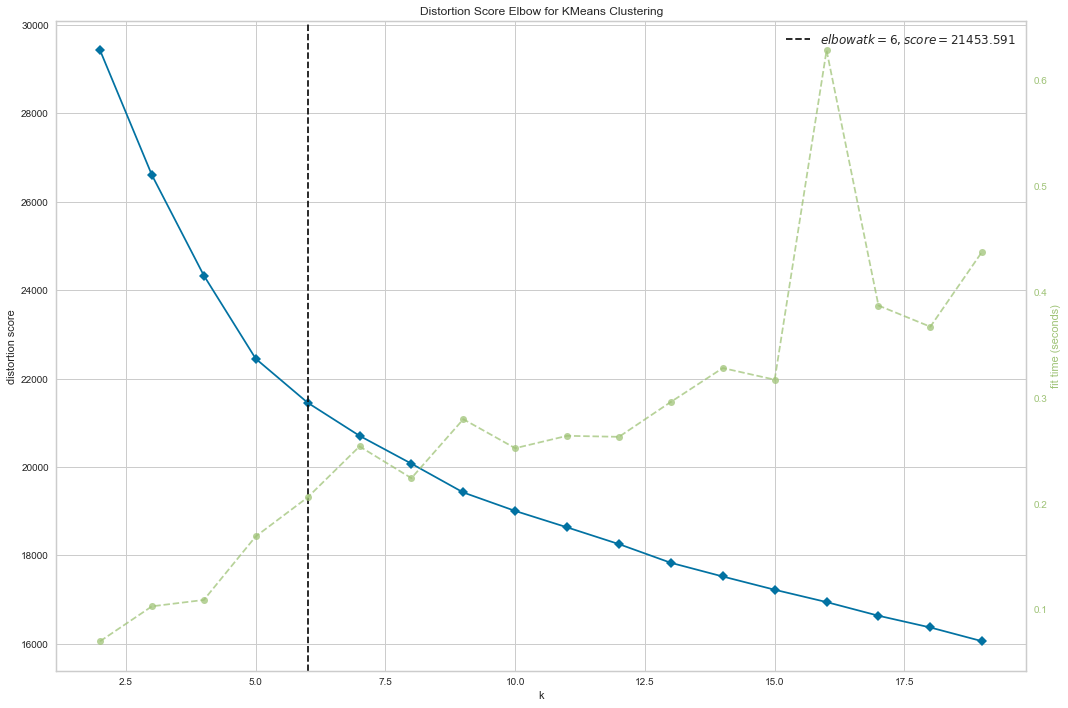

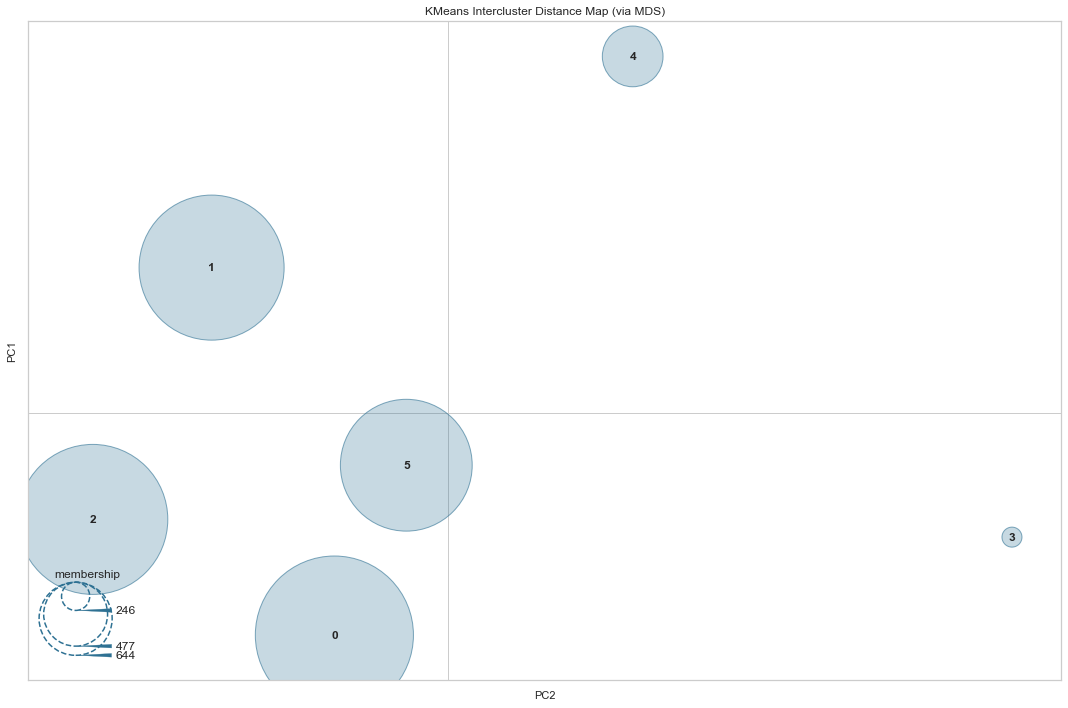

In [536]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
np.random.seed(42)

# Elbow Curve
visualizer = KElbowVisualizer(means, k=(2,20), size=(1080, 720))
visualizer.fit(scaled_df_mm)        # Fit the data to the visualizer
visualizer.show(outpath='./model_pics/cluster/'+'Elbow_Curve.png')        # Finalize and render the figure
plt.show()

# Intra Cluster Distance
visualizer = InterclusterDistance(KMeans(6), size=(1080, 720))
visualizer.fit(scaled_df_mm)        # Fit the data to the visualizer
visualizer.show(outpath='./model_pics/cluster/'+'intra_distance.png')
plt.show()

3    739
1    649
0    592
2    474
4    246
5    237
Name: Cluster, dtype: int64


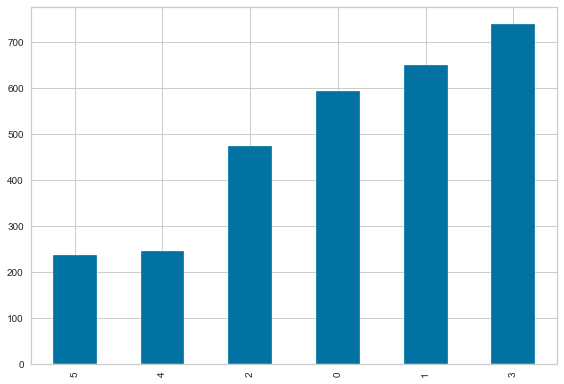

In [537]:
# Following the recommendation above, 6 clusters
means = KMeans(n_clusters=6)
means.fit(scaled_df_mm)
df_household = df_household.assign(Cluster=means.labels_)
print(df_household.Cluster.value_counts())
df_household.Cluster.value_counts(ascending=True).plot(kind='bar')
plt.show()

In [538]:
df_cluster = df_cluster.assign(Cluster=means.labels_)
scale_df_mm = scaled_df_mm.assign(Cluster=means.labels_)
df_kmeans = scale_df_mm.groupby('Cluster').mean().round(3)
df_kmeans.head()

yes_auto_insurance  will_cancel_prob  yes_credit_card  yes_home_equity  yes_id_theft  yes_mortgage  yes_roadside  yes_travel  yes_deposit  aaa_member_tenure_years  total_members_in_household  estimated_cost
Cluster                                                                                                                                                                                                                
0                   -0.2550            0.2440          -0.0060          -0.3020       -0.7170       -0.7460       -1.3240     -0.0510      -0.3100                   0.0290                     -0.4470         -0.8340
1                   -0.6930           -0.5720          -0.6430          -0.3020        0.4870        0.0030        0.6130      0.2480      -0.3000                  -0.0740                      0.4170          0.4960
2                   -0.1740            0.9670          -0.2340          -0.3020        0.3500        0.3250        0.6100     -0.5730      -0.3070                   0.0380                     -0.4260          0.1810
3                    0.9520           -0.4540           0.6650          -0.3020        0.3940        0.6020        0.5040      0.2210      -0.2920                   0.0200                      0.4070          0.4940
4                   -0.2610            0.5520           0.0110          -0.1730       -1.2120       -0.5990       -1.3730     -0.1770       3.2110                   0.1090                     -0.3870         -0.9480

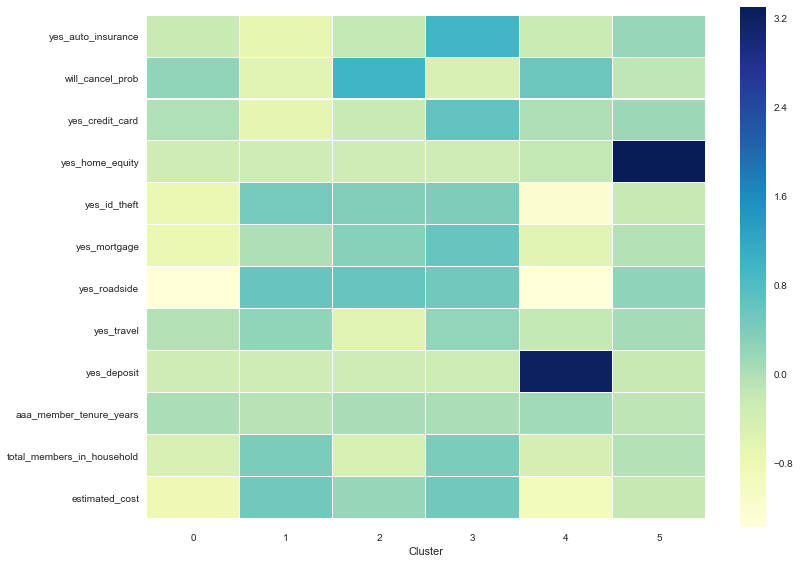

In [539]:
plt.figure(figsize=(12,8))
sns.heatmap(df_kmeans.T,  cmap='YlGnBu', linewidths=0.1, xticklabels=True, yticklabels=True)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.7, top - 0.7)
plt.show()

# Calculate Customer Live Value

* It is a Measurement of customer value
* Can be historical or predicted

* The goal of CLV
    * Measure customer value in revenue / profit 
    * Benchmark customers
    * Identify maximum investment into customer acquisition

# As we do not have the profit margin, we will skip it and do a basic calculation of CLV

CLV = Average Revenue * life Spam

In [292]:
df_transaction = pd.read_csv('capstone_aaa_featured_no_gaps.csv', 
                             parse_dates=['sc_date', 'birth_date_mmddyyyy', 'call_status_recv_date',
                                         'date_of_birth','active_expiration_date', 'cancel_date',
                                         'join_aaa_date', 'join_club_date', 'reinstate_date'
                                         ], 
                             infer_datetime_format=True)
df_transaction.call_status_recv_date = df_transaction.sc_date

In [293]:
df_transaction.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26006 entries, 0 to 26005
Data columns (total 167 columns):
id                                int64
individual_key                    int64
household_key                     int64
member_flag                       int64
city                              object
state_grouped                     object
zip5                              int64
zip9                              int64
fsv_cmsi_flag                     int64
fsv_credit_card_flag              int64
fsv_deposit_program_flag          int64
fsv_home_equity_flag              int64
fsv_id_theft_flag                 int64
fsv_mortgage_flag                 int64
ins_client_flag                   int64
trv_globalware_flag               int64
number_of_children                object
responded_to_catalog              object
race                              object
length_of_residence               int64
mail_responder                    object
home_owner                        object
inc

In [297]:
# AAA Costs
monthly_aaa_costs = df_transaction.groupby(by=['membership_id','csrd_yyyy'])['total_cost'].sum().mean()
monthly_aaa_costs = np.mean(monthly_aaa_costs)

# AAA Revenue
monthly_aaa_rev = df_transaction.groupby(by=['membership_id','csrd_yyyy'])['total_member_cost'].sum().mean()
monthly_aaa_rev = np.mean(monthly_aaa_rev)


# Define Lifespam

lifespam = 36
profit_margin = 0.32
rate_rate = 2498/5281
# Calculate Basic CLV
clv_basic = monthly_aaa_rev*profit_margin * lifespam
print('The average basic CLV (Revenue) is {:.1f} USD'.format(clv_basic))
print('the Average Monthly Revenue is {:.1f} USD'.format(monthly_aaa_rev))
print('The average traditional CLV  is {:.1f} USD at {:.1f}% retention rate'.format(monthly_aaa_rev*rate_rate, rate_rate*100))

The average basic CLV (Revenue) is 3118.1 USD
the Average Monthly Revenue is 270.7 USD
The average traditional CLV  is 128.0 USD at 47.3% retention rate


In [16]:
df_transaction.groupby(by=['membership_id','csrd_yyyymm'])['total_cost'].sum().mean()*36

1936.6533174969816

In [234]:
cust_month_tx = pd.pivot_table(data=df_transaction, index=['membership_id'],
                               values='total_cost',
                               columns=['sc_date'],
                               aggfunc=np.sum, fill_value=0)
cust_month_tx.head()

sc_date        2014-06-01  2014-06-02  2014-06-03  2014-06-04  2014-06-05  2014-06-06  2014-06-07  2014-06-08  2014-06-09  2014-06-10  2014-06-11  2014-06-12  2014-06-13  2014-06-14  2014-06-15  2014-06-16  2014-06-17  2014-06-18  2014-06-19  2014-06-20  2014-06-21  2014-06-22  2014-06-23  2014-06-24  2014-06-25  2014-06-26  2014-06-27  2014-06-28  2014-06-29  2014-06-30  2014-07-01  2014-07-02  2014-07-03  2014-07-04  2014-07-05  2014-07-06  2014-07-07  2014-07-08  2014-07-09  2014-07-10  2014-07-11  2014-07-12  2014-07-13  2014-07-14  2014-07-15  2014-07-16  2014-07-17  2014-07-18  2014-07-19  2014-07-20  2014-07-21  2014-07-22  2014-07-23  2014-07-24  2014-07-25  2014-07-26  2014-07-27  2014-07-28  2014-07-29  2014-07-30  2014-07-31  2014-08-01  2014-08-02  2014-08-03  2014-08-04  2014-08-05  2014-08-06  2014-08-07  2014-08-08  2014-08-09  2014-08-10  2014-08-11  2014-08-12  2014-08-13  2014-08-14  2014-08-15  2014-08-16  2014-08-17  2014-08-18  2014-08-19  2014-08-20  2014-08-21  \
membership_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
153                     0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0   
163                     0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0

In [18]:
df_cancel.head()

length_of_residence  total_members_in_household  mean_total_calls_veh  income_100k_  income_40___99999  credit_ranges_800_  education_completed_college  generation_baby_boomers__1948___1968_  generation_generation_x__1969___1980_  generation_post_war____1948_  aaa_financial_service_0  aaa_credit_card_0  occupation_group_management  occupation_group_professional  occupation_group_retired  kcl_b_ind_mosaicsgrouping_singles_and_starters  aaa_motorcycle_indicator_1_0  tenure_between_21___40_years  aaa_travel_0  no_members_3___member  aaa_cancel  will_cancel_prob
membership_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
153                        15.0000                           1                2.5485             0                  0                   0                            0                                      0                                      0                             1                        1                  0                            0                              0                         0                                               0                             0                             0             1                      0           0            0.2140
155                         0.0000                           1                0.1645             0                  0                   0                            0                                      0                                      0                             0                        1                  1                            0                              0                         0                                               0                             0                             0             1                      0           1            1.0000
163                         8.5556                           4                2.3971             0                  1                   0                            0                                      0                                      0                             0                        1                  1                            0                              0                         0                                               0                             1                             0             1                      0           0            0.0200
182                        15.0000                           1                3.7444             0                  1                   0                            0                                      0                                      0                             1                        1                  1                            0                              0                         1                                               0                             0                             0             1                      0           0            0.3222
188                        15.0000                           3                3.1964             1                  0                   0                            0                                      0                                      0                             1                        1                  1                            0                              0                         1                                               0                             1                             0             0         

In [19]:
df_cancel.will_cancel_prob.value_counts()

1.0000    2324
0.0700     161
0.0800     152
0.1000     119
0.1500     103
0.1100     102
0.1400      92
0.1700      85
0.1200      84
0.0600      82
0.1800      77
0.2500      72
0.1300      70
0.0900      64
0.0400      64
0.1600      64
0.0500      63
0.2300      51
0.1900      49
0.2000      46
0.2100      44
0.4882      43
0.0200      37
0.3300      37
0.3281      35
0.6370      33
0.2400      33
0.0300      33
0.2700      33
0.4226      32
0.2900      31
0.3222      31
0.4312      31
0.4013      30
0.4057      30
0.2800      29
0.3000      26
0.2600      25
0.3600      24
0.3400      21
0.2200      21
0.6941      20
0.4200      18
0.5100      16
0.3200      15
0.3100      14
0.3900      14
0.1767      13
0.3700      13
0.1172      13
0.3800      12
0.1450      12
0.1420      11
0.4212      11
0.1957      11
0.4800      10
0.2075       9
0.1750       9
0.4000       9
0.2033       9
0.5000       8
0.1922       8
0.0950       8
0.2825       8
0.1067       7
0.2038       7
0.4565    

In [460]:
df_household.total_cost.sum()/df_household.total_member_cost.sum()


0.3167281795858237

In [55]:
top_members

mean_total_member_cost  mean_total_cost  will_cancel_prob member_status  mean_estimated_revenue membership_id
membership_id                                                                                                               
54638                         88.1250          21.3750            0.8400        ACTIVE                 66.7500         54638
50051                          0.0000           0.0000            0.8360       PENDING                  0.0000         50051
55788                         16.2500           0.0000            0.7980       PENDING                 16.2500         55788
51083                          0.0000          17.6667            0.7833        ACTIVE                -17.6667         51083
898                            6.5417          44.1667            0.7833        ACTIVE                -37.6250           898
50710                          0.0000          27.0000            0.7500        ACTIVE                -27.0000         50710
12066                          4.4222          39.4444            0.7400        ACTIVE                -35.0222         12066
87965                         54.5850           7.5000            0.7300        ACTIVE                 47.0850         87965
54004                        197.3765          46.9759            0.7300        ACTIVE                150.4006         54004
369292                        89.4800          32.9700            0.7252       PENDING                 56.5100        369292
27744                        176.5500          50.9100            0.7252        ACTIVE                125.6400         27744
50191                         18.3250          84.5000            0.7252        ACTIVE                -66.1750         50191
88235                        380.6700          51.8700            0.7252        ACTIVE                328.8000         88235
8383                          45.1667          29.0000            0.7200        ACTIVE                 16.1667          8383
2225                           0.0000           0.0000            0.7200        ACTIVE                  0.0000          2225
21563                          0.0000           0.0000            0.7200        ACTIVE                  0.0000         21563
4682                           0.0000           0.0000            0.7200        ACTIVE                  0.0000          4682
195987                        29.4250           0.0000            0.7200        ACTIVE                 29.4250        195987
56424                        174.5400           0.0000            0.7121        ACTIVE                174.5400         56424
84667                         45.2500           0.0000            0.7121        ACTIVE                 45.2500         84667
266413                         0.0000           0.0000            0.7121        ACTIVE                  0.0000        266413
226411                         0.0000          13.0000            0.7121        ACTIVE                -13.0000        226411
87594                          0.0000           0.0000            0.7100        ACTIVE                  0.0000         87594
152682                         0.0000           0.0000            0.7100        ACTIVE                  0.0000        152682
194418                        25.9786           8.7143            0.7000       PENDING                 17.2643        194418
50195                          0.0000           0.0000            0.6941        ACTIVE                  0.0000         50195
89761                          0.0000           0.0000            0.6941        ACTIVE                  0.0000         89761
30225                          0.0000          13.2500            0.6941        ACTIVE                -13.2500         30225
29778                          0.0000           0.0000            0.6941        ACTIVE                  0.0000         29778
5662                          16.2500           0.0000            0.6941        ACTIVE                 16.2500          5662
21436          

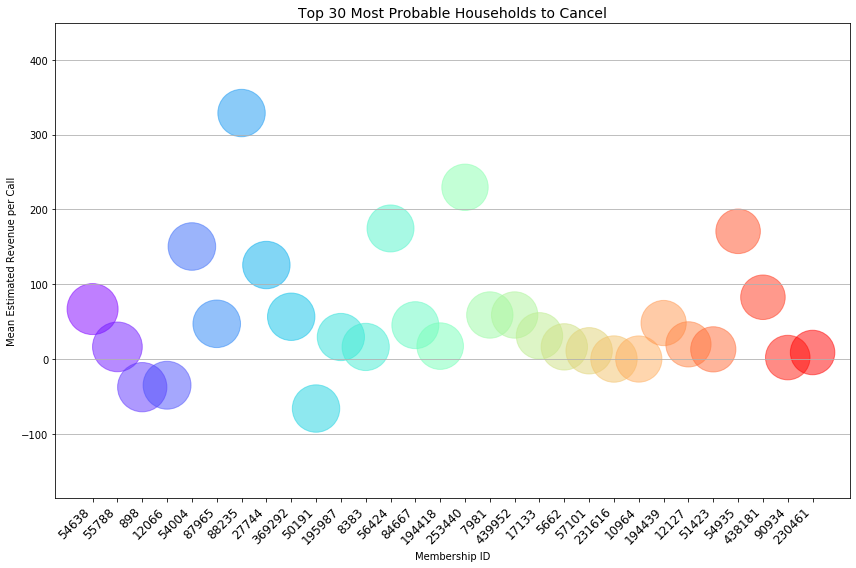

In [308]:
# Graph Time series per household cancel
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','will_cancel_prob', 'member_status'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.will_cancel_prob != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.sort_values(by=['will_cancel_prob', 'mean_estimated_revenue'], ascending=False).head(30)
top_members['membership_id'] = top_members.index.astype(str)
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
plt.scatter(x=top_members.membership_id, y=top_members['mean_estimated_revenue'], 
            s=top_members['will_cancel_prob']*3100, alpha=0.5, c=colors)
plt.ylabel("Mean Estimated Revenue per Call")
plt.xlabel("Membership ID")
plt.title("Top 30 Most Probable Households to Cancel", loc="center")
plt.xticks(rotation=45, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
bottom, top = plt.ylim()
plt.grid(which='major', axis='y')
plt.ylim(bottom - 100, top + 100)
plt.show()

In [454]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 153 to 543695
Data columns (total 98 columns):
household_key                        2937 non-null int64
income                               2937 non-null object
member_status                        2937 non-null object
state_grouped                        2937 non-null object
credit_ranges                        2937 non-null object
cancel_reason                        2937 non-null object
renew_method                         2937 non-null object
plus_indicator_description           2937 non-null object
zip                                  2937 non-null int64
sc_vehicle_manufacturer_name         2937 non-null object
sc_vehicle_model_name                2937 non-null object
race                                 2937 non-null object
home_owner                           2937 non-null object
education                            2937 non-null object
dwelling_type                        2937 non-null object
gender               

In [309]:
df_ts = df_ts[(df_ts.will_cancel_prob != 1)]
threshold = 0.0
df_ts = df_ts[(df_ts.will_cancel_prob >= threshold)]
df_ts.mean_estimated_revenue.sum(), df_ts.mean_estimated_revenue.count()
df_ts.groupby(pd.qcut(df_ts.will_cancel_prob, 5))['will_cancel_prob'].count()

will_cancel_prob
(-0.001, 0.08]    608
(0.08, 0.14]      591
(0.14, 0.21]      586
(0.21, 0.35]      564
(0.35, 0.84]      588
Name: will_cancel_prob, dtype: int64

(2937, 5)

In [310]:
top_members.rename(columns={"mean_total_member_cost": "Mean Member Cost", 'mean_total_cost':'Mean Total AAA Costs', 
                            'will_cancel_prob': "Probability to Cancel", 'mean_estimated_revenue': 'Est. Mean Revenue Loss'
                           },inplace=True)
top_members.drop(columns=['membership_id', 'member_status'], inplace=True)
fig = ff.create_table(top_members, height_constant=30, index=True)
fig.write_image('./model_pics/cancel/'+'aaa_cancel_top_member_to_cancel.png')
py.iplot(fig)

In [266]:
df_ts = pd.DataFrame(df_household, columns=['total_member_cost','total_cost','will_cancel_prob', 'member_status'])
df_ts['estimated_revenue'] = df_ts['total_member_cost'] - df_ts['total_cost']
df_ts = df_ts[(df_ts.will_cancel_prob != 1)]
threshold = 0.0
df_ts = df_ts[(df_ts.will_cancel_prob >= threshold)]
df_ts.estimated_revenue.sum(), df_ts.estimated_revenue.count()

(1040965.3699999999, 2937)

In [99]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 153 to 543695
Data columns (total 97 columns):
household_key                        2937 non-null int64
income                               2937 non-null object
member_status                        2937 non-null object
state_grouped                        2937 non-null object
credit_ranges                        2937 non-null object
cancel_reason                        2937 non-null object
renew_method                         2937 non-null object
plus_indicator_description           2937 non-null object
zip                                  2937 non-null int64
sc_vehicle_manufacturer_name         2937 non-null object
sc_vehicle_model_name                2937 non-null object
race                                 2937 non-null object
home_owner                           2937 non-null object
education                            2937 non-null object
dwelling_type                        2937 non-null object
gender               

In [124]:
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])

In [291]:
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
#df_use = df_use[(df_use.yes_roadside != 1)]
df_use.T.mean(axis=1)

yes_roadside         0.9330
yes_auto_insurance   0.5155
yes_credit_card      0.2066
yes_travel           0.2926
yes_id_theft         0.2222
yes_deposit          0.0890
yes_home_equity      0.0081
will_cancel_prob     0.6081
dtype: float64

In [459]:
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
print(df_use.T.mean(axis=1),'\n')

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_roadside != 1)]
print("\nRoadside mean prob  : ", df_use.T.mean(axis=1).yes_roadside)
print("Roadside mean count : ", df_use.T.count(axis=1).yes_roadside)

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_auto_insurance != 1)]
print("\nInsurance mean prob  : ", df_use.T.mean(axis=1).yes_auto_insurance)
print("\nInsurance mean count : ", df_use.T.count(axis=1).yes_auto_insurance)

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_travel != 1)]
print("\nTravel mean prob : ", df_use.T.mean(axis=1).yes_travel)
print("Travel mean count : ", df_use.T.count(axis=1).yes_travel)

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_credit_card != 1)]
print("\nCredit Card mean prob  : ", df_use.T.mean(axis=1).yes_credit_card)
print("Credit Card mean count : ", df_use.T.count(axis=1).yes_credit_card)

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_id_theft != 1)]
print("\nID theft mean prob : ", df_use.T.mean(axis=1).yes_id_theft)
print("ID theft mean count  : ", df_use.T.count(axis=1).yes_id_theft)

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_deposit != 1)]
print("\nDeposit mean prob  : ", df_use.T.mean(axis=1).yes_deposit)
print("Deposit mean count : ", df_use.T.count(axis=1).yes_deposit)

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_home_equity != 1)]
print("\nHome Equity prob  : ", df_use.T.mean(axis=1).yes_home_equity)
print("Home Equity count   : ", df_use.T.count(axis=1).yes_home_equity)

df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.will_cancel_prob >= threshold)]
df_use = df_use[(df_use.yes_mortgage != 1)]
print("\nFinancial Service Equity prob  : ", df_use.T.mean(axis=1).yes_mortgage)
print("Financial Service Equity count   : ", df_use.T.count(axis=1).yes_mortgage)

yes_roadside         0.9330
yes_auto_insurance   0.5155
yes_credit_card      0.2066
yes_travel           0.2926
yes_id_theft         0.2222
yes_deposit          0.0890
yes_home_equity      0.0081
will_cancel_prob     0.6081
yes_mortgage         0.2830
dtype: float64 


Roadside mean prob  :  0.8493387681159422
Roadside mean count :  92

Insurance mean prob  :  0.3402362580567217

Insurance mean count :  152

Travel mean prob :  0.19978141409288935
Travel mean count :  183

Credit Card mean prob  :  0.1401431959547143
Credit Card mean count :  191

ID theft mean prob :  0.1868181818181817
ID theft mean count  :  198

Deposit mean prob  :  0.08459620506142032
Deposit mean count :  206

Home Equity prob  :  0.0032524271844660197
Home Equity count   :  206

Financial Service Equity prob  :  0.26525302530253025
Financial Service Equity count   :  202


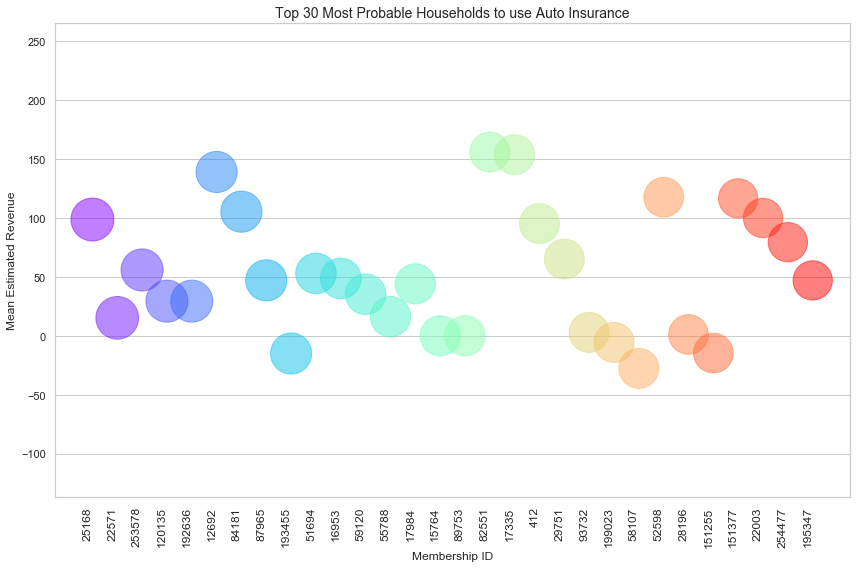

In [471]:
# Graph Time series per household auto insurance
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_auto_insurance', 'member_status'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.yes_auto_insurance != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.sort_values(by=['yes_auto_insurance', 'mean_estimated_revenue'], ascending=False).head(30)
top_members['membership_id'] = top_members.index.astype(str)
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
plt.scatter(x=top_members.membership_id, y=top_members['mean_estimated_revenue'], 
            s=top_members['yes_auto_insurance']*2500, alpha=0.5, c=colors)
plt.ylabel("Mean Estimated Revenue")
plt.xlabel("Membership ID")
plt.title("Top 30 Most Probable Households to use Auto Insurance", loc="center")
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
bottom, top = plt.ylim()
plt.grid(which='major', axis='x')
plt.ylim(bottom - 100, top + 100)
plt.show()

In [472]:
top_members

mean_total_member_cost  mean_total_cost  yes_auto_insurance member_status  mean_estimated_revenue membership_id
membership_id                                                                                                                 
25168                        130.0000          31.2500              0.7400        ACTIVE                 98.7500         25168
22571                         15.2500           0.0000              0.7317        ACTIVE                 15.2500         22571
253578                        55.9250           0.0000              0.7100        ACTIVE                 55.9250        253578
120135                        29.4250           0.0000              0.7100        ACTIVE                 29.4250        120135
192636                        93.5625          64.1375              0.7100        ACTIVE                 29.4250        192636
12692                        169.1333          30.0000              0.6800        ACTIVE                139.1333         12692
84181                        144.3175          38.8500              0.6800        ACTIVE                105.4675         84181
87965                         54.5850           7.5000              0.6800        ACTIVE                 47.0850         87965
193455                        29.4250          44.4250              0.6800        ACTIVE                -15.0000        193455
51694                         53.0000           0.0000              0.6600       PENDING                 53.0000         51694
16953                         48.7500           0.0000              0.6600        ACTIVE                 48.7500         16953
59120                         35.3333           0.0000              0.6600        ACTIVE                 35.3333         59120
55788                         16.2500           0.0000              0.6520       PENDING                 16.2500         55788
17984                         57.8750          13.7383              0.6500        ACTIVE                 44.1367         17984
15764                         21.9625          21.9625              0.6500        ACTIVE                  0.0000         15764
89753                         32.5000          32.5000              0.6500        ACTIVE                  0.0000         89753
82551                        195.7320          39.6900              0.6400        ACTIVE                156.0420         82551
17335                        201.7714          47.9357              0.6400        ACTIVE                153.8357         17335
412                          141.2400          45.9100              0.6400        ACTIVE                 95.3300           412
29751                        107.8917          42.7583              0.6400        ACTIVE                 65.1333         29751
93732                         58.8500          55.9250              0.6400        ACTIVE                  2.9250         93732
199023                        31.8000          37.4000              0.6400        ACTIVE                 -5.6000        199023
58107                         19.6167          47.2833              0.6400        ACTIVE                -27.6667         58107
52598                        150.2000          32.5000              0.6300       PENDING                117.7000         52598
28196                         23.5400          22.3700              0.6300        ACTIVE                  1.1700         28196
151255                        31.2077          45.8462              0.6300        ACTIVE                -14.6385        151255
151377                       162.4667          45.7833              0.6200        ACTIVE                116.6833        151377
22003                        144.1893          44.1214              0.6200        ACTIVE                100.0679         22003
254477                       106.0000          26.5000              0.6200        ACTIVE                 79.5000        254477
195347                        69.8000          22.7500              0.6200    

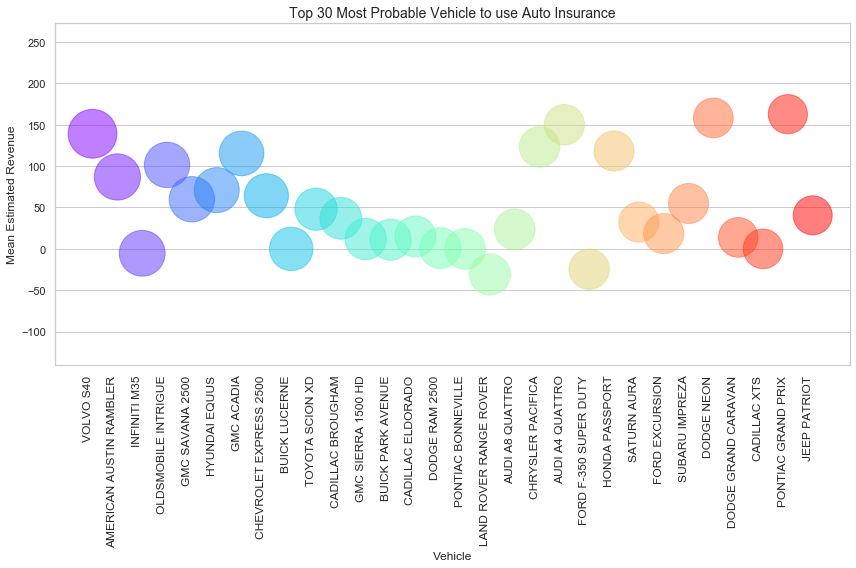

In [476]:
# Graph Time series per household auto insurance
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_auto_insurance', 
                                            'vehicle', 'member_status'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.member_status != 'CANCELLED')]
t_membership_id = t_membership_id[(t_membership_id.vehicle != 'UNKNOWN UNKNOWN')]
t_membership_id = t_membership_id[(t_membership_id.yes_auto_insurance != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.groupby(by='vehicle').mean()
top_members = top_members.nlargest(30, columns=['yes_auto_insurance','mean_estimated_revenue'])
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
plt.scatter(x=top_members.index, y=top_members['mean_estimated_revenue'], 
            s=top_members['yes_auto_insurance']*3500, alpha=0.5, c=colors)
plt.ylabel("Mean Estimated Revenue")
plt.xlabel("Vehicle")
plt.title("Top 30 Most Probable Vehicle to use Auto Insurance", loc="center")
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
bottom, top = plt.ylim()
plt.grid(which='major', axis='x')
plt.ylim(bottom - 100, top + 100)
plt.show()

In [477]:
top_members

mean_total_member_cost  mean_total_cost  yes_auto_insurance  mean_estimated_revenue
vehicle                                                                                                     
VOLVO S40                              169.1333          30.0000              0.6800                139.1333
AMERICAN AUSTIN RAMBLER                112.0000          25.0909              0.6100                 86.9091
INFINITI M35                            24.6667          30.0000              0.6000                 -5.3333
OLDSMOBILE INTRIGUE                    131.0000          29.5417              0.5900                101.4583
GMC SAVANA 2500                         88.3980          28.4700              0.5900                 59.9280
HYUNDAI EQUUS                           97.4950          26.5000              0.5800                 70.9950
GMC ACADIA                             170.7000          55.3400              0.5700                115.3600
CHEVROLET EXPRESS 2500                 102.5694          38.3548              0.5567                 64.2146
BUICK LUCERNE                           32.5000          32.5000              0.5400                  0.0000
TOYOTA SCION XD                         74.5667          26.6667              0.5100                 47.9000
CADILLAC BROUGHAM                       90.1818          53.1818              0.5000                 37.0000
GMC SIERRA 1500 HD                      24.0000          12.1667              0.4900                 11.8333
BUICK PARK AVENUE                       51.2172          40.1511              0.4867                 11.0661
CADILLAC ELDORADO                       54.3231          39.2962              0.4800                 15.0269
DODGE RAM 2500                          15.0000          14.0000              0.4800                  1.0000
PONTIAC BONNEVILLE                      22.8000          23.0000              0.4800                 -0.2000
LAND ROVER RANGE ROVER                  34.0000          65.0000              0.4800                -31.0000
AUDI A8 QUATTRO                         62.4375          38.7437              0.4750                 23.6938
CHRYSLER PACIFICA                      166.3143          43.1000              0.4700                123.2143
AUDI A4 QUATTRO                        190.5794          40.5544              0.4650                150.0250
FORD F-350 SUPER DUTY                   28.5000          53.1000              0.4650                -24.6000
HONDA PASSPORT                         159.0167          40.7500              0.4600                118.2667
SATURN AURA                             88.2750          55.9250              0.4600                 32.3500
FORD EXCURSION                          54.1200          35.6667              0.4600                 18.4533
SUBARU IMPREZA                         103.5168          48.7025              0.4580                 54.8143
DODGE NEON                             189.8346          31.6038              0.4500                158.2308
DODGE GRAND CARAVAN                     40.7739          26.9361              0.4500                 13.8378
CADILLAC XTS                            17.6667          17.6667              0.4500                  0.0000
PONTIAC GRAND PRIX                     208.1929          45.4286              0.4400                162.7643
JEEP PATRIOT                            65.0208          24.5000              0.4350                 40.5208

In [311]:
df_ts = pd.DataFrame(df_household, columns=['total_member_cost','total_cost','yes_auto_insurance', 
                                            'vehicle', 'member_status'])
df_ts['estimated_revenue'] = df_ts['total_member_cost'] - df_ts['total_cost']
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts = df_ts[(df_ts.vehicle != 'UNKNOWN UNKNOWN')]
df_ts = df_ts[(df_ts.yes_auto_insurance != 1)]
threshold = 0.
df_ts = df_ts[(df_ts.yes_auto_insurance >= threshold)]
df_ts.estimated_revenue.sum(), df_ts.estimated_revenue.count()
df_ts.groupby(pd.qcut(df_ts.yes_auto_insurance, 5))['yes_auto_insurance'].count()

yes_auto_insurance
(0.079, 0.27]    311
(0.27, 0.312]    249
(0.312, 0.36]    289
(0.36, 0.43]     288
(0.43, 0.74]     262
Name: yes_auto_insurance, dtype: int64

In [413]:
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob'
                                           ])
df_use = df_use[(df_use.yes_auto_insurance !=1)]
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
#df_use = df_use[(df_use.yes_roadside != 1)]
df_use.T.mean(axis=1)

yes_roadside         0.9485
yes_auto_insurance   0.5789
yes_credit_card      0.4837
yes_travel           0.3751
yes_id_theft         0.3203
yes_deposit          0.0828
yes_home_equity      0.0066
will_cancel_prob     0.2598
dtype: float64

In [412]:
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
df_use = df_use[(df_use.yes_auto_insurance !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
print(df_use.T.mean(axis=1),'\n\n')

# RoadSide
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
df_use = df_use[(df_use.yes_auto_insurance !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_roadside != 1)]
print("\nRoadside mean prob  : ", df_use.T.mean(axis=1).yes_roadside)
print("Roadside mean count : ", df_use.T.count(axis=1).yes_roadside)

# Travel
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
df_use = df_use[(df_use.yes_auto_insurance !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_travel != 1)]
print("\nTravel mean prob : ", df_use.T.mean(axis=1).yes_travel)
print("Travel mean count : ", df_use.T.count(axis=1).yes_travel)

# Credit Card
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
df_use = df_use[(df_use.yes_auto_insurance !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_credit_card != 1)]
print("\nCredit Card mean prob  : ", df_use.T.mean(axis=1).yes_credit_card)
print("Credit Card mean count : ", df_use.T.count(axis=1).yes_credit_card)

# Id Theft
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_id_theft != 1)]
print("\nID theft mean prob : ", df_use.T.mean(axis=1).yes_id_theft)
print("ID theft mean count : ", df_use.T.count(axis=1).yes_id_theft)

# Deposit
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_deposit != 1)]
print("\nDeposit mean prob : ", df_use.T.mean(axis=1).yes_deposit)
print("Deposit mean count : ", df_use.T.count(axis=1).yes_deposit)

# Home Equity
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_home_equity != 1)]
print("\nHome Equity prob  : ", df_use.T.mean(axis=1).yes_home_equity)
print("Home Equity count : ", df_use.T.count(axis=1).yes_home_equity)

# Home Equity
df_use = pd.DataFrame(df_household, columns=['yes_roadside','yes_auto_insurance','yes_credit_card', 'yes_travel',
                                            'yes_id_theft', 'yes_deposit', 'yes_home_equity', 'will_cancel_prob','yes_mortgage'
                                           ])
df_use = df_use[(df_use.will_cancel_prob !=1)]
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use = df_use[(df_use.yes_mortgage != 1)]
print("\nMortgage Equity prob   : ", df_use.T.mean(axis=1).yes_mortgage)
print("Mortgage Equity count  : ", df_use.T.count(axis=1).yes_mortgage)

yes_roadside         0.9485
yes_auto_insurance   0.5789
yes_credit_card      0.4837
yes_travel           0.3751
yes_id_theft         0.3203
yes_deposit          0.0828
yes_home_equity      0.0066
will_cancel_prob     0.2598
yes_mortgage         0.4472
dtype: float64 



Roadside mean prob  :  0.8113135593220338
Roadside mean count :  59

Travel mean prob :  0.18687036240198887
Travel mean count :  166

Credit Card mean prob  :  0.15509090909090897
Credit Card mean count :  132

ID theft mean prob :  0.27534101825168095
ID theft mean count :  1041

Deposit mean prob :  0.037822859983979135
Deposit mean count :  1113

Home Equity prob  :  0.004471326164874547
Home Equity count :  1116

Mortgage Equity prob   :  0.2952873965255917
Mortgage Equity count  :  953


In [408]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 153 to 543695
Data columns (total 98 columns):
household_key                        2937 non-null int64
income                               2937 non-null object
member_status                        2937 non-null object
state_grouped                        2937 non-null object
credit_ranges                        2937 non-null object
cancel_reason                        2937 non-null object
renew_method                         2937 non-null object
plus_indicator_description           2937 non-null object
zip                                  2937 non-null int64
sc_vehicle_manufacturer_name         2937 non-null object
sc_vehicle_model_name                2937 non-null object
race                                 2937 non-null object
home_owner                           2937 non-null object
education                            2937 non-null object
dwelling_type                        2937 non-null object
gender               

In [490]:
df_use = pd.DataFrame(df_household, columns=['yes_auto_insurance','will_cancel_prob', 'income'])
df_use = df_use[(df_use.will_cancel_prob !=1)]
df_use = df_use[(df_use.yes_auto_insurance !=1)]
df_use = df_use[(df_use['income'] !='UNKNOWN')]
df_use.drop('will_cancel_prob', axis=1, inplace=True)
threshold = 0.5
df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
df_use.groupby('income').mean()


yes_auto_insurance
income                          
100k+                     0.5708
40 - 99,999               0.5807
UNDER 39,999              0.5753

In [491]:
df_use.shape

(138, 2)

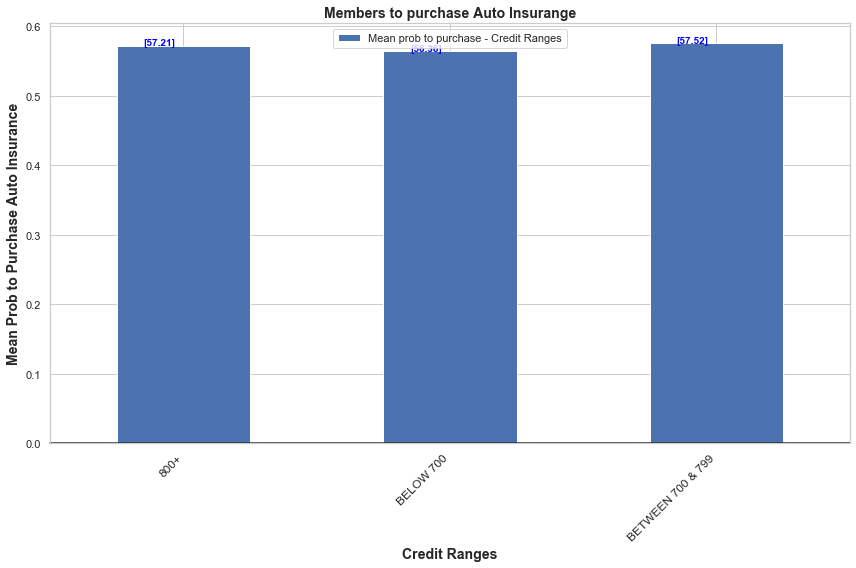

Total Members in  Credit Ranges  :  129
Mean Prop in  Credit Ranges  :  0.5703207292563882
BETWEEN 700 & 799    86
BELOW 700            25
800+                 18
Name: credit_ranges, dtype: int64


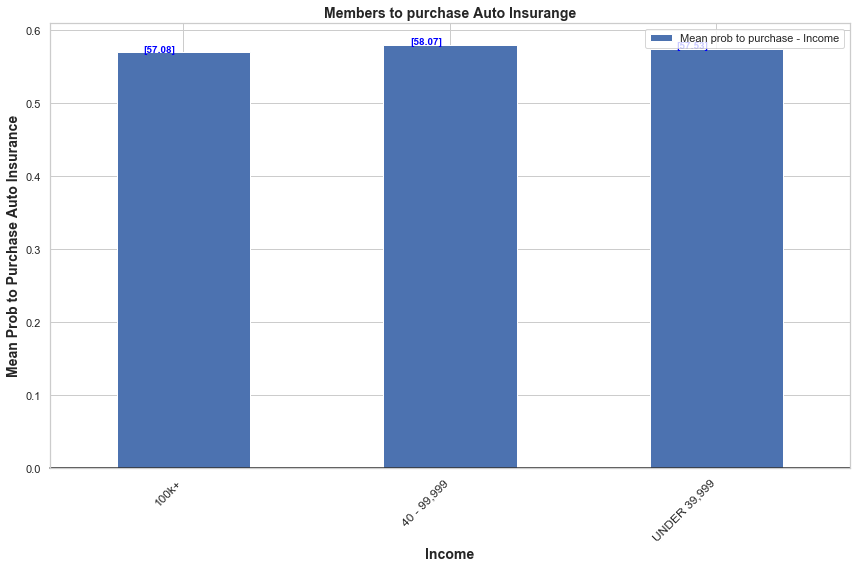

Total Members in  Income  :  138
Mean Prop in  Income  :  0.5755744384814153
40 - 99,999     86
100k+           39
UNDER 39,999    13
Name: income, dtype: int64


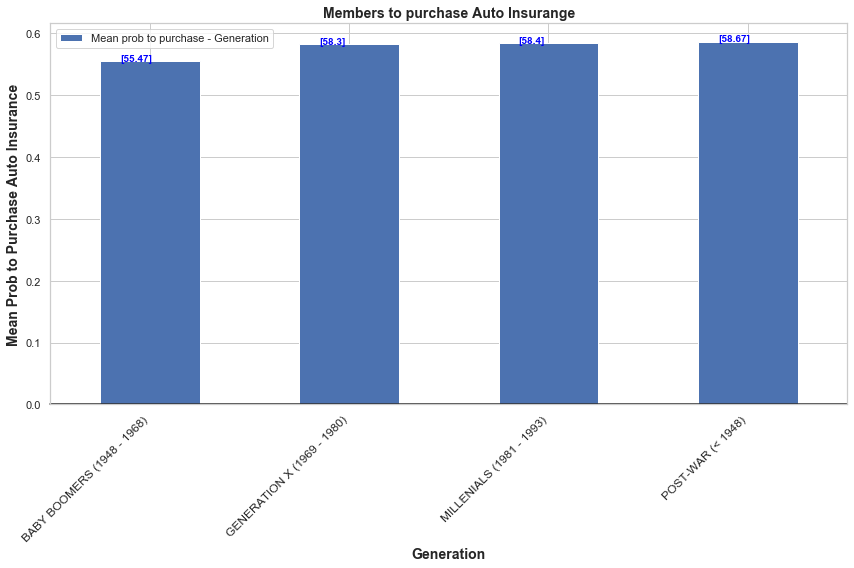

Total Members in  Generation  :  212
Mean Prop in  Generation  :  0.5770991680085883
POST-WAR (< 1948)             138
BABY BOOMERS (1948 - 1968)     54
MILLENIALS (1981 - 1993)       10
GENERATION X (1969 - 1980)     10
Name: generation, dtype: int64


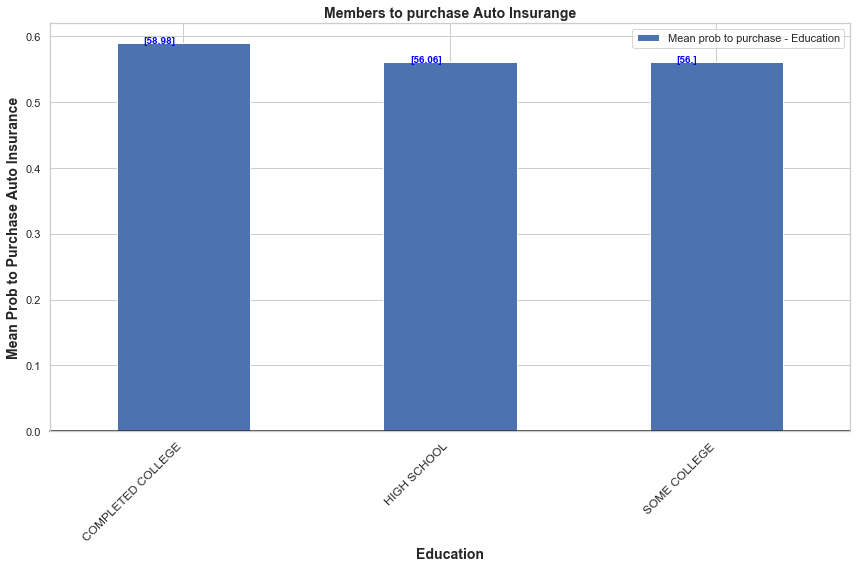

Total Members in  Education  :  85
Mean Prop in  Education  :  0.5701489251489252
HIGH SCHOOL          39
SOME COLLEGE         35
COMPLETED COLLEGE    11
Name: education, dtype: int64


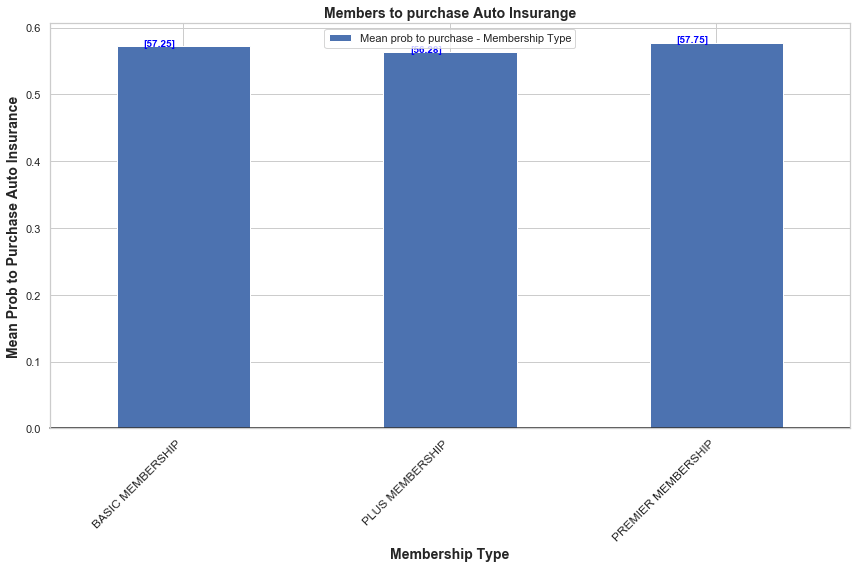

Total Members in  Membership Type  :  149
Mean Prop in  Membership Type  :  0.5709356725146201
BASIC MEMBERSHIP      88
PLUS MEMBERSHIP       57
PREMIER MEMBERSHIP     4
Name: plus_indicator_description, dtype: int64


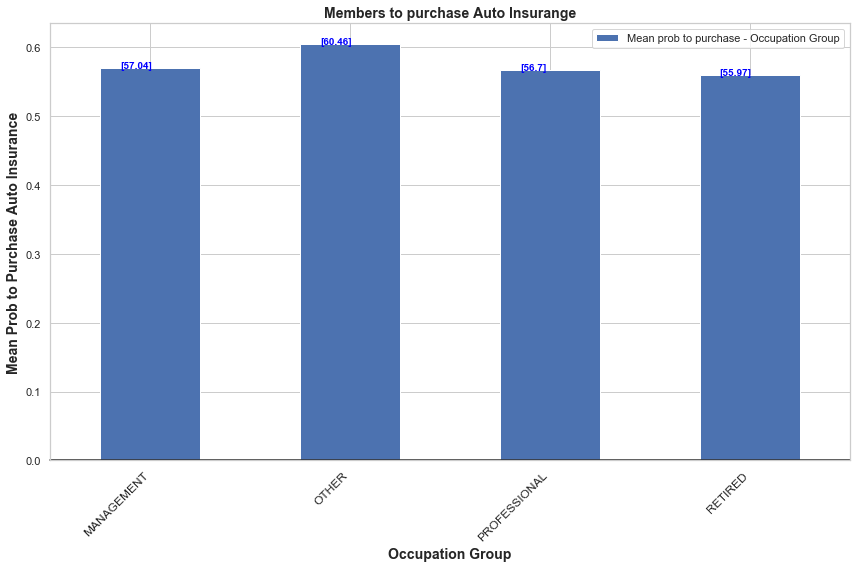

Total Members in  Occupation Group  :  97
Mean Prop in  Occupation Group  :  0.5754152906248494
PROFESSIONAL    37
RETIRED         34
MANAGEMENT      22
OTHER            4
Name: occupation_group, dtype: int64


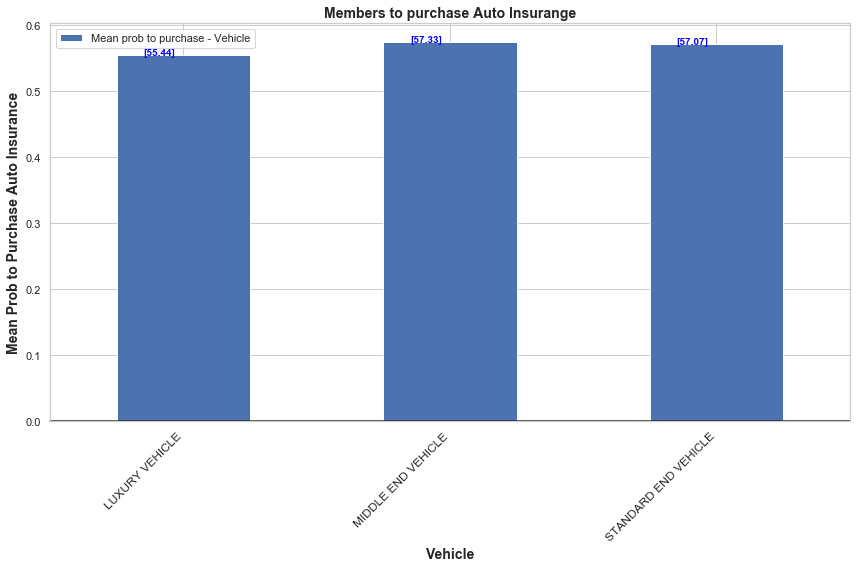

Total Members in  Vehicle  :  149
Mean Prop in  Vehicle  :  0.5661718275652703
STANDARD END VEHICLE    122
LUXURY VEHICLE           18
MIDDLE END VEHICLE        9
Name: sc_vehicle_manufacturer_name, dtype: int64


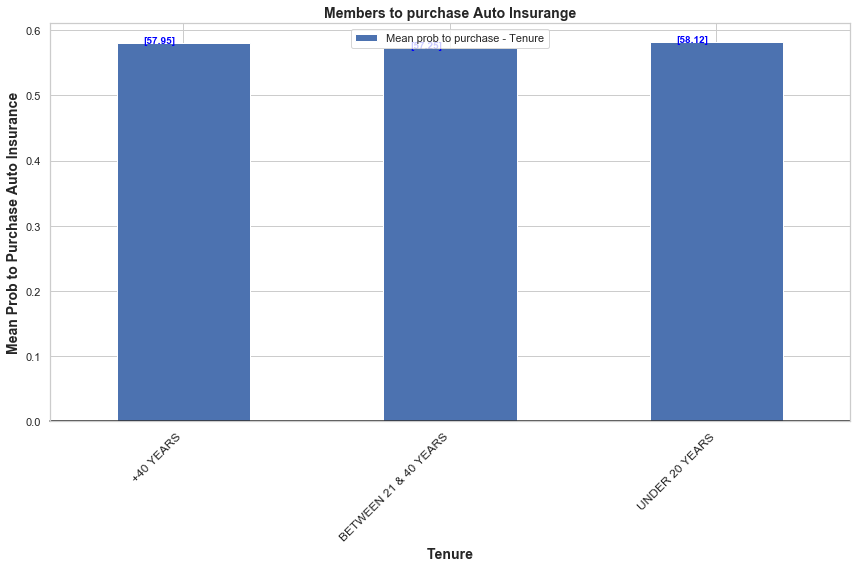

Total Members in  Tenure  :  216
Mean Prop in  Tenure  :  0.5777230244814996
+40 YEARS                142
UNDER 20 YEARS            45
BETWEEN 21 & 40 YEARS     29
Name: tenure, dtype: int64


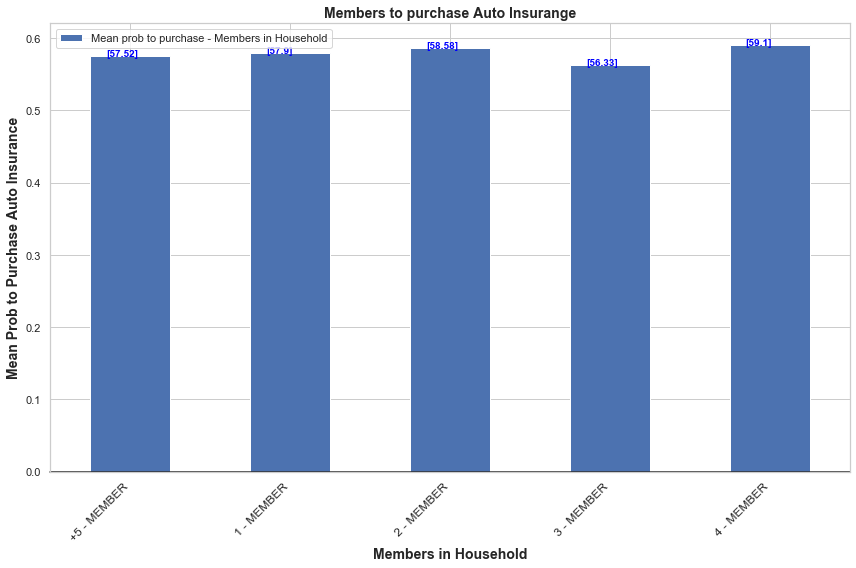

Total Members in  Members in Household  :  216
Mean Prop in  Members in Household  :  0.5788562448812449
2 - MEMBER     74
1 - MEMBER     56
3 - MEMBER     44
+5 - MEMBER    21
4 - MEMBER     21
Name: no_members, dtype: int64


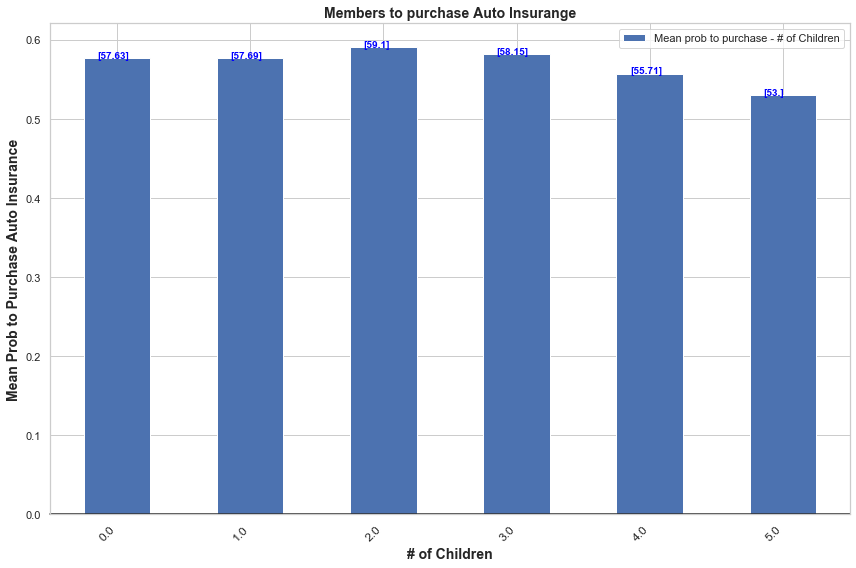

Total Members in  # of Children  :  216
Mean Prop in  # of Children  :  0.5688230667732523
1.0000    101
0.0000     48
2.0000     45
3.0000     13
4.0000      7
5.0000      2
Name: aaa_mean_child, dtype: int64


In [492]:
columns=['credit_ranges', 'income', 'generation', 'education',
         'plus_indicator_description', 'occupation_group', 'sc_vehicle_manufacturer_name',
         'tenure','no_members', 'aaa_mean_child'
        ]

dict_col={'credit_ranges':'Credit Ranges', 'income':'Income', 'generation':'Generation', 'education':'Education',
         'plus_indicator_description':'Membership Type', 'occupation_group':'Occupation Group', 'sc_vehicle_manufacturer_name':'Vehicle',
         'tenure':'Tenure','no_members':'Members in Household', 'aaa_mean_child':'# of Children'
         }
for col in columns:
    df_use = pd.DataFrame(df_household, columns=['yes_auto_insurance','will_cancel_prob', col])
    df_use = df_use[(df_use.will_cancel_prob !=1)]
    df_use = df_use[(df_use.yes_auto_insurance !=1)]
    df_use = df_use[(df_use[col] !='UNKNOWN')]
    df_use.drop('will_cancel_prob', axis=1, inplace=True)
    threshold = 0.5
    df_use = df_use[(df_use.yes_auto_insurance >= threshold)]
    counts = df_use.groupby(col).mean()
    df_use.groupby(col).mean().plot(kind='bar')
    plt.legend(['Mean prob to purchase - '+dict_col[col]] , loc='best')
    plt.axhline(0, color="k", clip_on=False)
    plt.ylabel("Mean Prob to Purchase Auto Insurance",fontsize=14, fontweight='bold')
    plt.xlabel(dict_col[col], fontsize=14, fontweight='bold')
    plt.title('Members to purchase Auto Insurange',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='large')
    i = 0
    for v in list(counts.values):
        plt.text(i-.15, v, str(np.round(v*100,2)), color='blue', fontweight='bold')
        i +=1
    plt.show()
    print('Total Members in ', dict_col[col], ' : ', df_use.shape[0])
    print('Mean Prop in ', dict_col[col],' : ', np.mean(counts.values))
    print(df_use[col].value_counts())
    

In [427]:
df_use

yes_auto_insurance  aaa_mean_child
membership_id                                    
153                        0.5900          2.0000
163                        0.3200          1.0000
188                        0.2800          2.0000
191                        0.1500          4.0000
205                        0.2400          2.0000
...                           ...             ...
543334                     0.3100          1.0000
543482                     0.2900          2.0000
543496                     0.1400          4.0000
543537                     0.3900          3.0000
543695                     0.2300          3.0000

[2032 rows x 2 columns]

In [433]:
df_use = pd.DataFrame(df_household, columns=['yes_auto_insurance','will_cancel_prob','member_status', col])
df_use = df_use[(df_use.will_cancel_prob !=1)]
df_use = df_use[(df_use.yes_auto_insurance !=1)]
df_use = df_use[(df_use[col] !='UNKNOWN')]
#df_use.drop('will_cancel_prob', axis=1, inplace=True)

In [435]:
df_use.member_status.value_counts()

ACTIVE     1846
PENDING     186
Name: member_status, dtype: int64

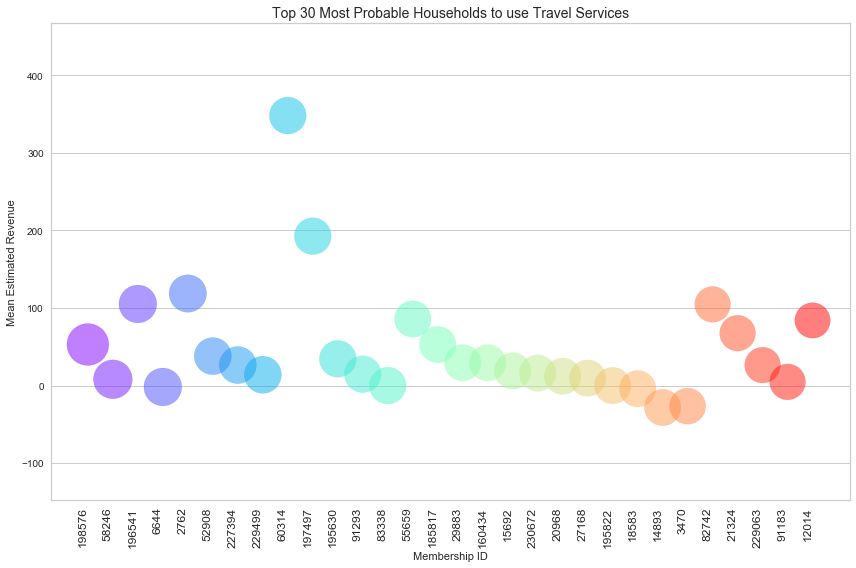

In [544]:
# Graph Time series per household travel services
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_travel', 'member_status'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.yes_travel != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.sort_values(by=['yes_travel', 'mean_estimated_revenue'], ascending=False).head(30)
top_members['membership_id'] = top_members.index.astype(str)
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
plt.scatter(x=top_members.membership_id, y=top_members['mean_estimated_revenue'], 
            s=top_members['yes_travel']*2500, alpha=0.5, c=colors)
plt.ylabel("Mean Estimated Revenue")
plt.xlabel("Membership ID")
plt.title("Top 30 Most Probable Households to use Travel Services", loc="center")
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
bottom, top = plt.ylim()
plt.grid(which='major', axis='x')
plt.ylim(bottom - 100, top + 100)
plt.show()

In [545]:
top_members

mean_total_member_cost  mean_total_cost  yes_travel member_status  mean_estimated_revenue membership_id
membership_id                                                                                                         
198576                        53.0000           0.0000      0.7000        ACTIVE                 53.0000        198576
58246                          8.1250           0.0000      0.6000        ACTIVE                  8.1250         58246
196541                       144.8500          39.5700      0.5700        ACTIVE                105.2800        196541
6644                          69.7500          71.5000      0.5700        ACTIVE                 -1.7500          6644
2762                         162.6150          43.8525      0.5600        ACTIVE                118.7625          2762
52908                         66.0000          28.0000      0.5500       PENDING                 38.0000         52908
227394                        26.5000           0.0000      0.5500        ACTIVE                 26.5000        227394
229499                        14.0000           0.0000      0.5500        ACTIVE                 14.0000        229499
60314                        395.5500          47.3506      0.5400        ACTIVE                348.1994         60314
197497                       232.6570          39.9200      0.5400       PENDING                192.7370        197497
195630                        72.1625          37.6100      0.5400        ACTIVE                 34.5525        195630
91293                         42.6750          27.9625      0.5400        ACTIVE                 14.7125         91293
83338                         17.7500          17.7500      0.5400        ACTIVE                  0.0000         83338
55659                        129.6375          43.8208      0.5300        ACTIVE                 85.8167         55659
185817                        53.0000           0.0000      0.5300        ACTIVE                 53.0000        185817
29883                         29.4250           0.0000      0.5300        ACTIVE                 29.4250         29883
160434                        29.4250           0.0000      0.5300        ACTIVE                 29.4250        160434
15692                         48.4150          29.4250      0.5300        ACTIVE                 18.9900         15692
230672                        16.0950           0.0000      0.5300       PENDING                 16.0950        230672
20968                         12.1250           0.0000      0.5300        ACTIVE                 12.1250         20968
27168                         19.3333           9.6667      0.5300        ACTIVE                  9.6667         27168
195822                        19.6167          19.6167      0.5300        ACTIVE                  0.0000        195822
18583                         21.4167          25.4167      0.5300        ACTIVE                 -4.0000         18583
14893                         11.5000          39.7500      0.5300        ACTIVE                -28.2500         14893
3470                          13.2500          39.7500      0.5200        ACTIVE                -26.5000          3470
82742                        153.5114          48.7843      0.5100        ACTIVE                104.7271         82742
21324                         92.5185          24.9231      0.5100        ACTIVE                 67.5954         21324
229063                        51.5455          25.1136      0.5100        ACTIVE                 26.4318        229063
91183                         21.2000          16.4000      0.5100        ACTIVE                  4.8000         91183
12014                        121.0500          37.0389      0.5000        ACTIVE                 84.0111         12014

In [312]:
df_ts = pd.DataFrame(df_household, columns=['total_member_cost','total_cost','yes_travel', 
                                            'member_status'])
df_ts['estimated_revenue'] = df_ts['total_member_cost'] - df_ts['total_cost']
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts = df_ts[(df_ts.yes_travel != 1)]
threshold = 0.0
df_ts = df_ts[(df_ts.yes_travel >= threshold)]
df_ts.estimated_revenue.sum(), df_ts.estimated_revenue.count()
df_ts.groupby(pd.qcut(df_ts.yes_travel, 5))['yes_travel'].count()

yes_travel
(0.019, 0.14]    485
(0.14, 0.19]     483
(0.19, 0.25]     522
(0.25, 0.32]     428
(0.32, 0.7]      465
Name: yes_travel, dtype: int64

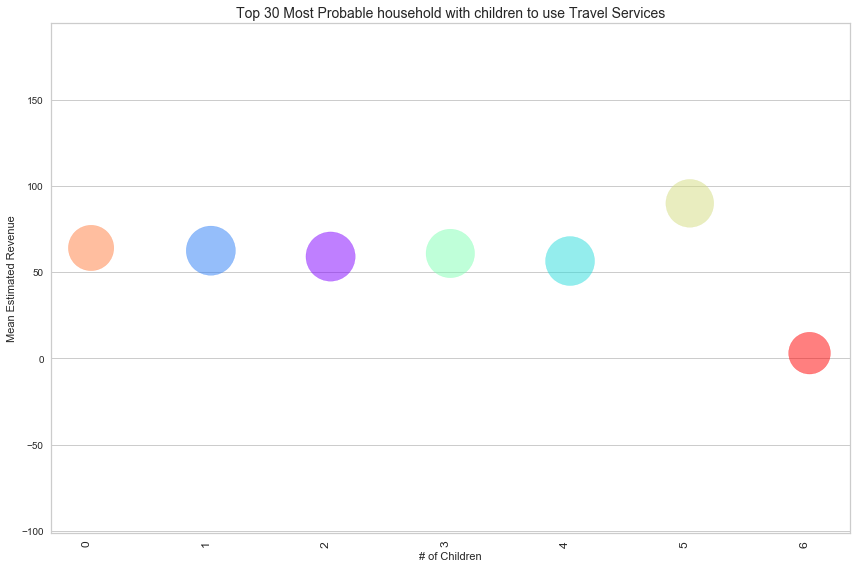

In [560]:
# Graph Time series per household travel
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_travel', 
                                            'aaa_mean_child', 'member_status'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.member_status != 'CANCELLED')]
t_membership_id = t_membership_id[(t_membership_id.yes_travel != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.groupby(by='aaa_mean_child').mean()
top_members = top_members.nlargest(30, columns=['yes_travel','mean_estimated_revenue'])
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
plt.scatter(x=top_members.index, y=top_members['mean_estimated_revenue'], 
            s=top_members['yes_travel']*10000, alpha=0.5, c=colors)
plt.ylabel("Mean Estimated Revenue")
plt.xlabel("# of Children")
plt.title("Probable household with children to use Travel Services", loc="center")
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
bottom, top = plt.ylim()
plt.grid(which='major', axis='x')
plt.ylim(bottom - 100, top + 100)
plt.show()

In [561]:
top_members

mean_total_member_cost  mean_total_cost  yes_travel  mean_estimated_revenue
aaa_mean_child                                                                             
2.0000                         92.6277          33.5533      0.2427                 59.0744
1.0000                         96.7869          34.3022      0.2424                 62.4847
4.0000                         90.0517          33.5709      0.2407                 56.4808
3.0000                         93.7140          32.8293      0.2361                 60.8847
5.0000                        122.7560          32.8018      0.2292                 89.9542
0.0000                         98.7440          34.6827      0.2071                 64.0613
6.0000                         40.1715          37.1316      0.1750                  3.0399

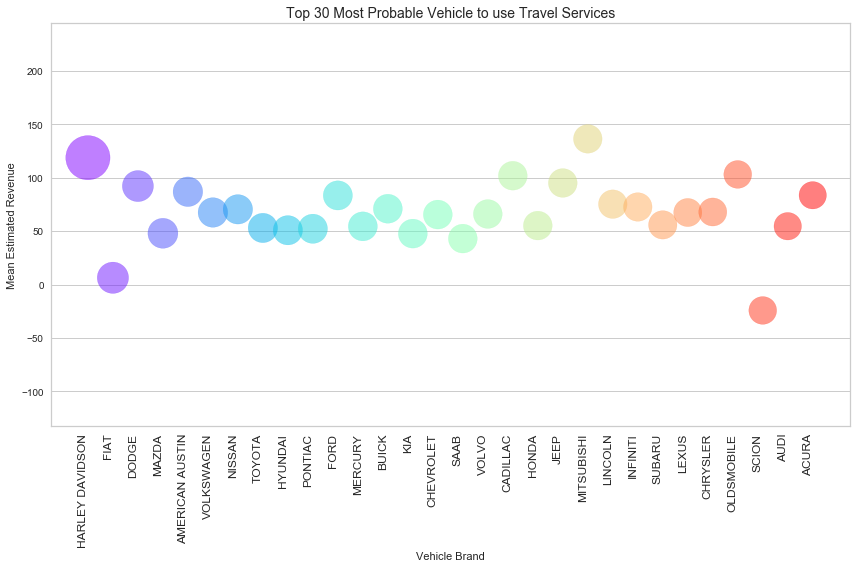

In [571]:
# Graph Time series per household travel 
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_travel', 
                                            'sc_vehicle_manufacturer_name', 'member_status'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.member_status != 'CANCELLED')]
t_membership_id = t_membership_id[(t_membership_id.sc_vehicle_manufacturer_name != 'UNKNOWN')]
t_membership_id = t_membership_id[(t_membership_id.yes_travel != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.groupby(by='sc_vehicle_manufacturer_name').mean()
top_members = top_members.nlargest(30, columns=['yes_travel','mean_estimated_revenue'])
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
plt.scatter(x=top_members.index, y=top_members['mean_estimated_revenue'], 
            s=top_members['yes_travel']*3500, alpha=0.5, c=colors)
plt.ylabel("Mean Estimated Revenue")
plt.xlabel("Vehicle Brand")
plt.title("Top 30 Most Probable Vehicle to use Travel Services", loc="center")
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
bottom, top = plt.ylim()
plt.grid(which='major', axis='x')
plt.ylim(bottom - 100, top + 100)
plt.show()

In [572]:
top_members

mean_total_member_cost  mean_total_cost  yes_travel  mean_estimated_revenue
sc_vehicle_manufacturer_name                                                                             
HARLEY DAVIDSON                             162.6150          43.8525      0.5600                118.7625
FIAT                                         79.8500          73.4250      0.2800                  6.4250
DODGE                                       135.1389          42.9093      0.2762                 92.2296
MAZDA                                        88.2468          40.2167      0.2567                 48.0302
AMERICAN AUSTIN                             112.0000          25.0909      0.2500                 86.9091
VOLKSWAGEN                                  108.7198          41.2053      0.2498                 67.5145
NISSAN                                      109.9273          39.4687      0.2472                 70.4586
TOYOTA                                       90.8519          37.8219      0.2456                 53.0301
HYUNDAI                                      85.0619          34.1752      0.2449                 50.8867
PONTIAC                                      92.1054          39.8317      0.2440                 52.2736
FORD                                        121.9619          38.4879      0.2429                 83.4740
MERCURY                                      92.8562          38.3303      0.2400                 54.5259
BUICK                                       111.3648          40.3518      0.2391                 71.0130
KIA                                          87.4397          39.7068      0.2387                 47.7330
CHEVROLET                                   105.0673          39.5146      0.2385                 65.5527
SAAB                                         79.6494          36.5897      0.2371                 43.0597
VOLVO                                       111.2497          45.1636      0.2367                 66.0862
CADILLAC                                    150.0235          48.1142      0.2364                101.9093
HONDA                                        93.1445          37.9089      0.2362                 55.2356
JEEP                                        137.0984          41.9828      0.2355                 95.1156
MITSUBISHI                                  166.8556          30.4719      0.2333                136.3837
LINCOLN                                     111.6430          36.3486      0.2331                 75.2944
INFINITI                                    106.8722          34.2149      0.2329                 72.6574
SUBARU                                       97.1645          41.2543      0.2305                 55.9102
LEXUS                                       104.0240          36.5431      0.2262                 67.4809
CHRYSLER                                    108.7472          40.7730      0.2248                 67.9742
OLDSMOBILE                                  138.0558          34.9345      0.2208                103.1212
SCION                                        10.8333          35.0000      0.2200                -24.1667
AUDI                                         85.2154          30.5662      0.2156                 54.6491
ACURA                                       123.3810          39.7583      0.2136                 83.6227

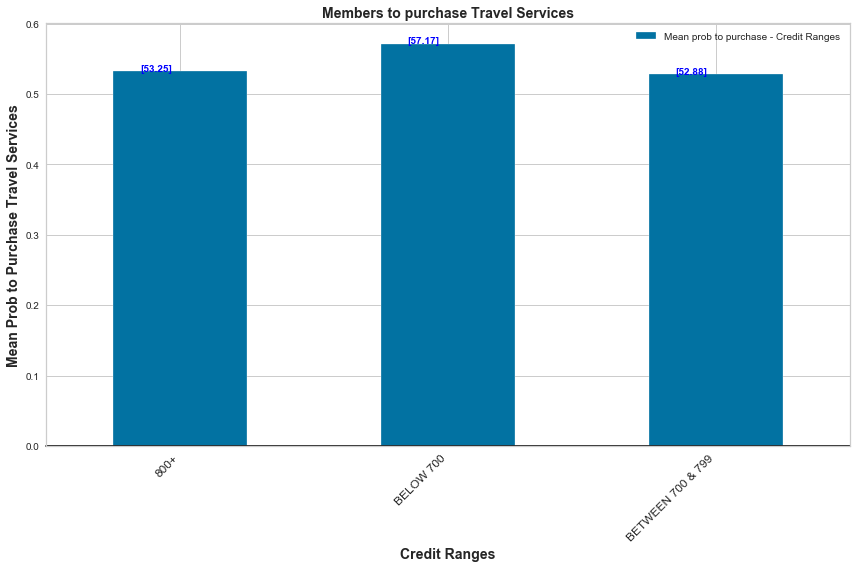

Total Members in  Credit Ranges  :  36
Mean Proba in  Credit Ranges  :  0.5443055555555556
BETWEEN 700 & 799    22
800+                  8
BELOW 700             6
Name: credit_ranges, dtype: int64


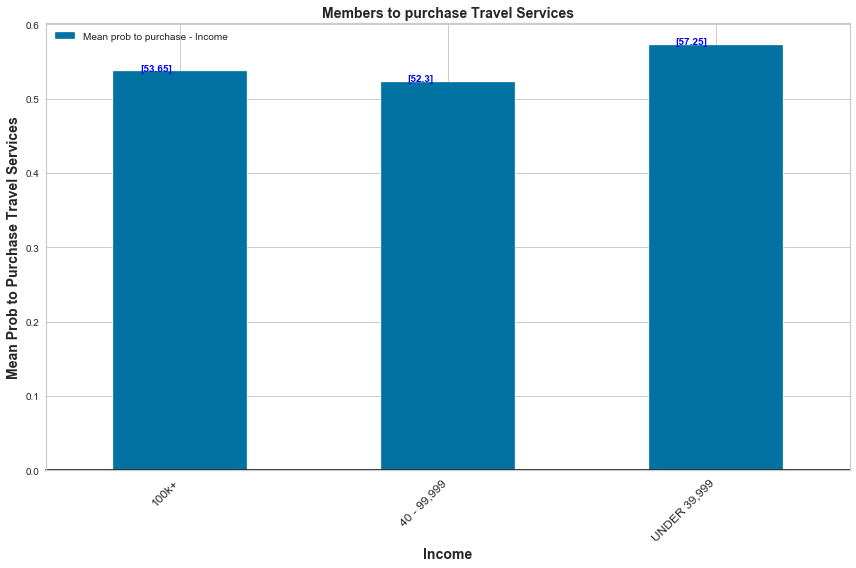

Total Members in  Income  :  35
Mean Proba in  Income  :  0.5439848484848485
100k+           20
40 - 99,999     11
UNDER 39,999     4
Name: income, dtype: int64


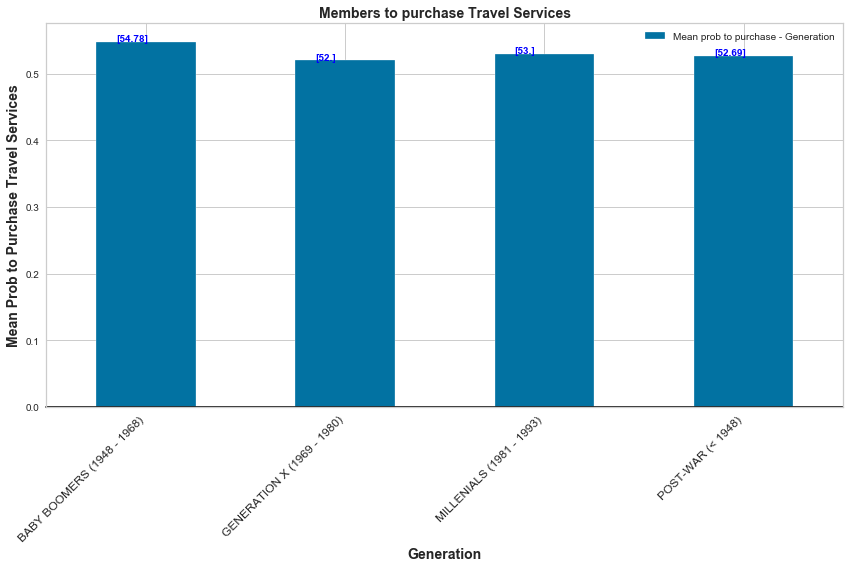

Total Members in  Generation  :  48
Mean Proba in  Generation  :  0.5311752136752137
POST-WAR (< 1948)             26
BABY BOOMERS (1948 - 1968)    18
GENERATION X (1969 - 1980)     3
MILLENIALS (1981 - 1993)       1
Name: generation, dtype: int64


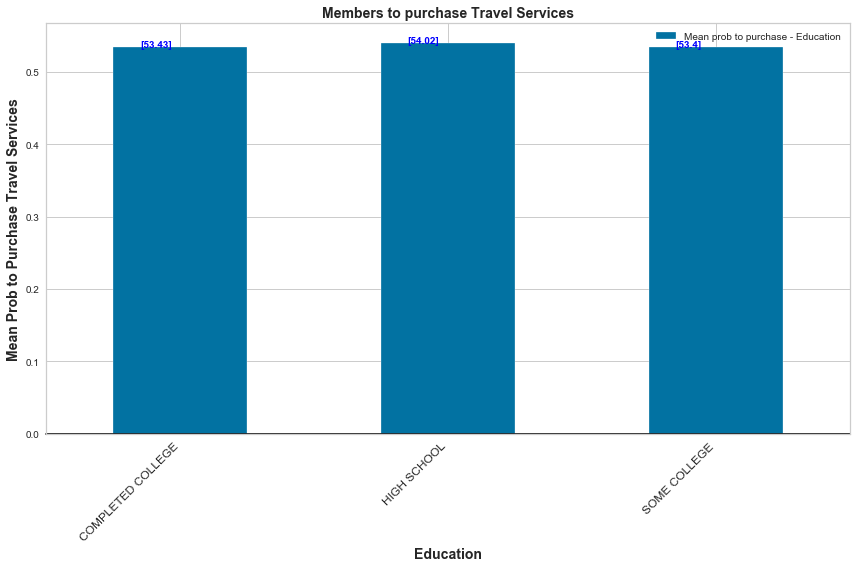

Total Members in  Education  :  28
Mean Proba in  Education  :  0.5361709956709956
HIGH SCHOOL          11
SOME COLLEGE         10
COMPLETED COLLEGE     7
Name: education, dtype: int64


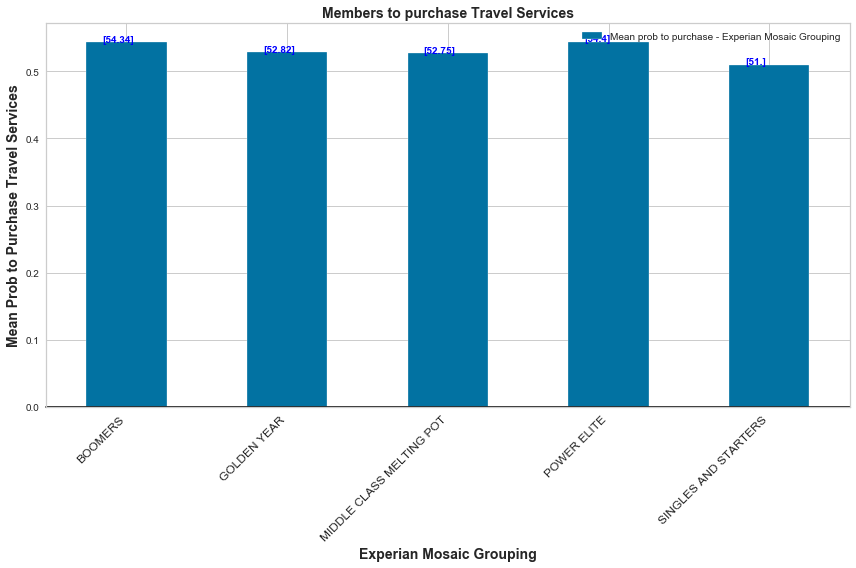

Total Members in  Experian Mosaic Grouping  :  41
Mean Proba in  Experian Mosaic Grouping  :  0.5306303571428572
BOOMERS                     24
GOLDEN YEAR                  7
POWER ELITE                  5
MIDDLE CLASS MELTING POT     4
SINGLES AND STARTERS         1
Name: kcl_b_ind_mosaicsgrouping, dtype: int64


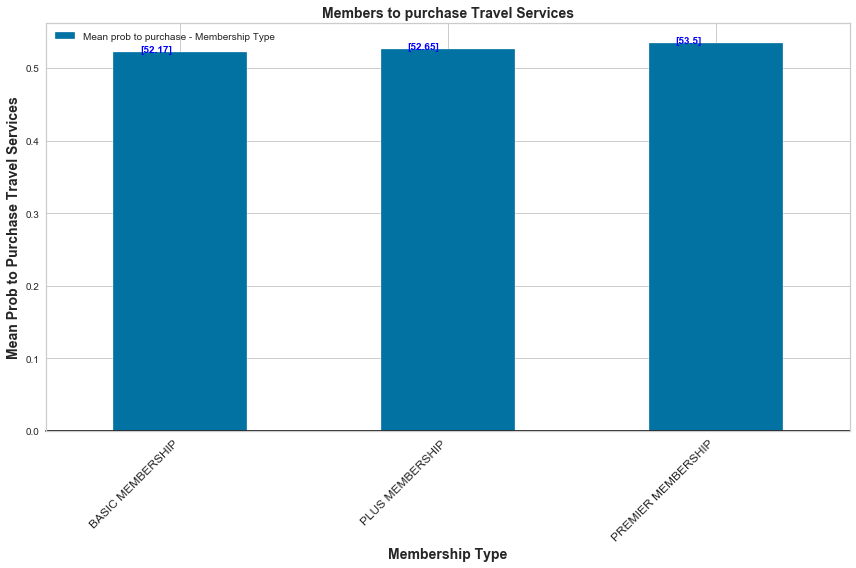

Total Members in  Membership Type  :  29
Mean Proba in  Membership Type  :  0.5277124183006535
PLUS MEMBERSHIP       17
PREMIER MEMBERSHIP     6
BASIC MEMBERSHIP       6
Name: plus_indicator_description, dtype: int64


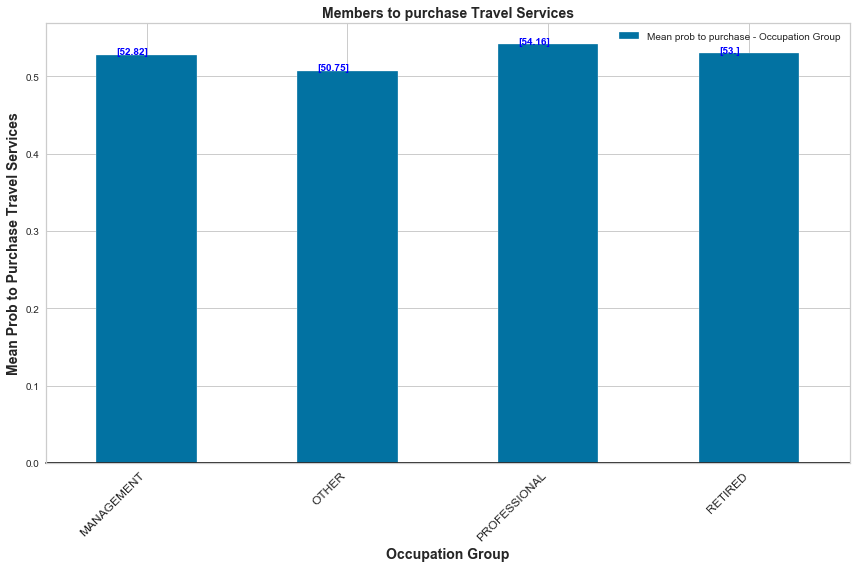

Total Members in  Occupation Group  :  41
Mean Proba in  Occupation Group  :  0.5268139730639732
PROFESSIONAL    27
MANAGEMENT      11
RETIRED          2
OTHER            1
Name: occupation_group, dtype: int64


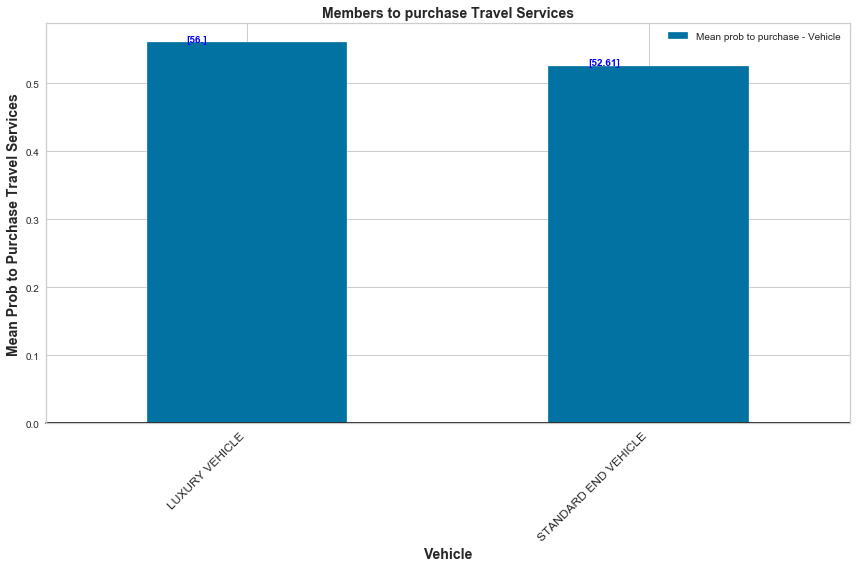

Total Members in  Vehicle  :  29
Mean Proba in  Vehicle  :  0.5430357142857143
STANDARD END VEHICLE    28
LUXURY VEHICLE           1
Name: sc_vehicle_manufacturer_name, dtype: int64


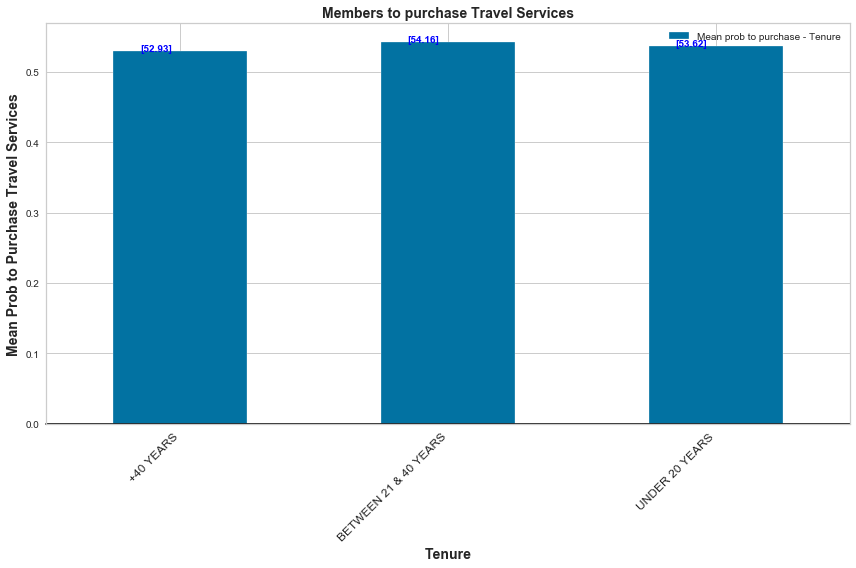

Total Members in  Tenure  :  49
Mean Proba in  Tenure  :  0.5357128267973857
+40 YEARS                24
BETWEEN 21 & 40 YEARS    17
UNDER 20 YEARS            8
Name: tenure, dtype: int64


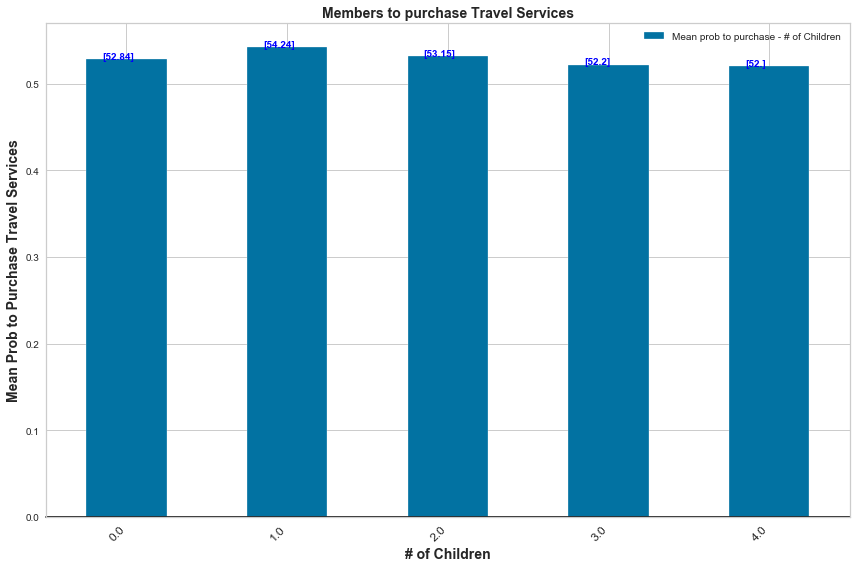

Total Members in  # of Children  :  49
Mean Proba in  # of Children  :  0.5288724650349651
1.0000    22
2.0000    13
0.0000     8
3.0000     5
4.0000     1
Name: aaa_mean_child, dtype: int64


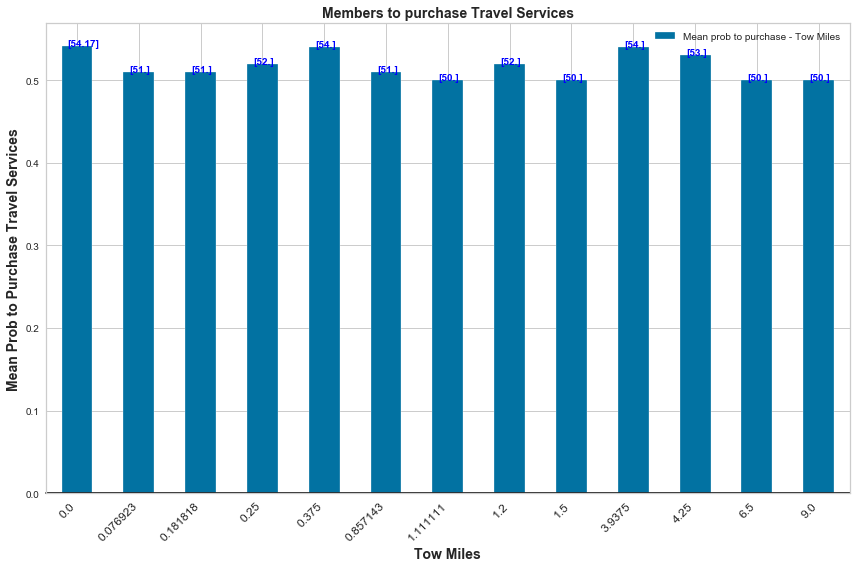

Total Members in  Tow Miles  :  49
Mean Proba in  Tow Miles  :  0.5170549450549451
0.0000    35
0.2500     2
0.3750     2
1.2000     1
0.8571     1
0.1818     1
0.0769     1
1.1111     1
6.5000     1
1.5000     1
3.9375     1
4.2500     1
9.0000     1
Name: mean_tow_miles, dtype: int64


In [575]:
columns=['credit_ranges', 'income', 'generation', 'education', 'kcl_b_ind_mosaicsgrouping',
         'plus_indicator_description', 'occupation_group', 'sc_vehicle_manufacturer_name',
         'tenure', 'aaa_mean_child', 'mean_tow_miles'
        ]

dict_col={'credit_ranges':'Credit Ranges', 'income':'Income', 'generation':'Generation', 'education':'Education',
         'plus_indicator_description':'Membership Type', 'occupation_group':'Occupation Group', 'sc_vehicle_manufacturer_name':'Vehicle',
         'tenure':'Tenure','no_members':'Members in Household', 'aaa_mean_child':'# of Children', 'gender':'gender',
          'kcl_b_ind_mosaicsgrouping':'Experian Mosaic Grouping', 'mean_tow_miles':'Tow Miles'
         }
for col in columns:
    df_use = pd.DataFrame(df_household, columns=['yes_travel','will_cancel_prob', col])
    df_use = df_use[(df_use.will_cancel_prob !=1)]
    df_use = df_use[(df_use.yes_travel !=1)]
    df_use = df_use[(df_use[col] !='UNKNOWN')]
    df_use.drop('will_cancel_prob', axis=1, inplace=True)
    threshold = 0.5
    df_use = df_use[(df_use.yes_travel >= threshold)]
    counts = df_use.groupby(col).mean()
    df_use.groupby(col).mean().plot(kind='bar')
    plt.legend(['Mean prob to purchase - '+dict_col[col]] , loc='best')
    plt.axhline(0, color="k", clip_on=False)
    plt.ylabel("Mean Prob to Purchase Travel Services",fontsize=14, fontweight='bold')
    plt.xlabel(dict_col[col], fontsize=14, fontweight='bold')
    plt.title('Members to purchase Travel Services',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='large')
    i = 0
    for v in list(counts.values):
        plt.text(i-.15, v, str(np.round(v*100,2)), color='blue', fontweight='bold')
        i +=1
    plt.show()
    print('Total Members in ', dict_col[col], ' : ', df_use.shape[0])
    print('Mean Proba in ', dict_col[col],' : ', np.mean(counts.values))
    print(df_use[col].value_counts())

In [546]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 153 to 543695
Data columns (total 98 columns):
household_key                        2937 non-null int64
income                               2937 non-null object
member_status                        2937 non-null object
state_grouped                        2937 non-null object
credit_ranges                        2937 non-null object
cancel_reason                        2937 non-null object
renew_method                         2937 non-null object
plus_indicator_description           2937 non-null object
zip                                  2937 non-null int64
sc_vehicle_manufacturer_name         2937 non-null object
sc_vehicle_model_name                2937 non-null object
race                                 2937 non-null object
home_owner                           2937 non-null object
education                            2937 non-null object
dwelling_type                        2937 non-null object
gender               

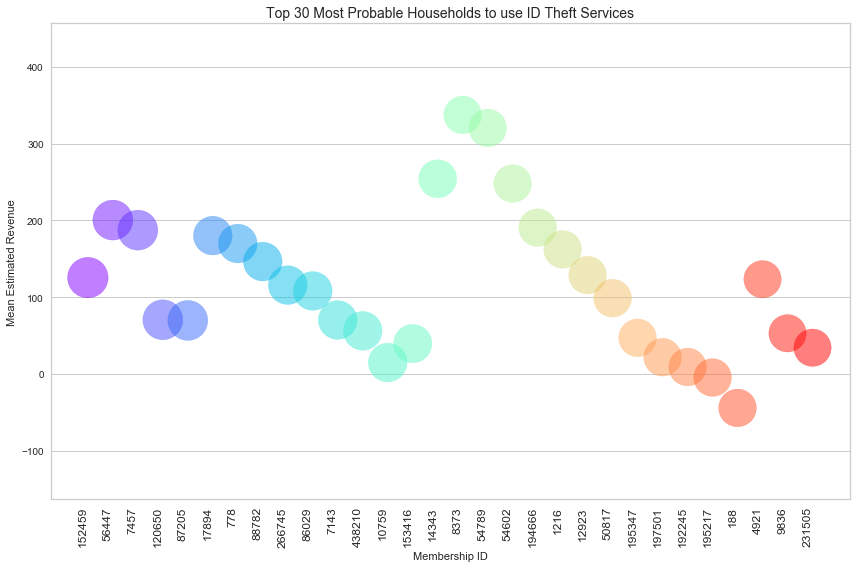

In [578]:
# Graph Time series per household id theft
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_id_theft', 'member_status'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.yes_id_theft != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.sort_values(by=['yes_id_theft', 'mean_estimated_revenue'], ascending=False).head(30)
top_members['membership_id'] = top_members.index.astype(str)
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
plt.scatter(x=top_members.membership_id, y=top_members['mean_estimated_revenue'], 
            s=top_members['yes_id_theft']*2500, alpha=0.5, c=colors)
plt.ylabel("Mean Estimated Revenue")
plt.xlabel("Membership ID")
plt.title("Top 30 Most Probable Households to use ID Theft Services", loc="center")
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
bottom, top = plt.ylim()
plt.grid(which='major', axis='x')
plt.ylim(bottom - 100, top + 100)
plt.show()

In [579]:
top_members

mean_total_member_cost  mean_total_cost  yes_id_theft member_status  mean_estimated_revenue membership_id
membership_id                                                                                                           
152459                       167.6400          42.1550        0.6600        ACTIVE                125.4850        152459
56447                        234.7500          34.3300        0.6400        ACTIVE                200.4200         56447
7457                         235.4000          48.0667        0.6400        ACTIVE                187.3333          7457
120650                       117.7000          47.1063        0.6400        ACTIVE                 70.5938        120650
87205                        118.6538          48.9000        0.6400        ACTIVE                 69.7538         87205
17894                        217.3600          37.1700        0.6000        ACTIVE                180.1900         17894
778                          223.7000          53.8357        0.6000        ACTIVE                169.8643           778
88782                        179.9000          33.5389        0.6000        ACTIVE                146.3611         88782
266745                       143.8462          28.1154        0.6000       PENDING                115.7308        266745
86029                        157.1062          48.9438        0.6000        ACTIVE                108.1625         86029
7143                         100.5667          30.2833        0.6000        ACTIVE                 70.2833          7143
438210                       104.6222          48.4111        0.6000        ACTIVE                 56.2111        438210
10759                         50.2333          35.3083        0.6000        ACTIVE                 14.9250         10759
153416                        93.4329          53.8357        0.5900       PENDING                 39.5971        153416
14343                        305.0571          50.8429        0.5800        ACTIVE                254.2143         14343
8373                         388.6500          51.2900        0.5700        ACTIVE                337.3600          8373
54789                        355.7143          35.4286        0.5700        ACTIVE                320.2857         54789
54602                        288.8400          40.8130        0.5700       PENDING                248.0270         54602
194666                       229.8500          39.2700        0.5700        ACTIVE                190.5800        194666
1216                         206.1500          43.8615        0.5700        ACTIVE                162.2885          1216
12923                        173.7000          44.9786        0.5700        ACTIVE                128.7214         12923
50817                        151.3286          52.6286        0.5700        ACTIVE                 98.7000         50817
195347                        69.8000          22.7500        0.5700        ACTIVE                 47.0500        195347
197501                        60.4633          38.5900        0.5700        ACTIVE                 21.8733        197501
192245                        60.6800          51.5520        0.5700        ACTIVE                  9.1280        192245
195217                        12.0000          16.6000        0.5700        ACTIVE                 -4.6000        195217
188                            9.8083          53.9750        0.5700        ACTIVE                -44.1667           188
4921                         152.5000          29.1000        0.5600        ACTIVE                123.4000          4921
9836                         111.8500          58.8500        0.5600        ACTIVE                 53.0000          9836
231505                        53.7500          19.5000        0.5600        ACTIVE                 34.2500        231505

In [313]:
df_ts = pd.DataFrame(df_household, columns=['total_member_cost','total_cost','yes_id_theft', 
                                            'member_status'])
df_ts['estimated_revenue'] = df_ts['total_member_cost'] - df_ts['total_cost']
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts = df_ts[(df_ts.yes_id_theft != 1)]
threshold = 0.0
df_ts = df_ts[(df_ts.yes_id_theft >= threshold)]
df_ts.estimated_revenue.sum(), df_ts.estimated_revenue.count()
df_ts.groupby(pd.qcut(df_ts.yes_id_theft, 5))['yes_id_theft'].count()

yes_id_theft
(0.019, 0.19]    616
(0.19, 0.25]     522
(0.25, 0.32]     586
(0.32, 0.35]     482
(0.35, 0.66]     540
Name: yes_id_theft, dtype: int64

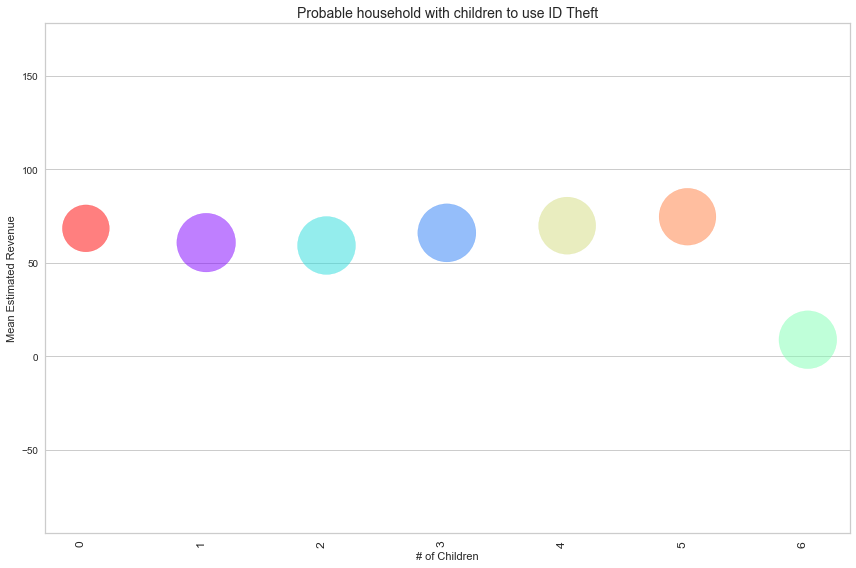

In [589]:
# Graph Time series per household id theft
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_id_theft', 
                                            'aaa_mean_child', 'member_status'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.member_status != 'CANCELLED')]
t_membership_id = t_membership_id[(t_membership_id.yes_id_theft != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.groupby(by='aaa_mean_child').mean()
top_members = top_members.nlargest(30, columns=['yes_id_theft','mean_estimated_revenue'])
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
plt.scatter(x=top_members.index, y=top_members['mean_estimated_revenue'], 
            s=top_members['yes_id_theft']*10000, alpha=0.5, c=colors)
plt.ylabel("Mean Estimated Revenue")
plt.xlabel("# of Children")
plt.title("Probable household with children to use ID Theft", loc="center")
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
bottom, top = plt.ylim()
plt.grid(which='major', axis='x')
plt.ylim(bottom - 100, top + 100)
plt.show()

In [588]:
top_members

mean_total_member_cost  mean_total_cost  yes_id_theft  mean_estimated_revenue
aaa_auto_insurance                                                                               
0                                  92.8375          33.4139        0.3308                 59.4236
1                                 103.3760          34.6470        0.3083                 68.7290

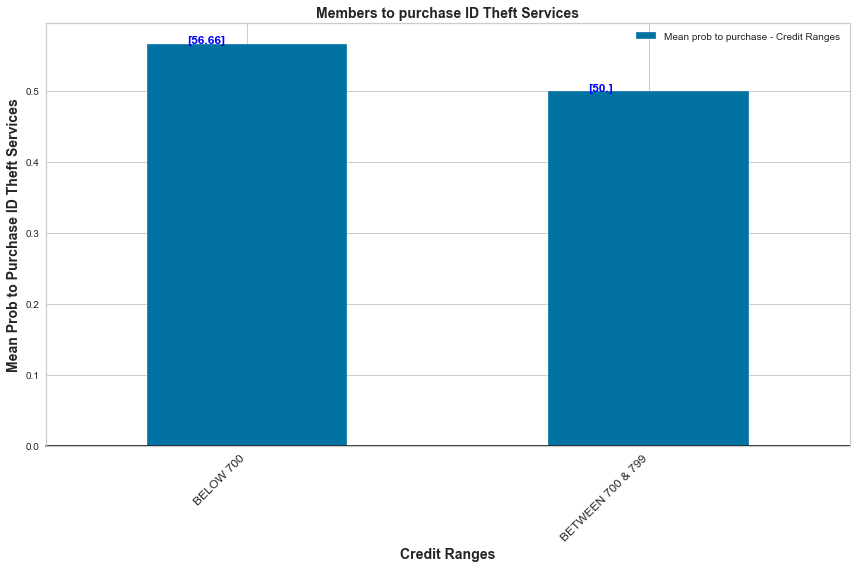

Total Members in  Credit Ranges  :  63
Mean Proba in  Credit Ranges  :  0.5333064516129031
BELOW 700            62
BETWEEN 700 & 799     1
Name: credit_ranges, dtype: int64


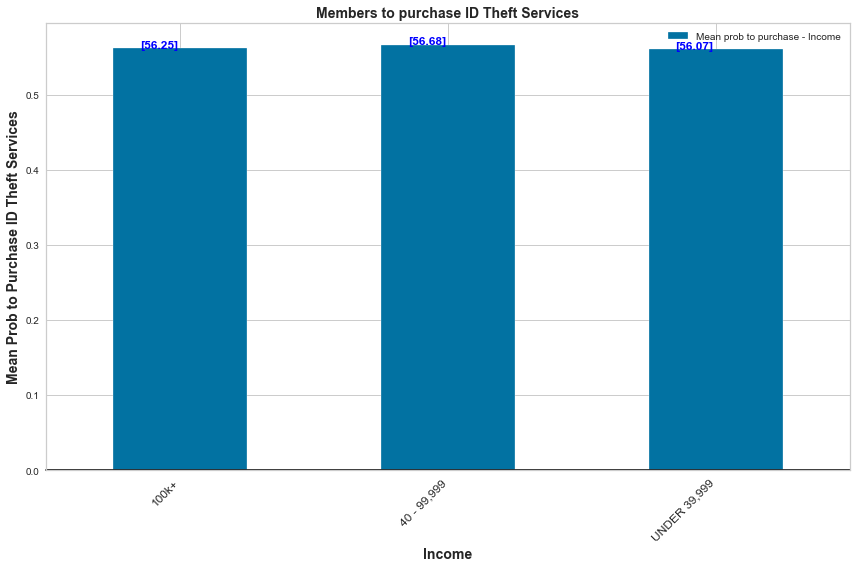

Total Members in  Income  :  64
Mean Proba in  Income  :  0.5633078078078078
40 - 99,999     37
UNDER 39,999    15
100k+           12
Name: income, dtype: int64


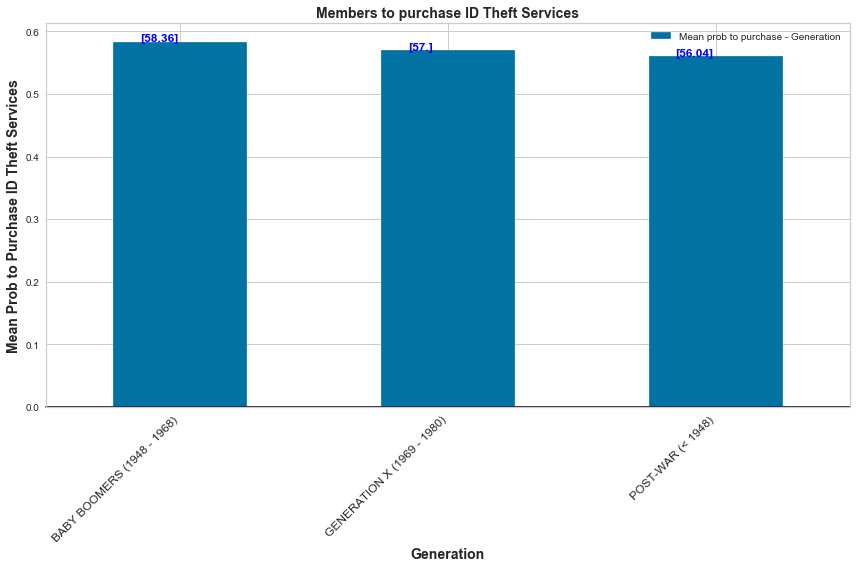

Total Members in  Generation  :  64
Mean Proba in  Generation  :  0.5713403263403264
POST-WAR (< 1948)             52
BABY BOOMERS (1948 - 1968)    11
GENERATION X (1969 - 1980)     1
Name: generation, dtype: int64


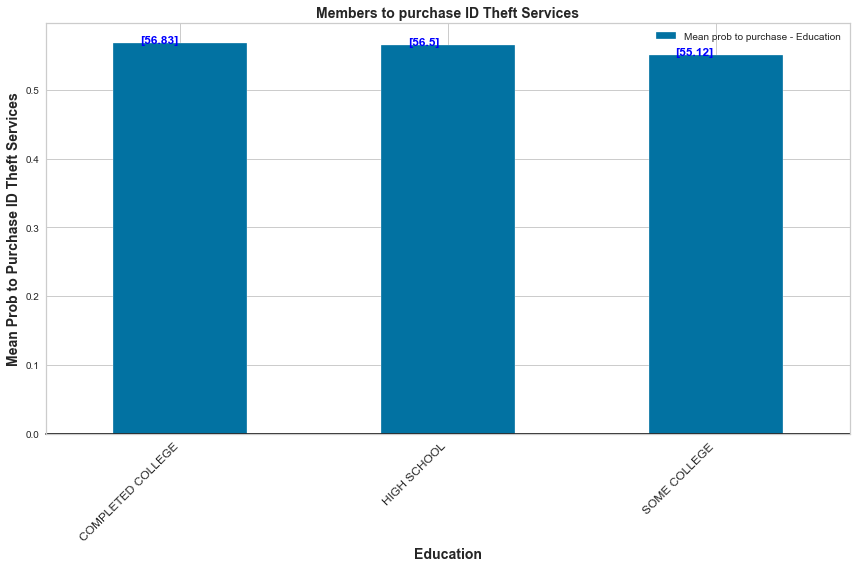

Total Members in  Education  :  47
Mean Proba in  Education  :  0.5615032679738562
HIGH SCHOOL          24
SOME COLLEGE         17
COMPLETED COLLEGE     6
Name: education, dtype: int64


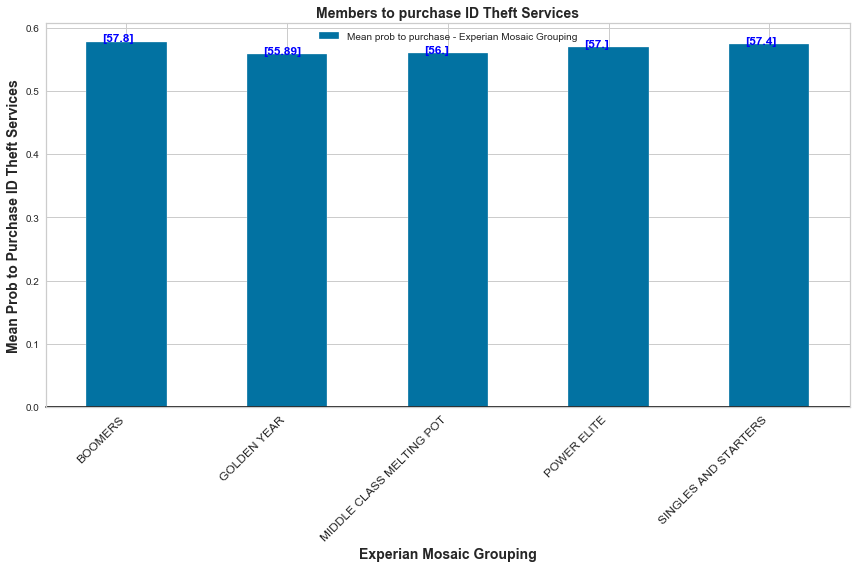

Total Members in  Experian Mosaic Grouping  :  61
Mean Proba in  Experian Mosaic Grouping  :  0.5681714285714285
GOLDEN YEAR                 35
BOOMERS                     15
SINGLES AND STARTERS         5
MIDDLE CLASS MELTING POT     4
POWER ELITE                  2
Name: kcl_b_ind_mosaicsgrouping, dtype: int64


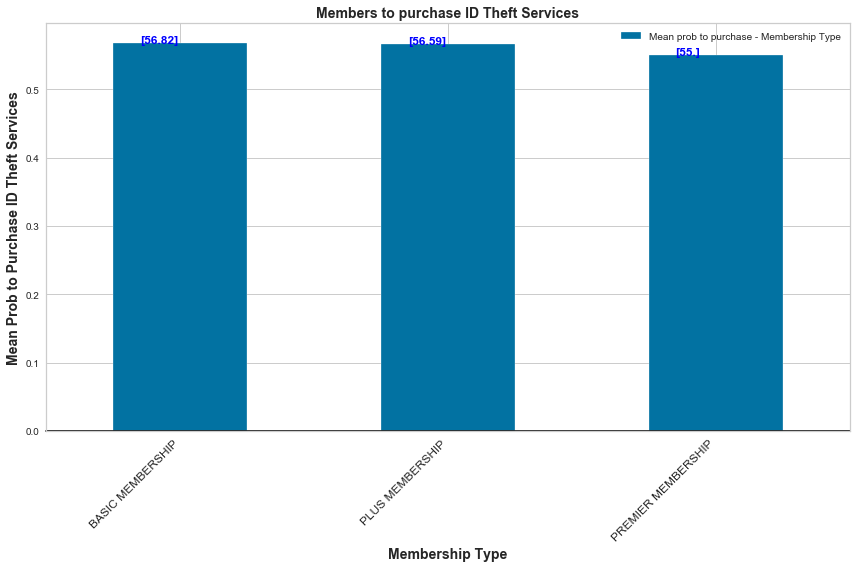

Total Members in  Membership Type  :  53
Mean Proba in  Membership Type  :  0.5613725490196079
BASIC MEMBERSHIP      34
PLUS MEMBERSHIP       17
PREMIER MEMBERSHIP     2
Name: plus_indicator_description, dtype: int64


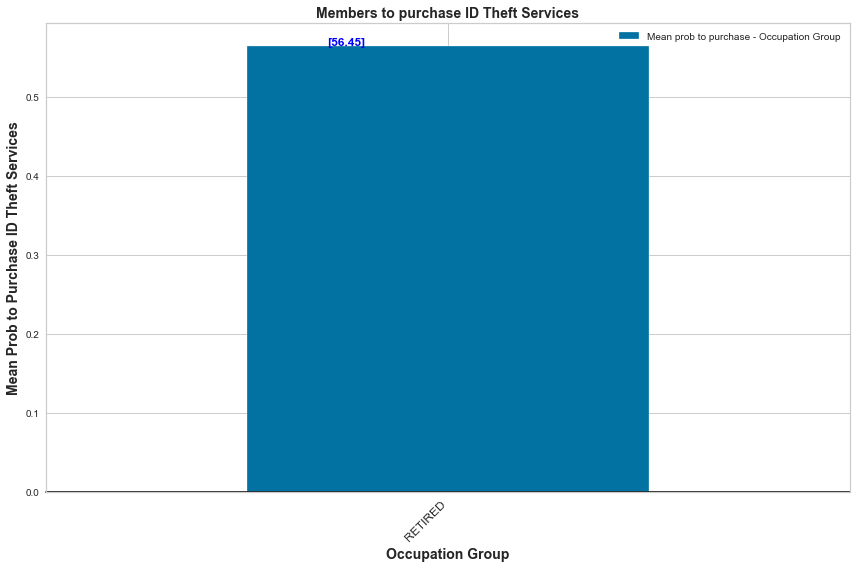

Total Members in  Occupation Group  :  64
Mean Proba in  Occupation Group  :  0.5645312499999999
RETIRED    64
Name: occupation_group, dtype: int64


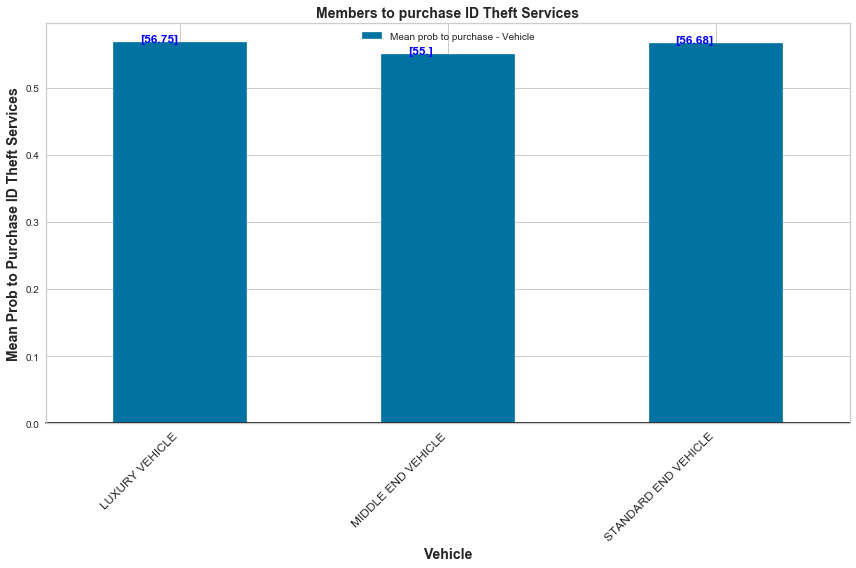

Total Members in  Vehicle  :  51
Mean Proba in  Vehicle  :  0.561439393939394
STANDARD END VEHICLE    44
LUXURY VEHICLE           4
MIDDLE END VEHICLE       3
Name: sc_vehicle_manufacturer_name, dtype: int64


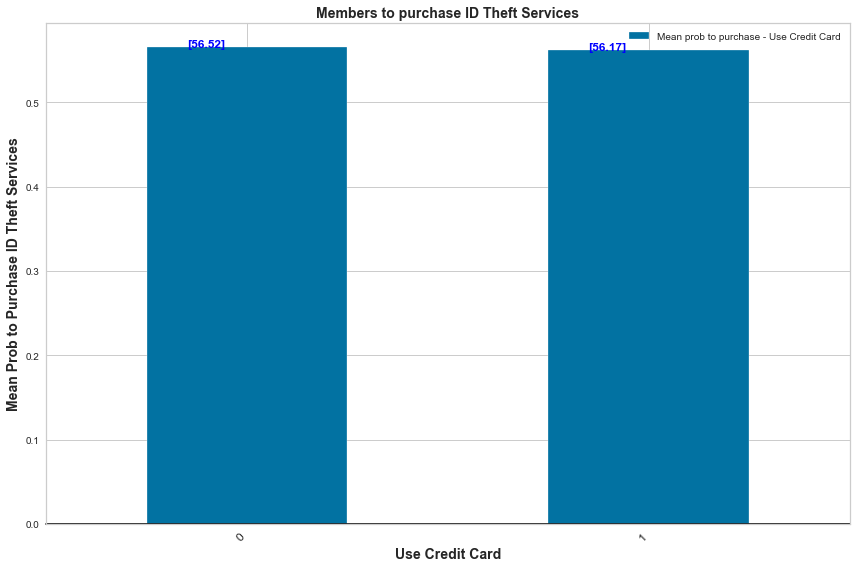

Total Members in  Use Credit Card  :  64
Mean Proba in  Use Credit Card  :  0.5634294871794872
0    52
1    12
Name: aaa_credit_card, dtype: int64


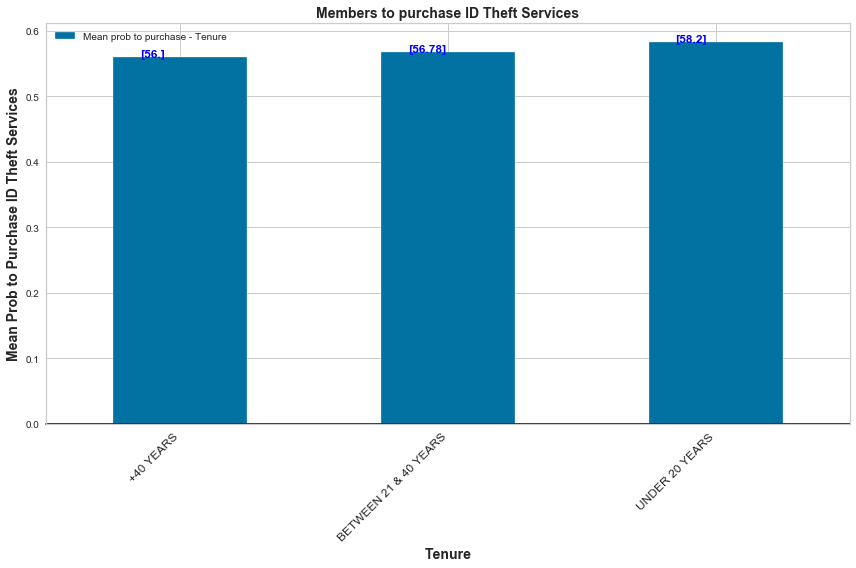

Total Members in  Tenure  :  64
Mean Proba in  Tenure  :  0.5699259259259258
+40 YEARS                45
UNDER 20 YEARS           10
BETWEEN 21 & 40 YEARS     9
Name: tenure, dtype: int64


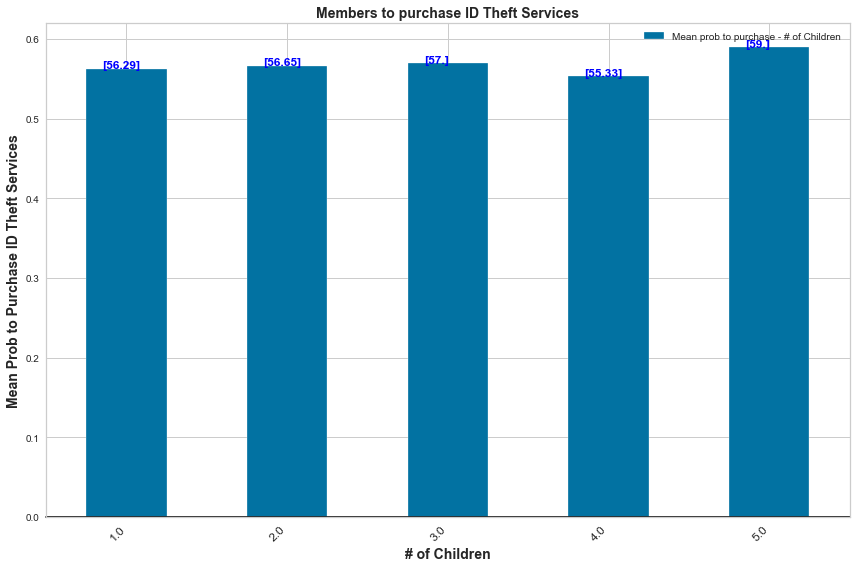

Total Members in  # of Children  :  64
Mean Proba in  # of Children  :  0.5685380952380952
1.0000    35
2.0000    20
3.0000     5
4.0000     3
5.0000     1
Name: aaa_mean_child, dtype: int64


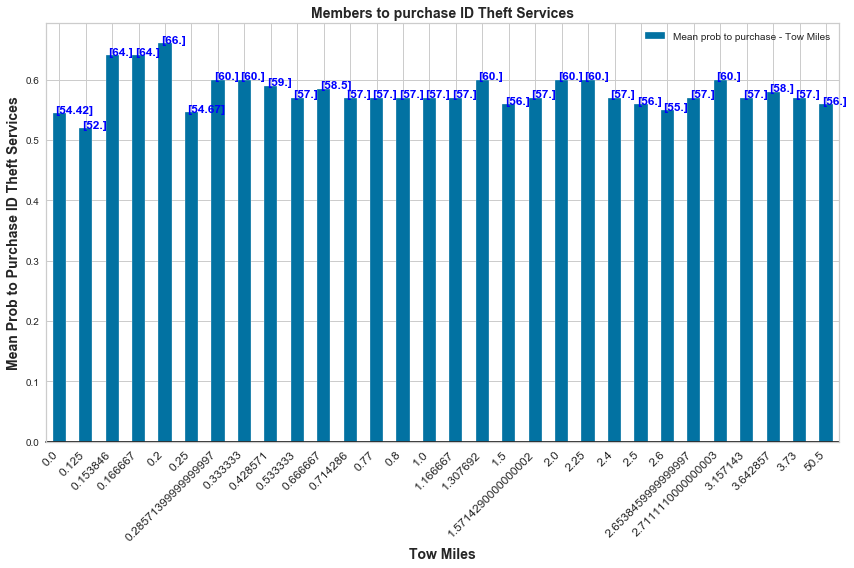

Total Members in  Tow Miles  :  64
Mean Proba in  Tow Miles  :  0.5801965811965811
0.0000     26
1.0000      5
0.2500      3
0.1250      2
0.1667      2
0.6667      2
3.7300      1
2.0000      1
0.7143      1
2.2500      1
0.2857      1
1.5000      1
2.5000      1
50.5000     1
0.7700      1
1.5714      1
3.1571      1
1.1667      1
2.6538      1
0.2000      1
0.1538      1
2.4000      1
2.6000      1
1.3077      1
0.3333      1
0.8000      1
2.7111      1
0.4286      1
0.5333      1
3.6429      1
Name: mean_tow_miles, dtype: int64


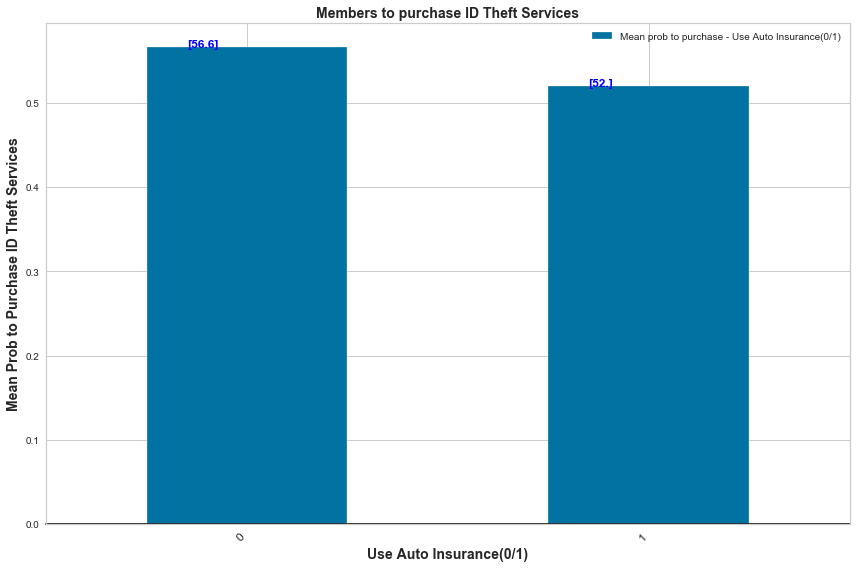

Total Members in  Use Auto Insurance(0/1)  :  64
Mean Proba in  Use Auto Insurance(0/1)  :  0.5429838709677419
0    62
1     2
Name: aaa_auto_insurance, dtype: int64


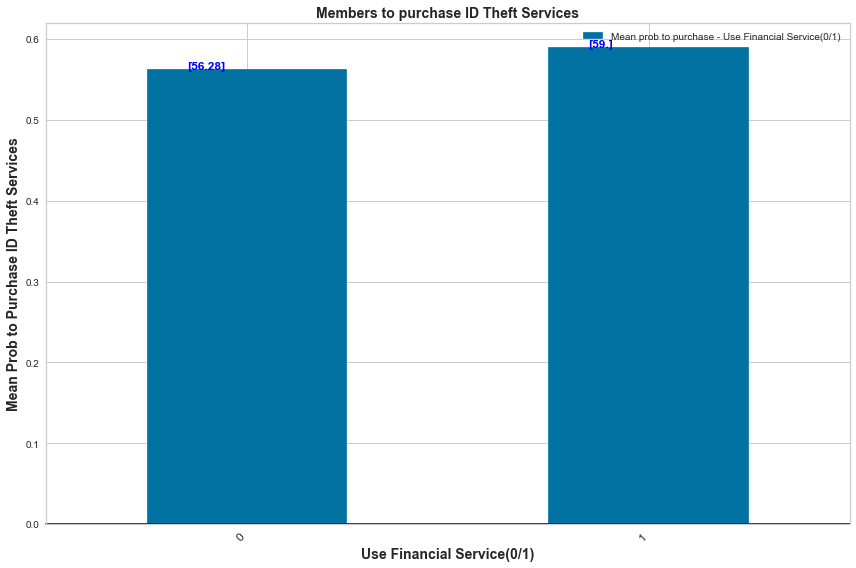

Total Members in  Use Financial Service(0/1)  :  64
Mean Proba in  Use Financial Service(0/1)  :  0.5764166666666667
0    60
1     4
Name: aaa_financial_service, dtype: int64


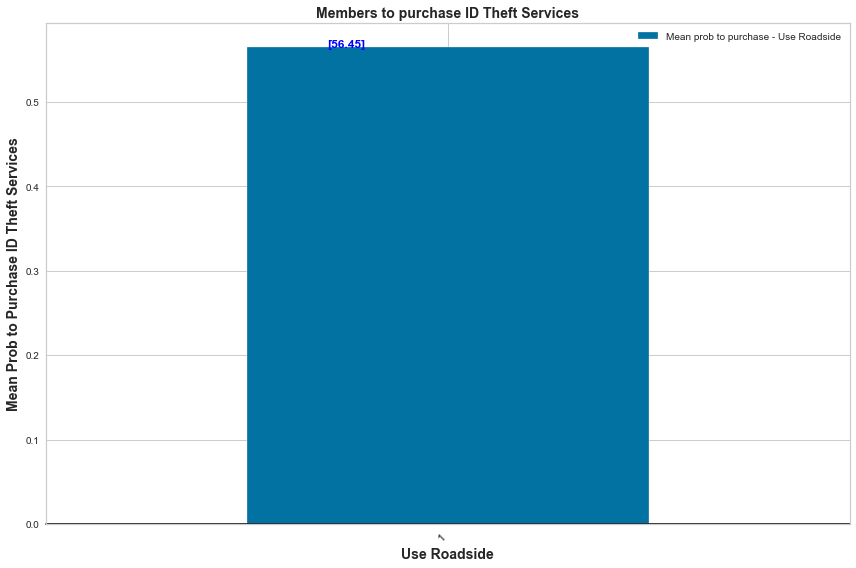

Total Members in  Use Roadside  :  64
Mean Proba in  Use Roadside  :  0.5645312499999999
1    64
Name: use_road_side, dtype: int64


In [595]:
columns=['credit_ranges', 'income', 'generation', 'education', 'kcl_b_ind_mosaicsgrouping',
         'plus_indicator_description', 'occupation_group', 'sc_vehicle_manufacturer_name', 'aaa_credit_card',
         'tenure', 'aaa_mean_child', 'mean_tow_miles', 'aaa_auto_insurance', 'aaa_financial_service',
         'use_road_side'
        ]

dict_col={'credit_ranges':'Credit Ranges', 'income':'Income', 'generation':'Generation', 'education':'Education',
         'plus_indicator_description':'Membership Type', 'occupation_group':'Occupation Group', 'sc_vehicle_manufacturer_name':'Vehicle',
         'tenure':'Tenure','no_members':'Members in Household', 'aaa_mean_child':'# of Children', 'gender':'gender',
          'kcl_b_ind_mosaicsgrouping':'Experian Mosaic Grouping', 'mean_tow_miles':'Tow Miles',
          'aaa_auto_insurance' : 'Use Auto Insurance(0/1)', 'aaa_financial_service':'Use Financial Service(0/1)',
          'use_road_side' : 'Use Roadside', 'aaa_credit_card' : 'Use Credit Card'
         }
for col in columns:
    df_use = pd.DataFrame(df_household, columns=['yes_id_theft','will_cancel_prob', col])
    df_use = df_use[(df_use.will_cancel_prob !=1)]
    df_use = df_use[(df_use.yes_id_theft !=1)]
    df_use = df_use[(df_use[col] !='UNKNOWN')]
    df_use.drop('will_cancel_prob', axis=1, inplace=True)
    threshold = 0.5
    df_use = df_use[(df_use.yes_id_theft >= threshold)]
    counts = df_use.groupby(col).mean()
    df_use.groupby(col).mean().plot(kind='bar')
    plt.legend(['Mean prob to purchase - '+dict_col[col]] , loc='best')
    plt.axhline(0, color="k", clip_on=False)
    plt.ylabel("Mean Prob to Purchase ID Theft Services",fontsize=14, fontweight='bold')
    plt.xlabel(dict_col[col], fontsize=14, fontweight='bold')
    plt.title('Members to purchase ID Theft Services',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='large')
    i = 0
    for v in list(counts.values):
        plt.text(i-.15, v, str(np.round(v*100,2)), color='blue', fontweight='bold', fontsize=12)
        i +=1
    plt.show()
    print('Total Members in ', dict_col[col], ' : ', df_use.shape[0])
    print('Mean Proba in ', dict_col[col],' : ', np.mean(counts.values))
    print(df_use[col].value_counts())

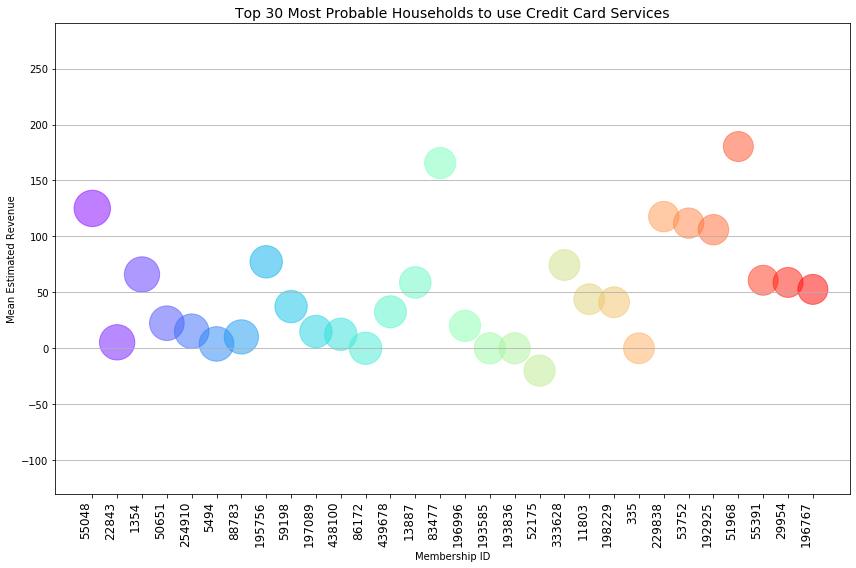

In [11]:
# Graph Time series per household id theft
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_credit_card', 'member_status'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.yes_credit_card != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.sort_values(by=['yes_credit_card', 'mean_estimated_revenue'], ascending=False).head(30)
top_members['membership_id'] = top_members.index.astype(str)
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
plt.scatter(x=top_members.membership_id, y=top_members['mean_estimated_revenue'], 
            s=top_members['yes_credit_card']*2500, alpha=0.5, c=colors)
plt.ylabel("Mean Estimated Revenue")
plt.xlabel("Membership ID")
plt.title("Top 30 Most Probable Households to use Credit Card Services", loc="center")
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
bottom, top = plt.ylim()
plt.grid(which='major', axis='y')
plt.ylim(bottom - 100, top + 100)
plt.show()

In [319]:
df_ts = pd.DataFrame(df_household, columns=['total_member_cost','total_cost','yes_credit_card', 
                                            'member_status'])
df_ts['estimated_revenue'] = df_ts['total_member_cost'] - df_ts['total_cost']
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts = df_ts[(df_ts.yes_credit_card != 1)]
threshold = 0.0
df_ts = df_ts[(df_ts.yes_credit_card >= threshold)]
df_ts.estimated_revenue.sum(), df_ts.estimated_revenue.count()
df_ts.groupby(pd.qcut(df_ts.yes_credit_card, 5))['yes_credit_card'].count()

yes_credit_card
(-0.001, 0.07]    513
(0.07, 0.11]      502
(0.11, 0.16]      542
(0.16, 0.22]      507
(0.22, 0.59]      457
Name: yes_credit_card, dtype: int64

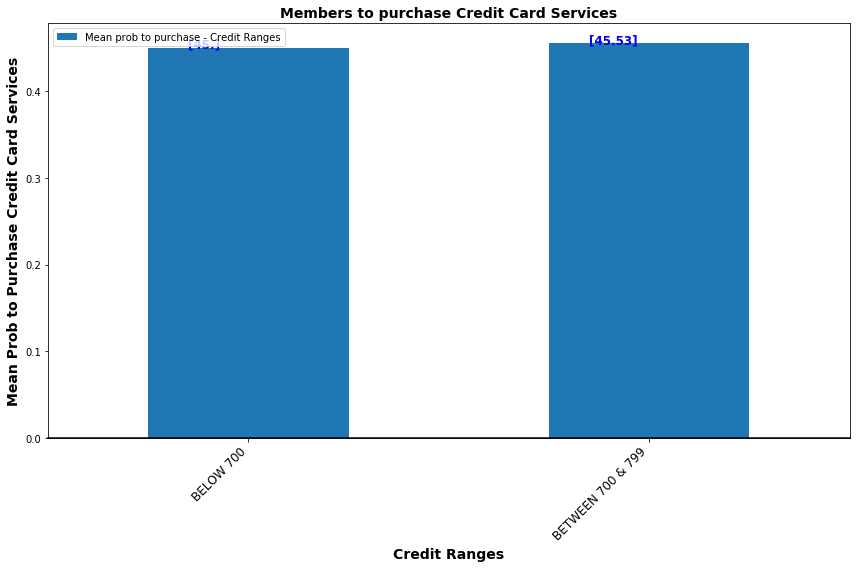

Total Members in  Credit Ranges  :  18
Mean Proba in  Credit Ranges  :  0.4526282051282051
BETWEEN 700 & 799    13
BELOW 700             5
Name: credit_ranges, dtype: int64


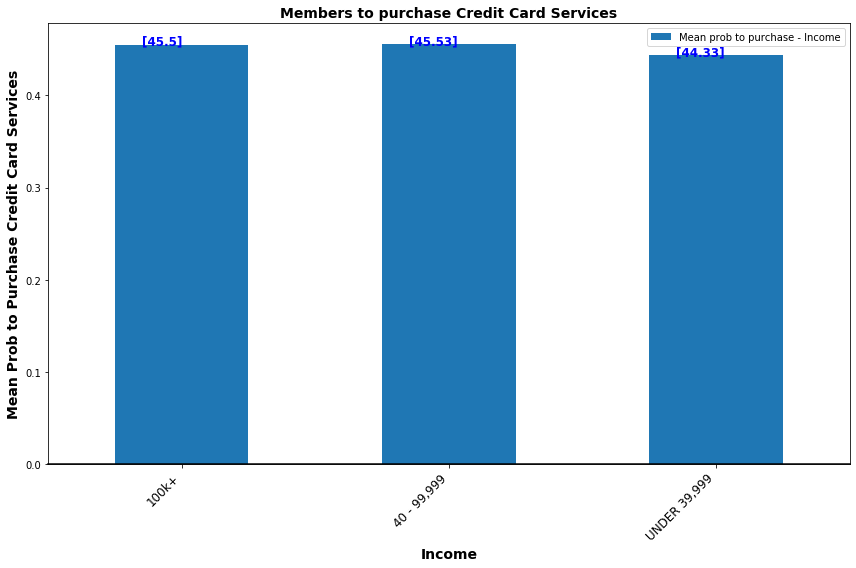

Total Members in  Income  :  20
Mean Proba in  Income  :  0.4511965811965812
40 - 99,999     13
100k+            4
UNDER 39,999     3
Name: income, dtype: int64


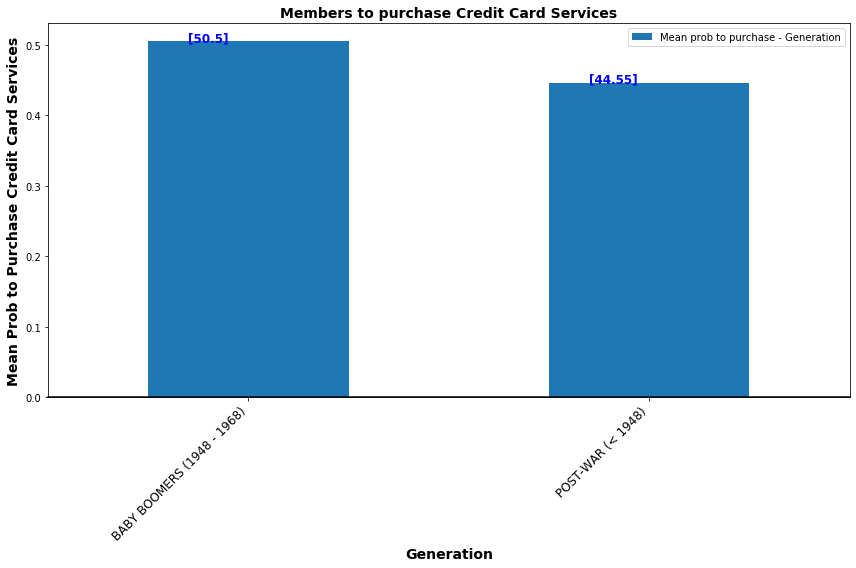

Total Members in  Generation  :  27
Mean Proba in  Generation  :  0.47526666666666667
POST-WAR (< 1948)             25
BABY BOOMERS (1948 - 1968)     2
Name: generation, dtype: int64


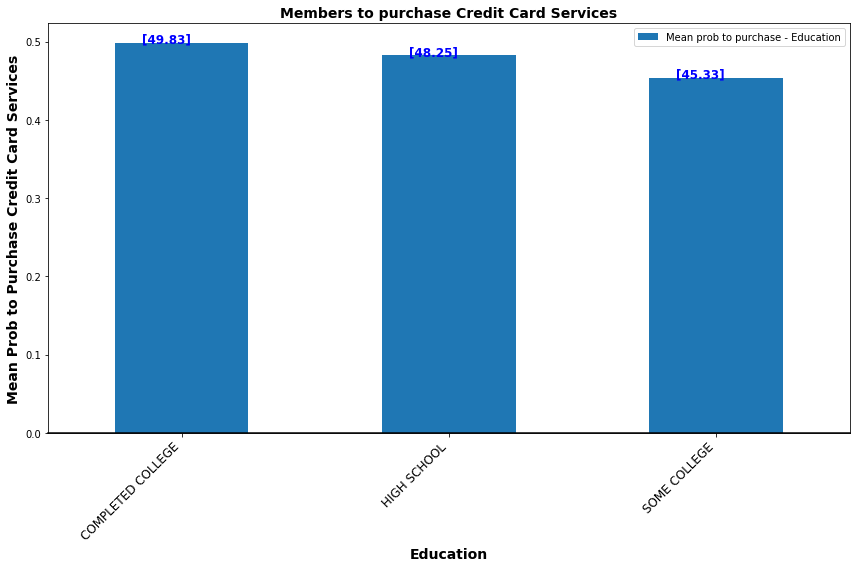

Total Members in  Education  :  11
Mean Proba in  Education  :  0.4780555555555556
SOME COLLEGE         6
HIGH SCHOOL          4
COMPLETED COLLEGE    1
Name: education, dtype: int64


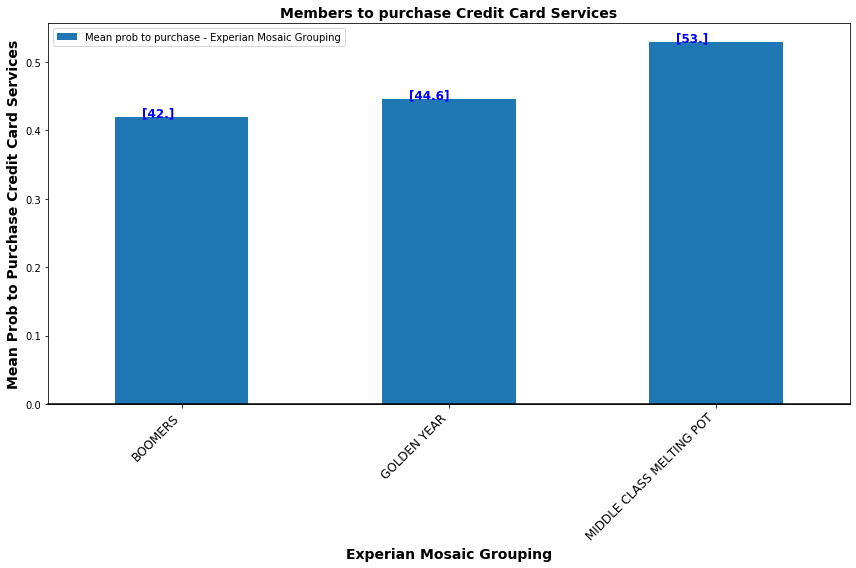

Total Members in  Experian Mosaic Grouping  :  25
Mean Proba in  Experian Mosaic Grouping  :  0.4653381642512078
GOLDEN YEAR                 23
BOOMERS                      1
MIDDLE CLASS MELTING POT     1
Name: kcl_b_ind_mosaicsgrouping, dtype: int64


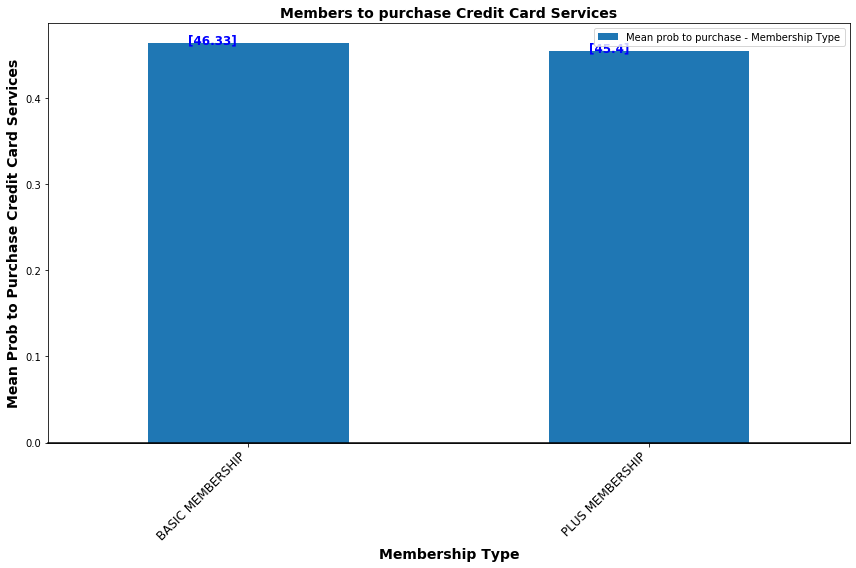

Total Members in  Membership Type  :  8
Mean Proba in  Membership Type  :  0.45866666666666667
PLUS MEMBERSHIP     5
BASIC MEMBERSHIP    3
Name: plus_indicator_description, dtype: int64


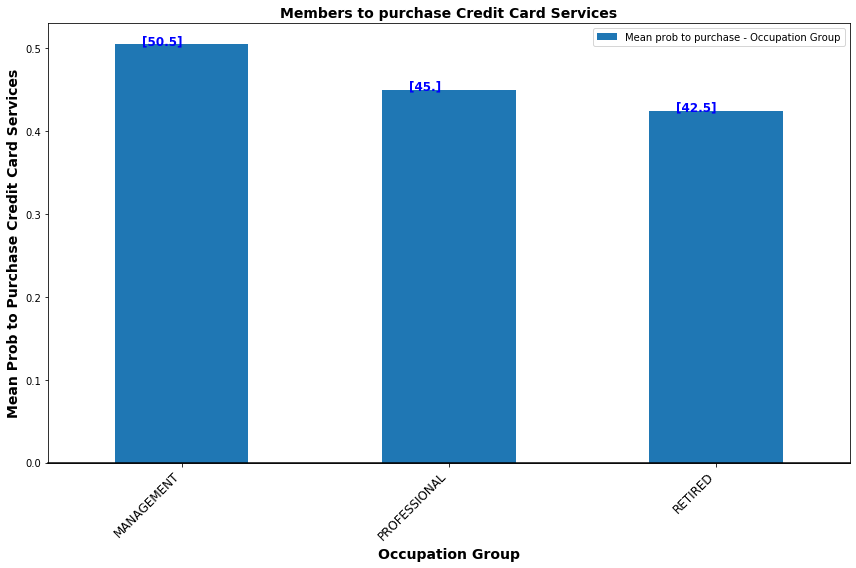

Total Members in  Occupation Group  :  14
Mean Proba in  Occupation Group  :  0.45999999999999996
RETIRED         8
MANAGEMENT      4
PROFESSIONAL    2
Name: occupation_group, dtype: int64


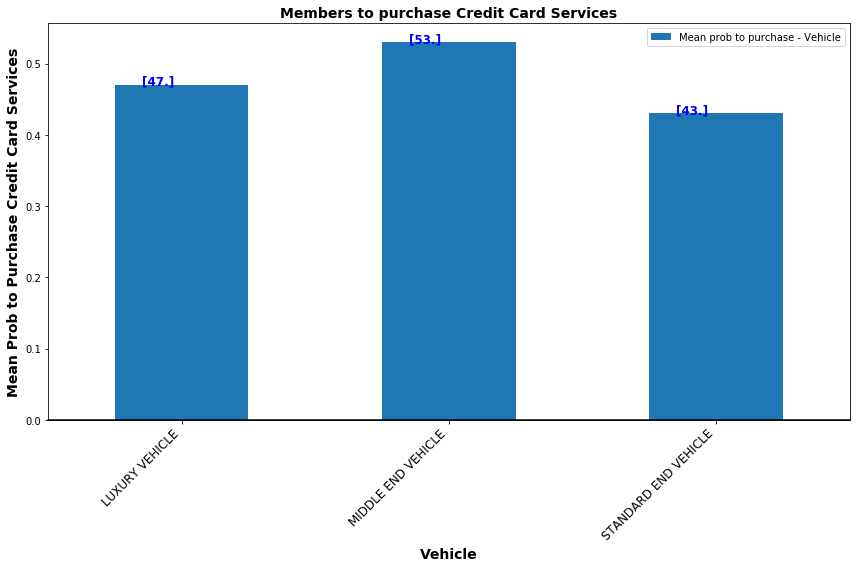

Total Members in  Vehicle  :  8
Mean Proba in  Vehicle  :  0.4766666666666666
STANDARD END VEHICLE    4
LUXURY VEHICLE          3
MIDDLE END VEHICLE      1
Name: sc_vehicle_manufacturer_name, dtype: int64


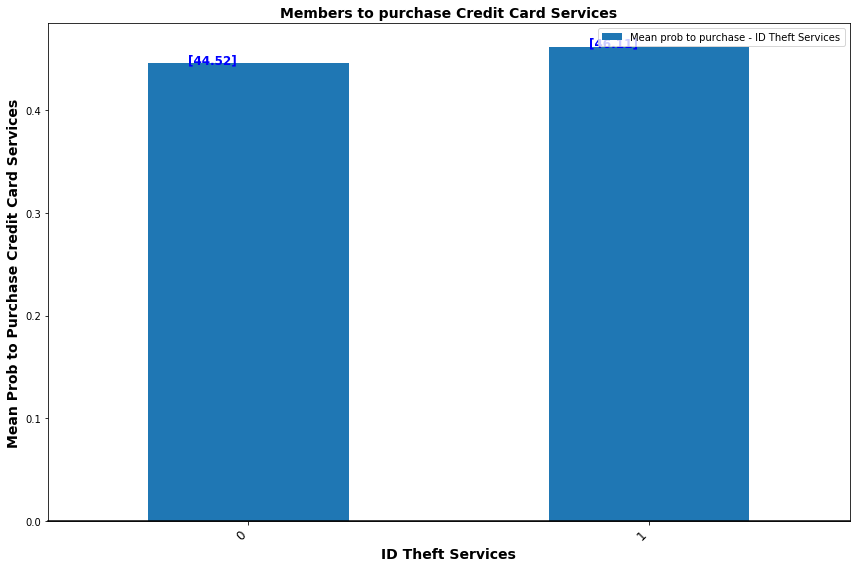

Total Members in  ID Theft Services  :  28
Mean Proba in  ID Theft Services  :  0.4531432748538011
0    19
1     9
Name: aaa_id_theft, dtype: int64


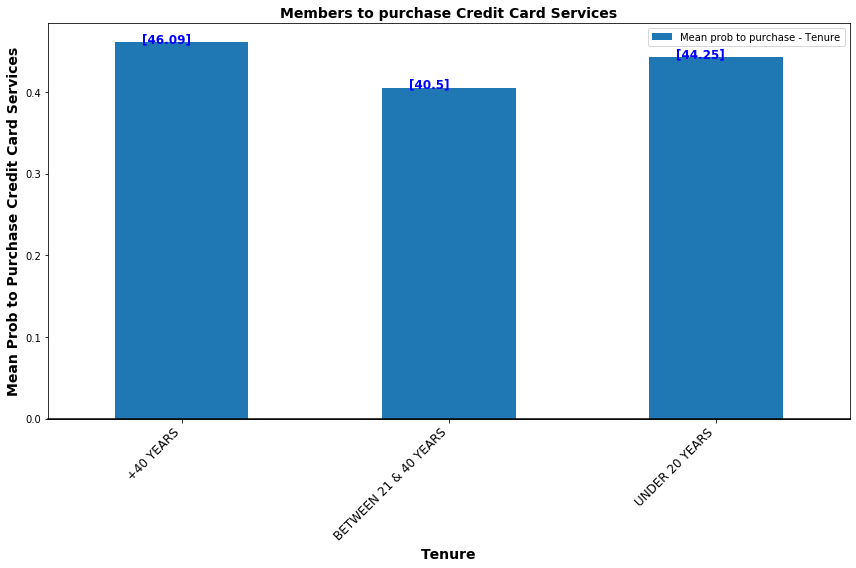

Total Members in  Tenure  :  28
Mean Proba in  Tenure  :  0.43613888888888885
+40 YEARS                20
BETWEEN 21 & 40 YEARS     4
UNDER 20 YEARS            4
Name: tenure, dtype: int64


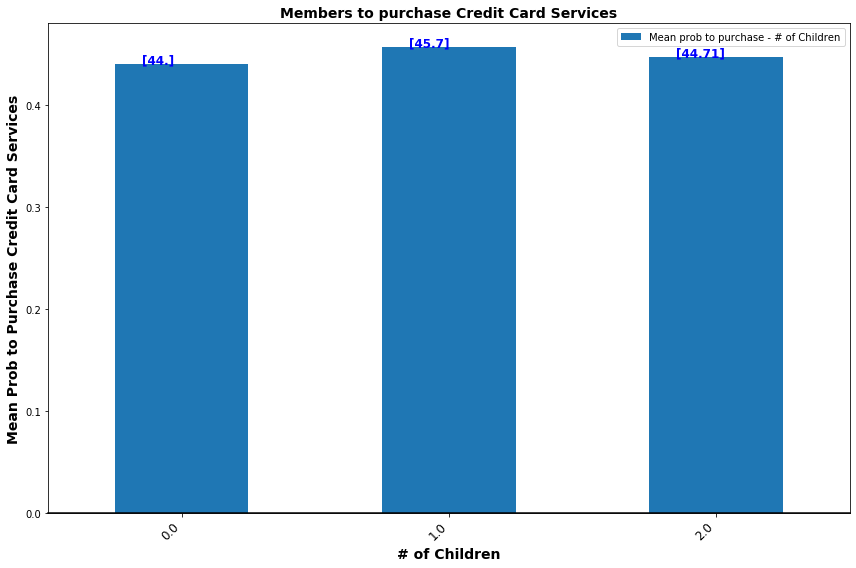

Total Members in  # of Children  :  28
Mean Proba in  # of Children  :  0.4480555555555556
1.0000    14
0.0000     7
2.0000     7
Name: aaa_mean_child, dtype: int64


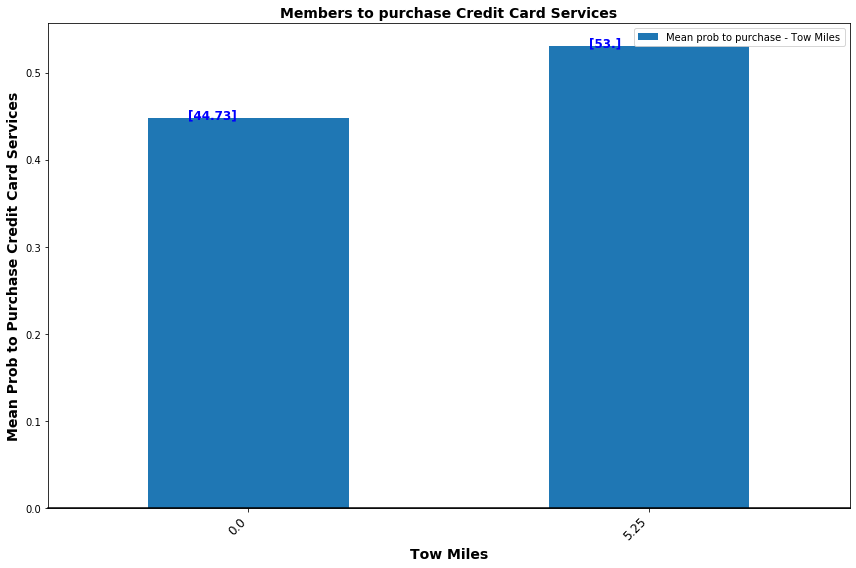

Total Members in  Tow Miles  :  28
Mean Proba in  Tow Miles  :  0.4886728395061729
0.0000    27
5.2500     1
Name: mean_tow_miles, dtype: int64


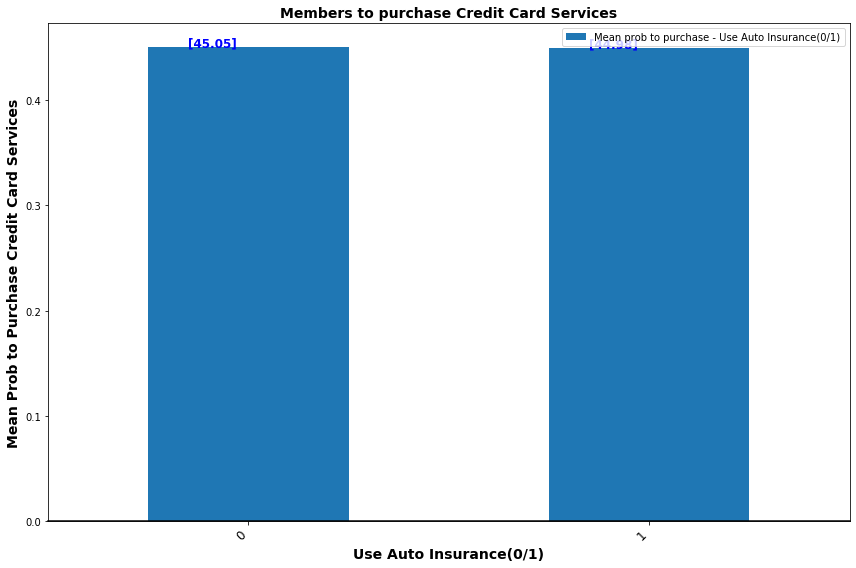

Total Members in  Use Auto Insurance(0/1)  :  28
Mean Proba in  Use Auto Insurance(0/1)  :  0.45014583333333336
0    20
1     8
Name: aaa_auto_insurance, dtype: int64


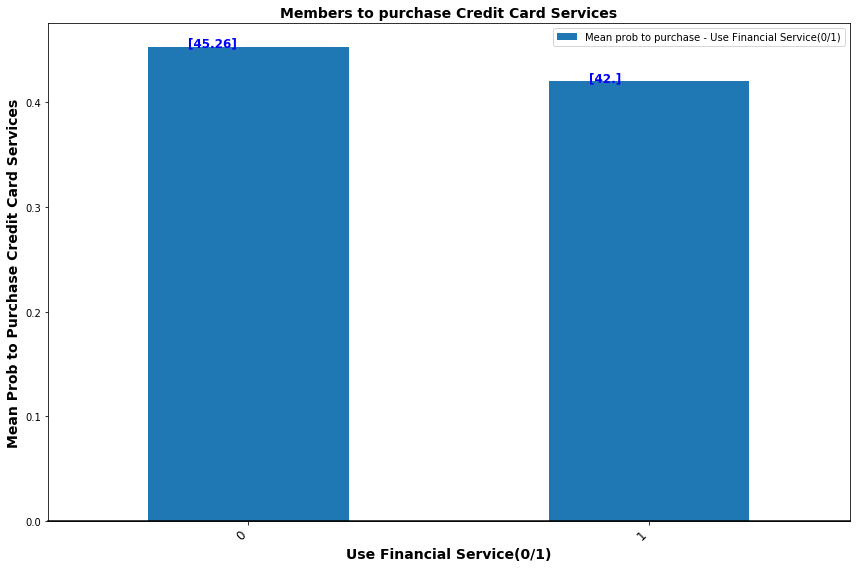

Total Members in  Use Financial Service(0/1)  :  28
Mean Proba in  Use Financial Service(0/1)  :  0.4363141025641026
0    26
1     2
Name: aaa_financial_service, dtype: int64


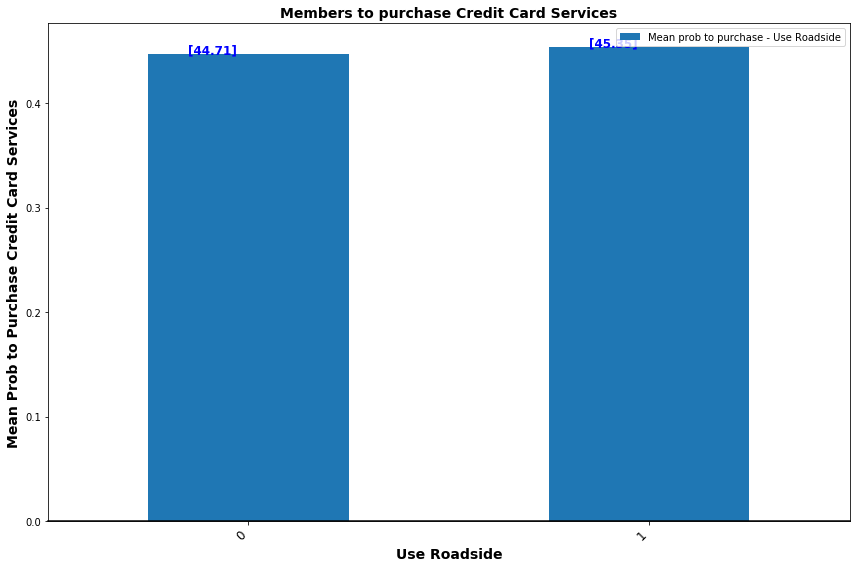

Total Members in  Use Roadside  :  28
Mean Proba in  Use Roadside  :  0.450297619047619
1    14
0    14
Name: use_road_side, dtype: int64


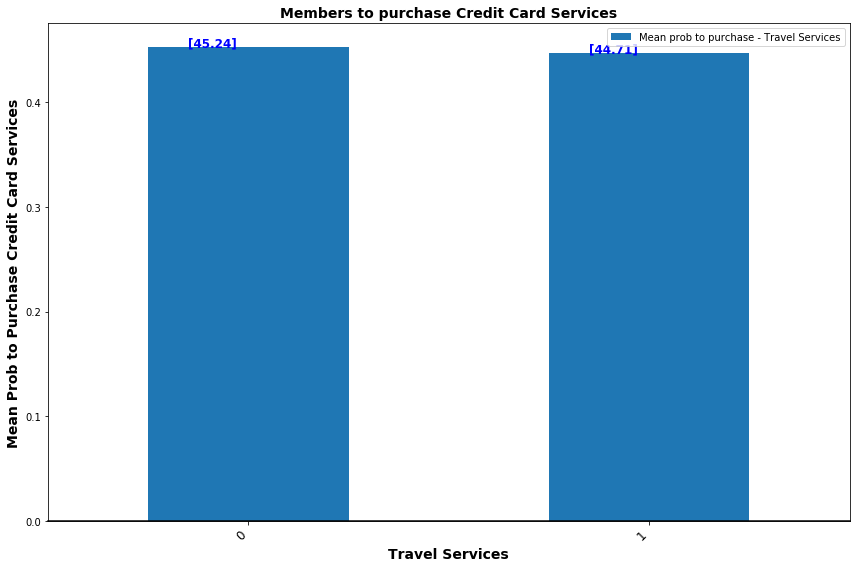

Total Members in  Travel Services  :  28
Mean Proba in  Travel Services  :  0.4497370766488414
0    17
1    11
Name: aaa_travel, dtype: int64


In [23]:
columns=['credit_ranges', 'income', 'generation', 'education', 'kcl_b_ind_mosaicsgrouping',
         'plus_indicator_description', 'occupation_group', 'sc_vehicle_manufacturer_name', 'aaa_id_theft',
         'tenure', 'aaa_mean_child', 'mean_tow_miles', 'aaa_auto_insurance', 'aaa_financial_service',
         'use_road_side', 'aaa_travel'
        ]

dict_col={'credit_ranges':'Credit Ranges', 'income':'Income', 'generation':'Generation', 'education':'Education',
         'plus_indicator_description':'Membership Type', 'occupation_group':'Occupation Group', 'sc_vehicle_manufacturer_name':'Vehicle',
         'tenure':'Tenure','no_members':'Members in Household', 'aaa_mean_child':'# of Children', 'gender':'gender',
          'kcl_b_ind_mosaicsgrouping':'Experian Mosaic Grouping', 'mean_tow_miles':'Tow Miles',
          'aaa_auto_insurance' : 'Use Auto Insurance(0/1)', 'aaa_financial_service':'Use Financial Service(0/1)',
          'use_road_side' : 'Use Roadside', 'aaa_credit_card' : 'Use Credit Card', 'aaa_id_theft':'ID Theft Services',
          'aaa_travel':'Travel Services'
         }
for col in columns:
    df_use = pd.DataFrame(df_household, columns=['yes_credit_card','will_cancel_prob', col])
    df_use = df_use[(df_use.will_cancel_prob !=1)]
    df_use = df_use[(df_use.yes_credit_card !=1)]
    df_use = df_use[(df_use[col] !='UNKNOWN')]
    df_use.drop('will_cancel_prob', axis=1, inplace=True)
    threshold = 0.4
    df_use = df_use[(df_use.yes_credit_card >= threshold)]
    counts = df_use.groupby(col).mean()
    df_use.groupby(col).mean().plot(kind='bar')
    plt.legend(['Mean prob to purchase - '+dict_col[col]] , loc='best')
    plt.axhline(0, color="k", clip_on=False)
    plt.ylabel("Mean Prob to Purchase Credit Card Services",fontsize=14, fontweight='bold')
    plt.xlabel(dict_col[col], fontsize=14, fontweight='bold')
    plt.title('Members to purchase Credit Card Services',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='large')
    i = 0
    for v in list(counts.values):
        plt.text(i-.15, v, str(np.round(v*100,2)), color='blue', fontweight='bold', fontsize=12)
        i +=1
    plt.show()
    print('Total Members in ', dict_col[col], ' : ', df_use.shape[0])
    print('Mean Proba in ', dict_col[col],' : ', np.mean(counts.values))
    print(df_use[col].value_counts())

In [321]:
df_ts = pd.DataFrame(df_household, columns=['estimated_cost','yes_roadside', 'member_status'])
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts = df_ts[(df_ts.yes_roadside != 1)]
avg_rev = 745*0.82
df_ts.estimated_cost = round(df_ts.estimated_cost/4,2)
df_ts['est_rev'] = avg_rev - df_ts['estimated_cost']
threshold = 0.
df_ts = df_ts[(df_ts.yes_roadside >= threshold)]
print ('Total Cost : ', df_ts.estimated_cost.sum()*4, 'Total Revenue : ',df_ts.est_rev.sum(), 'Total members : ', df_ts.yes_roadside.count())
df_ts.groupby(pd.qcut(df_ts.yes_roadside, 5))['yes_roadside'].count()

Total Cost :  60032.08 Total Revenue :  531136.58 Total members :  894


yes_roadside
(0.469, 0.75]    205
(0.75, 0.79]     165
(0.79, 0.83]     238
(0.83, 0.86]     111
(0.86, 0.95]     175
Name: yes_roadside, dtype: int64

In [147]:
df_ts_g.head()

Estimated Cost  yes_roadside  Estimated Revenue
Membership Type                                                    
BASIC MEMBERSHIP         7219.1600      186.0883        139396.8400
OTHER                    2005.1400      393.8400        294281.3600
PLUS MEMBERSHIP          4808.7600      117.8583         85604.4400
PREMIER MEMBERSHIP        974.9600       16.4442         11853.9400

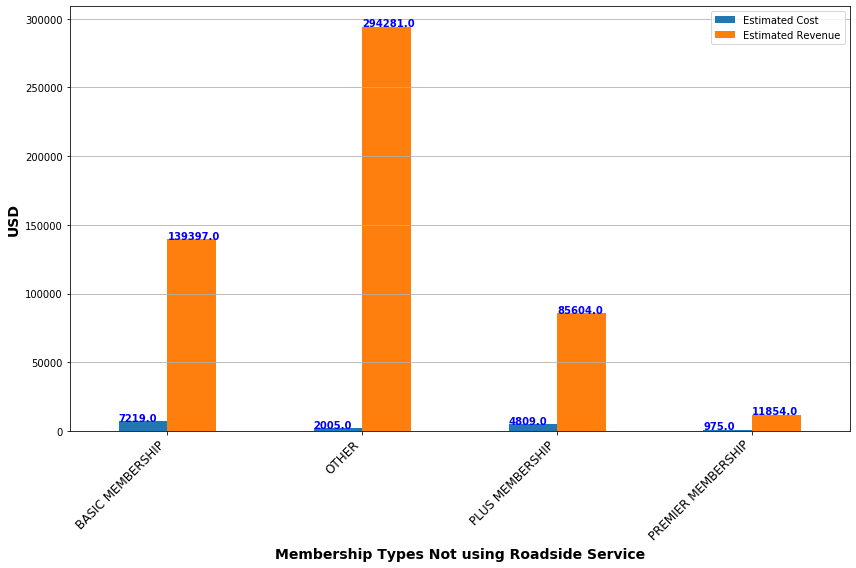

In [167]:
df_ts = pd.DataFrame(df_household, columns=['estimated_cost','yes_roadside', 'member_status', 'plus_indicator_description'])
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts.plus_indicator_description[(df_ts.plus_indicator_description == 'UNKNOWN')] = 'OTHER'
df_ts = df_ts[(df_ts.yes_roadside != 1)]
avg_rev = 745*0.82 # Cumm Gain % - Playing save
df_ts.estimated_cost = round(df_ts.estimated_cost/4,2)
df_ts['Estimated Revenue'] = avg_rev - df_ts['estimated_cost']
#df_ts.estimated_cost = round(df_ts.estimated_cost*4,2)

df_ts.rename(columns={'plus_indicator_description':'Membership Type', 'estimated_cost':'Estimated Cost'}, inplace=True)
# Initialize the matplotlib figure
df_ts_g = df_ts.groupby('Membership Type').sum()
df_ts_g.drop('yes_roadside',axis=1, inplace=True)
df_ts_g.plot(kind='bar', figsize=(12,8))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large')
i = 0
for v in list(df_ts_g.index):
    plt.text(i-.25, df_ts_g['Estimated Cost'][v], str(round(df_ts_g['Estimated Cost'][v],0)), color='blue', fontweight='bold')
    i +=1

i = 0
for v in list(df_ts_g.index):
    plt.text(i, df_ts_g['Estimated Revenue'][v], str(round(df_ts_g['Estimated Revenue'][v],0)), color='blue', fontweight='bold')
    i +=1
plt.xlabel('Membership Types Not using Roadside Service', fontsize=14, fontweight='bold')
plt.ylabel('USD', fontsize=14, fontweight='bold')
plt.grid(which='major', axis='y')

plt.show()

In [ ]:
df_ts = pd.DataFrame(df_household, columns=['estimated_cost','yes_roadside', 'member_status', 'plus_indicator_description'])
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts.plus_indicator_description[(df_ts.plus_indicator_description == 'UNKNOWN')] = 'OTHER'
df_ts = df_ts[(df_ts.yes_roadside != 1)]
avg_rev = 745*0.82 # Cumm Gain % - Playing save
df_ts.estimated_cost = round(df_ts.estimated_cost/4,2)
df_ts['Estimated Revenue'] = avg_rev - df_ts['estimated_cost']
#df_ts.estimated_cost = round(df_ts.estimated_cost*4,2)

df_ts.rename(columns={'plus_indicator_description':'Membership Type', 'estimated_cost':'Estimated Cost'}, inplace=True)
# Initialize the matplotlib figure
df_ts_g = df_ts.groupby('Membership Type').sum()
df_ts_g.drop('yes_roadside',axis=1, inplace=True)
df_ts_g.plot(kind='bar', figsize=(12,8))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large')
i = 0
for v in list(df_ts_g.index):
    plt.text(i-.25, df_ts_g['Estimated Cost'][v], str(round(df_ts_g['Estimated Cost'][v],0)), color='blue', fontweight='bold')
    i +=1

i = 0
for v in list(df_ts_g.index):
    plt.text(i, df_ts_g['Estimated Revenue'][v], str(round(df_ts_g['Estimated Revenue'][v],0)), color='blue', fontweight='bold')
    i +=1
plt.xlabel('Membership Types Not using Roadside Service', fontsize=14, fontweight='bold')
plt.ylabel('USD', fontsize=14, fontweight='bold')
plt.grid(which='major', axis='y')

plt.show()

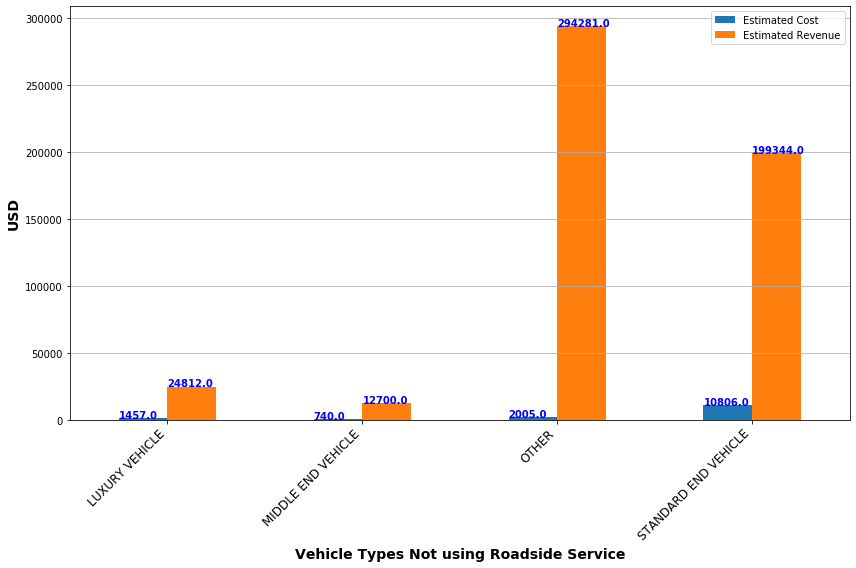

In [170]:
df_ts = pd.DataFrame(df_household, columns=['estimated_cost','yes_roadside', 'member_status', 'sc_vehicle_manufacturer_name'])
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts.sc_vehicle_manufacturer_name[(df_ts.sc_vehicle_manufacturer_name == 'UNKNOWN')] = 'OTHER'
df_ts = df_ts[(df_ts.yes_roadside != 1)]
avg_rev = 745*0.82 # Cumm Gain % - Playing save
df_ts.estimated_cost = round(df_ts.estimated_cost/4,2)
df_ts['Estimated Revenue'] = avg_rev - df_ts['estimated_cost']
#df_ts.estimated_cost = round(df_ts.estimated_cost*4,2)

df_ts.rename(columns={'sc_vehicle_manufacturer_name':'Vehicle Type', 'estimated_cost':'Estimated Cost'}, inplace=True)
# Initialize the matplotlib figure
df_ts_g = df_ts.groupby('Vehicle Type').sum()
df_ts_g.drop('yes_roadside',axis=1, inplace=True)
df_ts_g.plot(kind='bar', figsize=(12,8))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large')
i = 0
for v in list(df_ts_g.index):
    plt.text(i-.25, df_ts_g['Estimated Cost'][v], str(round(df_ts_g['Estimated Cost'][v],0)), color='blue', fontweight='bold')
    i +=1

i = 0
for v in list(df_ts_g.index):
    plt.text(i, df_ts_g['Estimated Revenue'][v], str(round(df_ts_g['Estimated Revenue'][v],0)), color='blue', fontweight='bold')
    i +=1
plt.xlabel('Vehicle Types Not using Roadside Service', fontsize=14, fontweight='bold')
plt.ylabel('USD', fontsize=14, fontweight='bold')
plt.grid(which='major', axis='y')

plt.show()

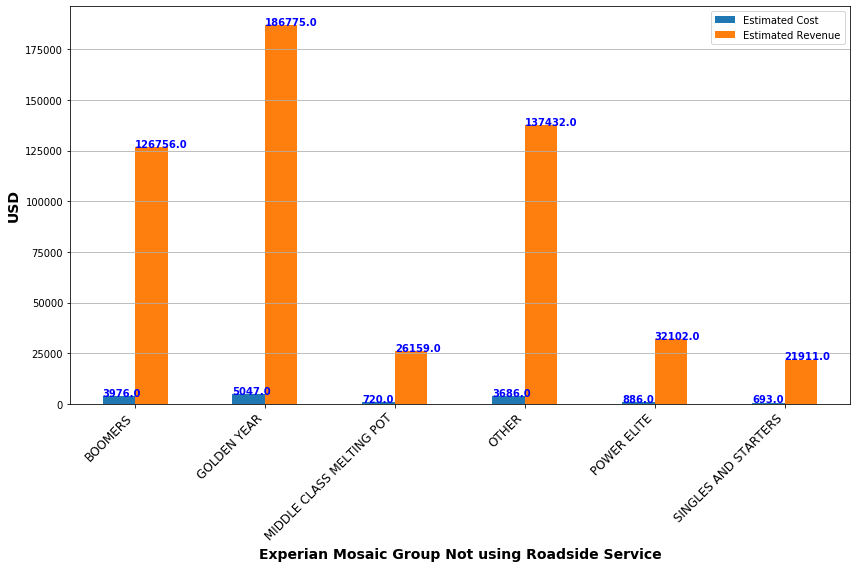

In [171]:
df_ts = pd.DataFrame(df_household, columns=['estimated_cost','yes_roadside', 'member_status', 'kcl_b_ind_mosaicsgrouping'])
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts.kcl_b_ind_mosaicsgrouping[(df_ts.kcl_b_ind_mosaicsgrouping == 'UNKNOWN')] = 'OTHER'
df_ts = df_ts[(df_ts.yes_roadside != 1)]
avg_rev = 745*0.82 # Cumm Gain % - Playing save
df_ts.estimated_cost = round(df_ts.estimated_cost/4,2)
df_ts['Estimated Revenue'] = avg_rev - df_ts['estimated_cost']
#df_ts.estimated_cost = round(df_ts.estimated_cost*4,2)

df_ts.rename(columns={'kcl_b_ind_mosaicsgrouping':'Experian Mosaic Group', 'estimated_cost':'Estimated Cost'}, inplace=True)
# Initialize the matplotlib figure
df_ts_g = df_ts.groupby('Experian Mosaic Group').sum()
df_ts_g.drop('yes_roadside',axis=1, inplace=True)
df_ts_g.plot(kind='bar', figsize=(12,8))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large')
i = 0
for v in list(df_ts_g.index):
    plt.text(i-.25, df_ts_g['Estimated Cost'][v], str(round(df_ts_g['Estimated Cost'][v],0)), color='blue', fontweight='bold')
    i +=1

i = 0
for v in list(df_ts_g.index):
    plt.text(i, df_ts_g['Estimated Revenue'][v], str(round(df_ts_g['Estimated Revenue'][v],0)), color='blue', fontweight='bold')
    i +=1
plt.xlabel('Experian Mosaic Group Not using Roadside Service', fontsize=14, fontweight='bold')
plt.ylabel('USD', fontsize=14, fontweight='bold')
plt.grid(which='major', axis='y')

plt.show()

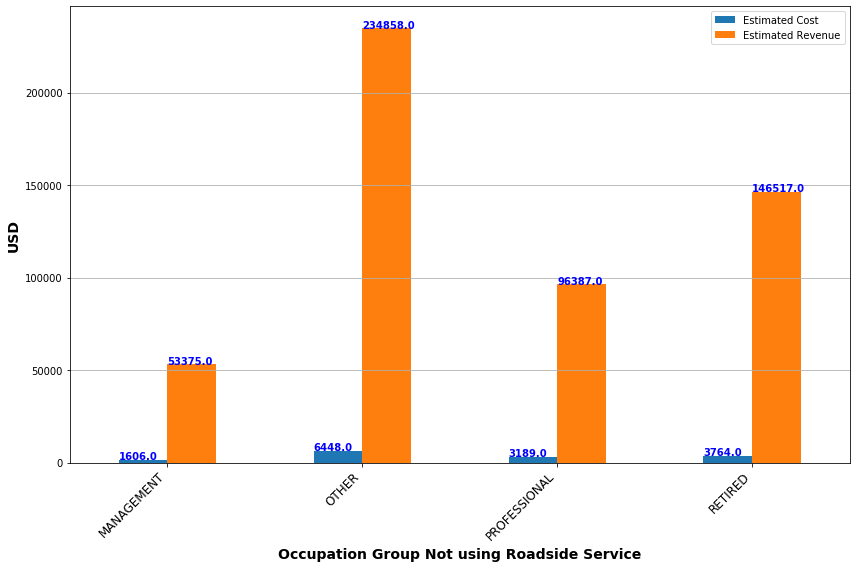

In [172]:
df_ts = pd.DataFrame(df_household, columns=['estimated_cost','yes_roadside', 'member_status', 'occupation_group'])
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts.occupation_group[(df_ts.occupation_group == 'UNKNOWN')] = 'OTHER'
df_ts = df_ts[(df_ts.yes_roadside != 1)]
avg_rev = 745*0.82 # Cumm Gain % - Playing save
df_ts.estimated_cost = round(df_ts.estimated_cost/4,2)
df_ts['Estimated Revenue'] = avg_rev - df_ts['estimated_cost']
#df_ts.estimated_cost = round(df_ts.estimated_cost*4,2)

df_ts.rename(columns={'occupation_group':'Occupation Group', 'estimated_cost':'Estimated Cost'}, inplace=True)
# Initialize the matplotlib figure
df_ts_g = df_ts.groupby('Occupation Group').sum()
df_ts_g.drop('yes_roadside',axis=1, inplace=True)
df_ts_g.plot(kind='bar', figsize=(12,8))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large')
i = 0
for v in list(df_ts_g.index):
    plt.text(i-.25, df_ts_g['Estimated Cost'][v], str(round(df_ts_g['Estimated Cost'][v],0)), color='blue', fontweight='bold')
    i +=1

i = 0
for v in list(df_ts_g.index):
    plt.text(i, df_ts_g['Estimated Revenue'][v], str(round(df_ts_g['Estimated Revenue'][v],0)), color='blue', fontweight='bold')
    i +=1
plt.xlabel('Occupation Group Not using Roadside Service', fontsize=14, fontweight='bold')
plt.ylabel('USD', fontsize=14, fontweight='bold')
plt.grid(which='major', axis='y')

plt.show()

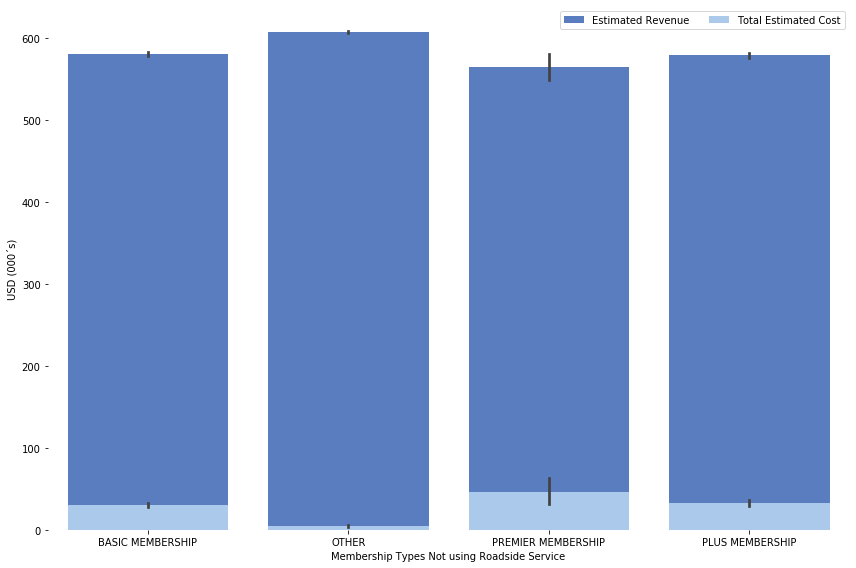

In [140]:
df_ts = pd.DataFrame(df_household, columns=['estimated_cost','yes_roadside', 'member_status', 'plus_indicator_description'])
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts.plus_indicator_description[(df_ts.plus_indicator_description == 'UNKNOWN')] = 'OTHER'
df_ts = df_ts[(df_ts.yes_roadside != 1)]
avg_rev = 745*0.82 # Cumm Gain % - Playing save
df_ts.estimated_cost = round(df_ts.estimated_cost/4,2)
df_ts['Estimated Revenue'] = avg_rev - df_ts['estimated_cost']
#df_ts.estimated_cost = round(df_ts.estimated_cost*4,2)

df_ts.rename(columns={'plus_indicator_description':'Membership Type', 'estimated_cost':'Estimated Cost'}, inplace=True)
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="Membership Type", y="Estimated Revenue", data=df_ts,
            label="Estimated Revenue", color="b")

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="Membership Type", y="Estimated Cost", data=df_ts,
            label="Total Estimated Cost", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylabel="USD (000's)", xlabel="Membership Types Not using Roadside Service")
sns.despine(left=True, bottom=True)
plt.show()

In [41]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 153 to 543695
Data columns (total 98 columns):
household_key                        2937 non-null int64
income                               2937 non-null object
member_status                        2937 non-null object
state_grouped                        2937 non-null object
credit_ranges                        2937 non-null object
cancel_reason                        2937 non-null object
renew_method                         2937 non-null object
plus_indicator_description           2937 non-null object
zip                                  2937 non-null int64
sc_vehicle_manufacturer_name         2937 non-null object
sc_vehicle_model_name                2937 non-null object
race                                 2937 non-null object
home_owner                           2937 non-null object
education                            2937 non-null object
dwelling_type                        2937 non-null object
gender               

In [174]:
df_transaction = read_data('capstone_aaa_featured_no_gaps.csv', 'membership_id')

In [178]:
df_transaction.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26006 entries, 153 to 543673
Data columns (total 166 columns):
id                                26006 non-null int64
individual_key                    26006 non-null int64
household_key                     26006 non-null int64
member_flag                       26006 non-null int64
city                              26006 non-null object
state_grouped                     26006 non-null object
zip5                              26006 non-null int64
zip9                              26006 non-null int64
fsv_cmsi_flag                     26006 non-null int64
fsv_credit_card_flag              26006 non-null int64
fsv_deposit_program_flag          26006 non-null int64
fsv_home_equity_flag              26006 non-null int64
fsv_id_theft_flag                 26006 non-null int64
fsv_mortgage_flag                 26006 non-null int64
ins_client_flag                   26006 non-null int64
trv_globalware_flag               26006 non-null int64
numbe

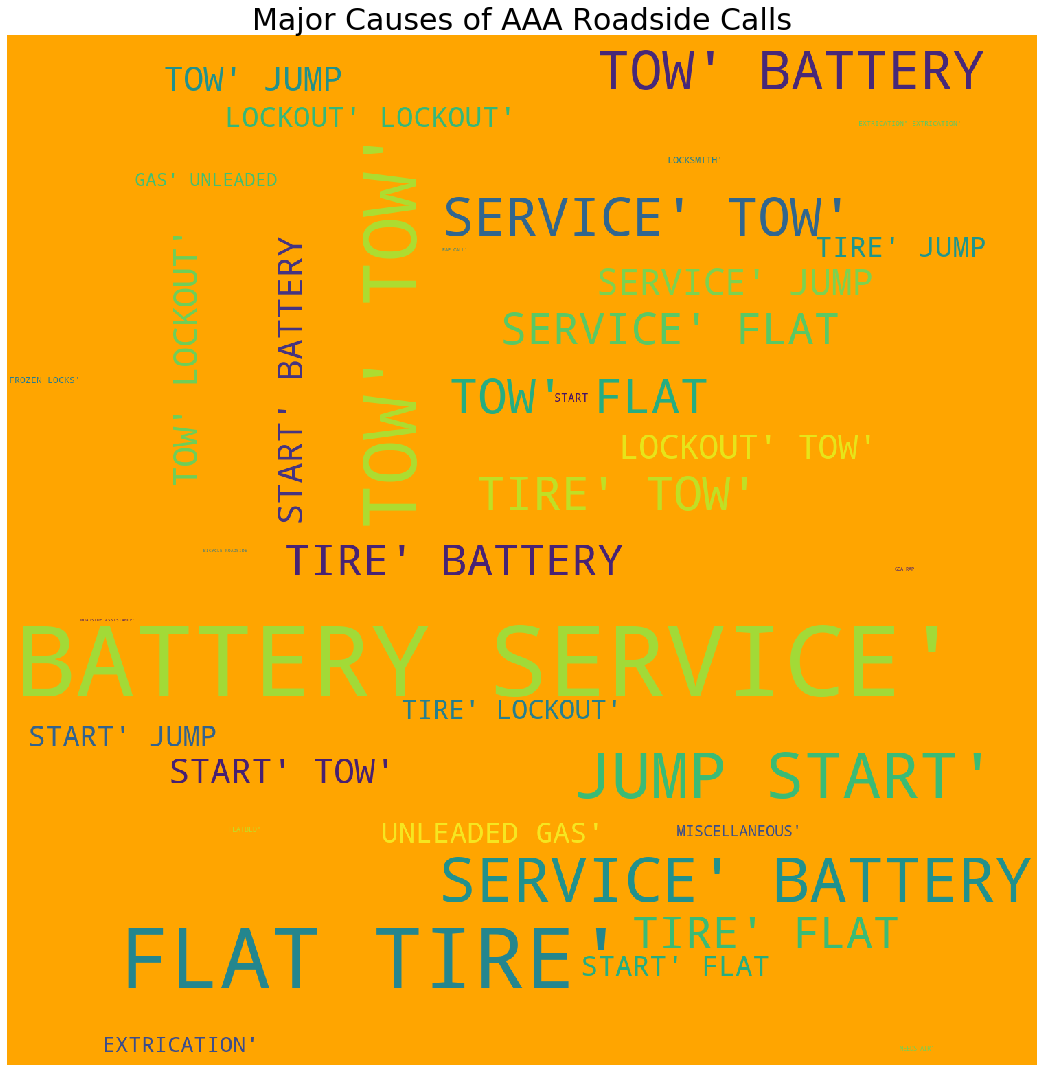

TOW                6158
BATTERY SERVICE    4894
FLAT TIRE          3499
JUMP START         1878
LOCKOUT            1556
Name: prob1_code_description, dtype: int64

In [207]:
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (15, 15)
plt.style.use('fast')

df = df_transaction.copy()
df = df[(df.prob1_code_description != 'UNKNOWN')]
wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(list(df['prob1_code_description'])))
plt.title('Major Causes of AAA Roadside Calls', fontsize = 30)

plt.imshow(wc)
plt.axis('off')
plt.show()
df.prob1_code_description.value_counts().nlargest(5)

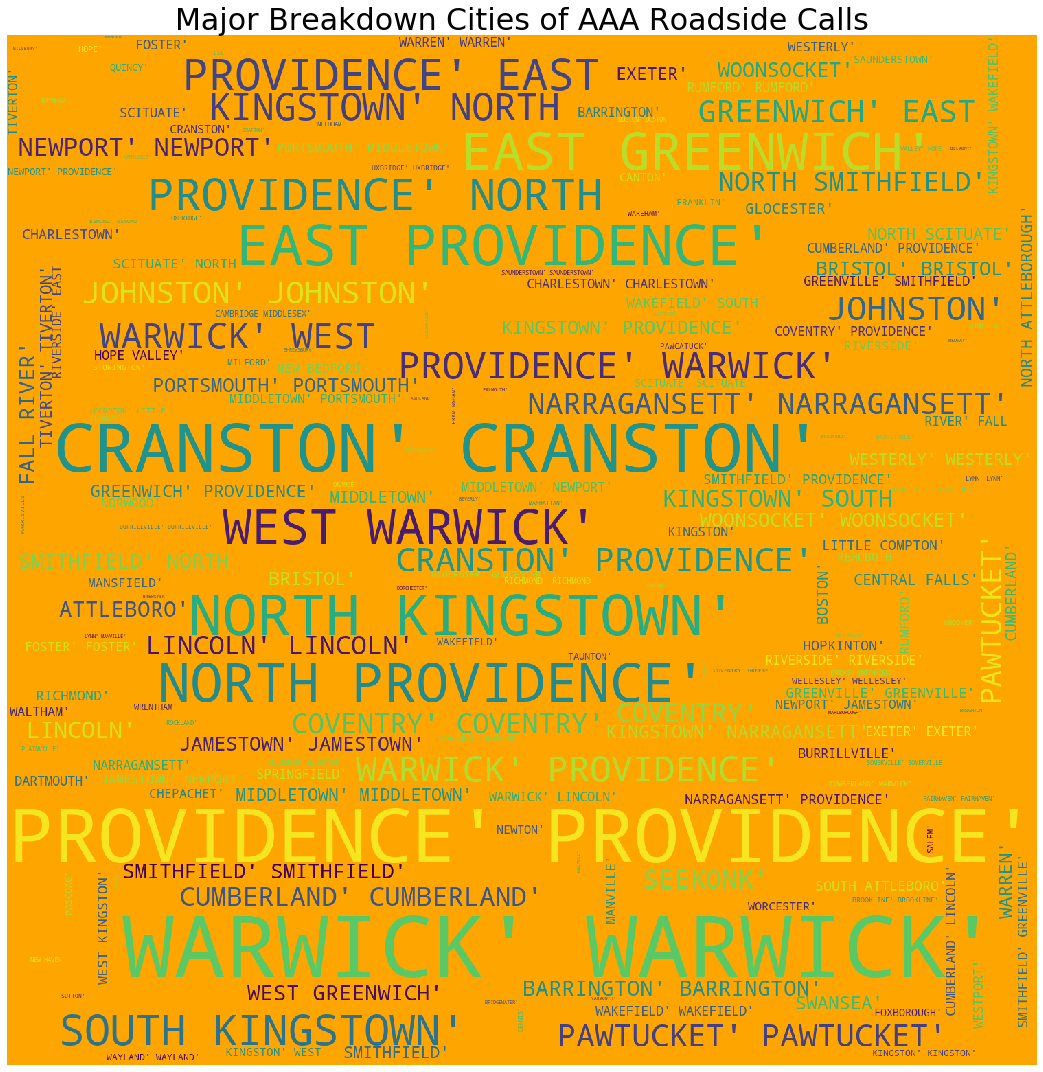

WARWICK            2488
PROVIDENCE         2368
CRANSTON           2136
NORTH KINGSTOWN     654
EAST PROVIDENCE     634
Name: breakdown_city, dtype: int64

In [208]:
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (15, 15)
plt.style.use('fast')

df = df_transaction.copy()
df = df[(df.breakdown_city != 'UNKNOWN')]
wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(list(df['breakdown_city'])))
plt.title('Major Breakdown Cities of AAA Roadside Calls', fontsize = 30)

plt.imshow(wc)
plt.axis('off')
plt.show()

df.breakdown_city.value_counts().nlargest(5)

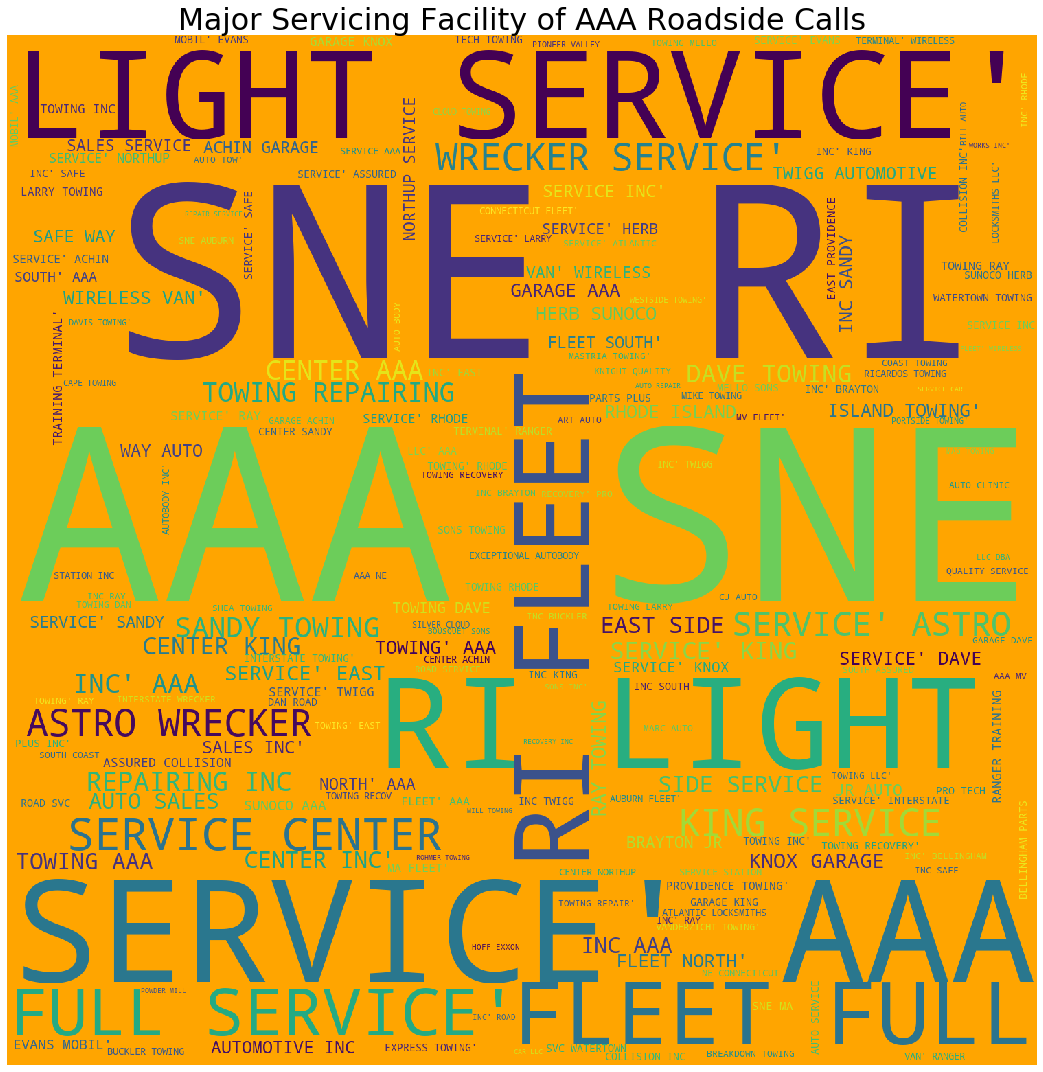

AAA SNE RI  LIGHT SERVICE         6492
AAA SNE RI FLEET FULL SERVICE     4297
KING'S SERVICE CENTER             1056
ASTRO WRECKER SERVICE             1055
SANDY'S TOWING & REPAIRING INC     504
Name: svc_facility_name, dtype: int64

In [209]:
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (15, 15)
plt.style.use('fast')

df = df_transaction.copy()
df = df[(df.svc_facility_name != 'UNKNOWN')]
wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(list(df['svc_facility_name'])))
plt.title('Major Servicing Facility of AAA Roadside Calls', fontsize = 30)

plt.imshow(wc)
plt.axis('off')
plt.show()
df.svc_facility_name.value_counts().nlargest(5)

In [196]:
df_transaction['svc_facility_name'].value_counts()

UNKNOWN                                     7526
AAA SNE RI  LIGHT SERVICE                   6492
AAA SNE RI FLEET FULL SERVICE               4297
KING'S SERVICE CENTER                       1056
ASTRO WRECKER SERVICE                       1055
SANDY'S TOWING & REPAIRING INC               504
DAVE'S TOWING                                434
EAST SIDE SERVICE CENTER INC                 377
KNOX'S GARAGE                                287
RAY'S TOWING                                 264
HERB'S SUNOCO                                223
RHODE ISLAND TOWING                          223
WIRELESS VAN                                 220
AAA SNE RI FLEET NORTH                       216
SAFE-WAY AUTO SALES INC                      190
TWIGG'S AUTOMOTIVE INC                       188
ACHIN'S GARAGE                               174
AAA SNE RI FLEET SOUTH                       174
NORTHUP'S SERVICE CENTER                     162
F.E. BRAYTON JR AUTO SALES & SERVICE INC     152
EVANS MOBIL         

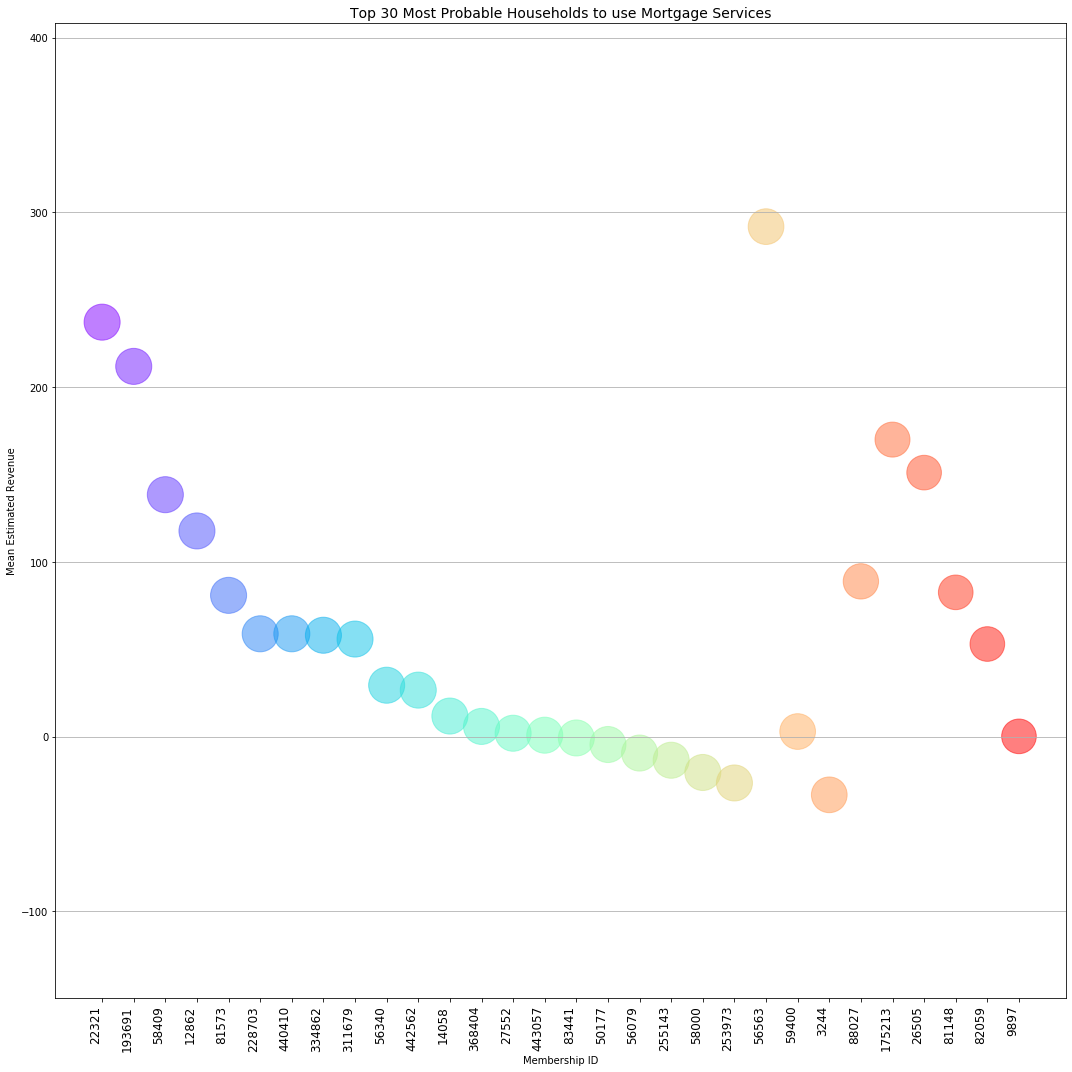

In [215]:
# Graph Time series per household mortgage service
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_mortgage', 'member_status'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.yes_mortgage != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.sort_values(by=['yes_mortgage', 'mean_estimated_revenue'], ascending=False).head(30)
top_members['membership_id'] = top_members.index.astype(str)
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
plt.scatter(x=top_members.membership_id, y=top_members['mean_estimated_revenue'], 
            s=top_members['yes_mortgage']*2500, alpha=0.5, c=colors)
plt.ylabel("Mean Estimated Revenue")
plt.xlabel("Membership ID")
plt.title("Top 30 Most Probable Households to use Mortgage Services", loc="center")
plt.xticks(rotation=90, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
bottom, top = plt.ylim()
plt.grid(which='major', axis='y')
plt.ylim(bottom - 100, top + 100)
plt.show()

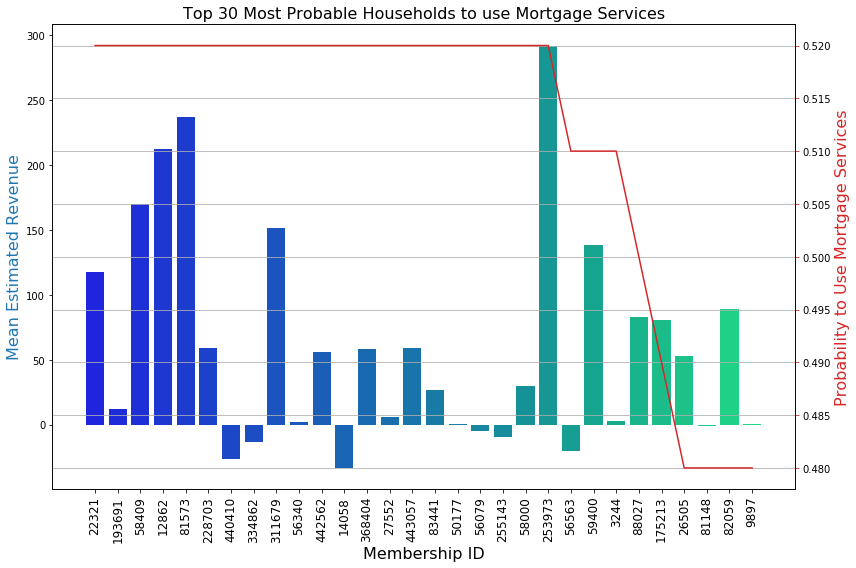

In [242]:
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_mortgage', 'member_status'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.yes_mortgage != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.sort_values(by=['yes_mortgage', 'mean_estimated_revenue'], ascending=False).head(30)
top_members['membership_id'] = top_members.index.astype(str)
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
top_members.rename(columns={'membership_id':'Membership ID','mean_estimated_revenue':'Mean Estimated Revenue', 
                            'yes_mortgage':'Probability to Use Mortgage Services'}, 
                   inplace=True)
fig, ax1 = plt.subplots(figsize=(12,8))
color = 'tab:blue'
ax1.set_title("Top 30 Most Probable Households to use Mortgage Services", loc="center", fontsize=16)
ax1.set_xlabel('Membership ID', fontsize=16)
ax1.set_ylabel('Mean Estimated Revenue', fontsize=16, color=color)
ax1 = sns.barplot(x='Membership ID', y='Mean Estimated Revenue', data = top_members, palette='winter')
ax1.tick_params(axis='y')
plt.xticks(rotation=90, 
           horizontalalignment='center',
           fontweight='light',
           fontsize='large')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Probability to Use Mortgage Services', fontsize=16, color=color)
ax2 = sns.lineplot(x='Membership ID', y='Probability to Use Mortgage Services', data = top_members, sort=False, color=color)
ax2.tick_params(axis='y', color=color, which='major')
plt.grid(which='major')
plt.show()

In [247]:
top_members

mean_total_member_cost  mean_total_cost  Probability to Use Mortgage Services member_status  Mean Estimated Revenue Membership ID
membership_id                                                                                                                                   
22321                        276.7000          39.5400                                0.5200        ACTIVE                237.1600         22321
193691                       252.2143          40.3643                                0.5200        ACTIVE                211.8500        193691
58409                        164.8889          26.4444                                0.5200        ACTIVE                138.4444         58409
12862                        170.7000          53.0000                                0.5200        ACTIVE                117.7000         12862
81573                        111.2500          30.4075                                0.5200        ACTIVE                 80.8425         81573
228703                       117.7000          58.8500                                0.5200        ACTIVE                 58.8500        228703
440410                       117.7000          58.8500                                0.5200        ACTIVE                 58.8500        440410
334862                        77.7314          19.7143                                0.5200        ACTIVE                 58.0171        334862
311679                        85.2650          29.4250                                0.5200        ACTIVE                 55.8400        311679
56340                         58.8500          29.4250                                0.5200        ACTIVE                 29.4250         56340
442562                        48.7500          22.1250                                0.5200        ACTIVE                 26.6250        442562
14058                         53.0000          41.2150                                0.5200        ACTIVE                 11.7850         14058
368404                        58.8500          53.0000                                0.5200        ACTIVE                  5.8500        368404
27552                         39.2333          37.2833                                0.5200        ACTIVE                  1.9500         27552
443057                        20.3333          19.5000                                0.5200       PENDING                  0.8333        443057
83441                         33.5000          34.2500                                0.5200        ACTIVE                 -0.7500         83441
50177                         30.0000          34.5000                                0.5200        ACTIVE                 -4.5000         50177
56079                         74.5667          83.9500                                0.5200        ACTIVE                 -9.3833         56079
255143                        15.0000          28.5000                                0.5200        ACTIVE                -13.5000        255143
58000                         32.5000          53.0000                                0.5200        ACTIVE                -20.5000         58000
253973                        29.4250          55.9250                                0.5200        ACTIVE                -26.5000        253973
56563                        335.1900          43.3722                                0.5100        ACTIVE                291.8178         56563
59400                         44.1375          41.2125                                0.5100        ACTIVE                  2.9250         59400
3244                          15.1429          48.4286                                0.5100        ACTIVE                -33.2857          3244
88027                        147.7000          58.8500                                0.5000        ACTIVE                 88.8500         88027
175213                       210.3600          40.4000                                0.4900        

In [322]:
df_ts = pd.DataFrame(df_household, columns=['total_member_cost','total_cost','yes_mortgage', 
                                            'member_status'])
df_ts['estimated_revenue'] = df_ts['total_member_cost'] - df_ts['total_cost']
df_ts = df_ts[(df_ts.member_status != 'CANCELLED')]
df_ts = df_ts[(df_ts.yes_mortgage != 1)]
threshold = 0.
df_ts = df_ts[(df_ts.yes_mortgage >= threshold)]
df_ts.estimated_revenue.sum(), df_ts.estimated_revenue.count()
df_ts.groupby(pd.qcut(df_ts.yes_mortgage, 5))['yes_mortgage'].count()

yes_mortgage
(0.039, 0.21]    615
(0.21, 0.26]     525
(0.26, 0.3]      496
(0.3, 0.35]      523
(0.35, 0.52]     512
Name: yes_mortgage, dtype: int64

In [258]:
top_members

mean_total_member_cost  mean_total_cost  Probability to Use Mortgage Services  Mean Estimated Revenue  Number of Children
aaa_mean_child                                                                                                                           
0.0000                         98.1100          34.0727                                0.3321                 64.0374              0.0000
1.0000                         93.0608          34.2255                                0.3013                 58.8353              1.0000
2.0000                         90.9829          33.2401                                0.2998                 57.7428              2.0000
3.0000                         94.1017          33.3666                                0.2876                 60.7350              3.0000
4.0000                        106.9828          34.1456                                0.2724                 72.8373              4.0000
5.0000                        115.2754          34.5778                                0.2744                 80.6976              5.0000
6.0000                         44.7772          35.8253                                0.2840                  8.9519              6.0000

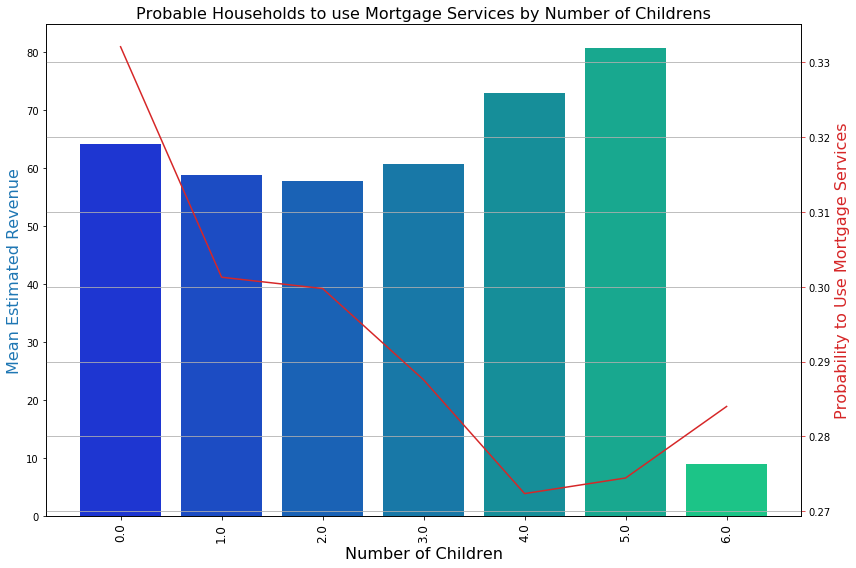

In [261]:
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_mortgage', 'member_status', 'aaa_mean_child'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.yes_mortgage != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.groupby(by='aaa_mean_child').mean()
#top_members = top_members.nlargest(30, columns=['yes_mortgage','mean_estimated_revenue'])
top_members['Number of Children'] = top_members.index.values
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
top_members.rename(columns={'mean_estimated_revenue':'Mean Estimated Revenue', 
                            'yes_mortgage':'Probability to Use Mortgage Services'}, 
                   inplace=True)
fig, ax1 = plt.subplots(figsize=(12,8))
color = 'tab:blue'
ax1.set_title("Probable Households to use Mortgage Services by Number of Childrens", loc="center", fontsize=16)
ax1.set_ylabel('Mean Estimated Revenue', fontsize=16, color=color)
ax1.set_xlabel('Number of Children', fontsize=16)
ax1 = sns.barplot(x='Number of Children', y='Mean Estimated Revenue', data = top_members, palette='winter')
ax1.tick_params(axis='y')
plt.xticks(rotation=90, 
           horizontalalignment='center',
           fontweight='light',
           fontsize='large')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Probability to Use Mortgage Services', fontsize=16, color=color)
ax2 = sns.lineplot(x='Number of Children', y='Probability to Use Mortgage Services', data = top_members, sort=False, color=color)
ax2.tick_params(axis='y', color=color, which='major')
plt.grid(which='major')
plt.show()

In [264]:
top_members

mean_total_member_cost  mean_total_cost  Probability to Use Mortgage Services  Mean Estimated Revenue
no_members                                                                                                        
+5 - MEMBER                101.9371          30.9034                                0.2889                 71.0337
1 - MEMBER                 116.0287          40.4681                                0.3083                 75.5606
2 - MEMBER                  84.8703          33.2821                                0.3077                 51.5883
3 - MEMBER                  85.4222          30.8629                                0.2999                 54.5593
4 - MEMBER                  93.1809          31.6977                                0.2908                 61.4832

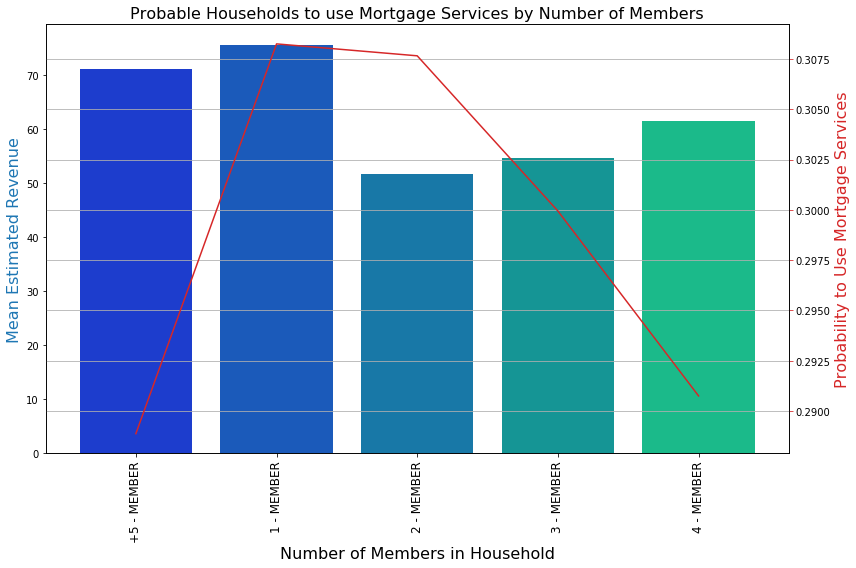

In [268]:
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_mortgage', 'member_status', 'no_members'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.yes_mortgage != 1)]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.groupby(by='no_members').mean()
#top_members = top_members.nlargest(30, columns=['yes_mortgage','mean_estimated_revenue'])
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
top_members.rename(columns={'mean_estimated_revenue':'Mean Estimated Revenue', 'no_members':'Number of Members in Household',
                            'yes_mortgage':'Probability to Use Mortgage Services'}, 
                   inplace=True)
fig, ax1 = plt.subplots(figsize=(12,8))
color = 'tab:blue'
ax1.set_title("Probable Households to use Mortgage Services by Number of Members", loc="center", fontsize=16)
ax1.set_ylabel('Mean Estimated Revenue', fontsize=16, color=color)
ax1.set_xlabel('Number of Members in Household', fontsize=16)
ax1 = sns.barplot(x=top_members.index.values, y='Mean Estimated Revenue', data = top_members, palette='winter')
ax1.tick_params(axis='y')
plt.xticks(rotation=90, 
           horizontalalignment='center',
           fontweight='light',
           fontsize='large')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Probability to Use Mortgage Services', fontsize=16, color=color)
ax2 = sns.lineplot(x=top_members.index.values, y='Probability to Use Mortgage Services', data = top_members, sort=False, color=color)
ax2.tick_params(axis='y', color=color, which='major')
plt.grid(which='major')
plt.show()

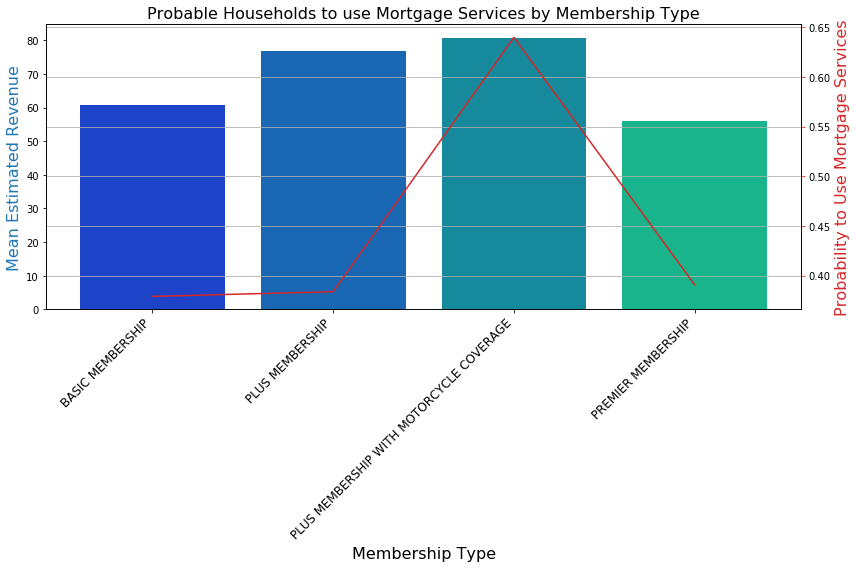

In [274]:
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_mortgage', 'member_status', 
                                            'plus_indicator_description'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.yes_mortgage != 1)]
t_membership_id = df_ts[(df_ts.plus_indicator_description != 'UNKNOWN')]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.groupby(by='plus_indicator_description').mean()
#top_members = top_members.nlargest(30, columns=['yes_mortgage','mean_estimated_revenue'])
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
top_members.rename(columns={'mean_estimated_revenue':'Mean Estimated Revenue', 'plus_indicator_description':'Membership Type',
                            'yes_mortgage':'Probability to Use Mortgage Services'}, 
                   inplace=True)
fig, ax1 = plt.subplots(figsize=(12,8))
color = 'tab:blue'
ax1.set_title("Probable Households to use Mortgage Services by Membership Type", loc="center", fontsize=16)
ax1.set_ylabel('Mean Estimated Revenue', fontsize=16, color=color)
ax1.set_xlabel('Membership Type', fontsize=16)
ax1 = sns.barplot(x=top_members.index.values, y='Mean Estimated Revenue', data = top_members, palette='winter')
ax1.tick_params(axis='y')
plt.xticks(rotation=45, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Probability to Use Mortgage Services', fontsize=16, color=color)
ax2 = sns.lineplot(x=top_members.index.values, y='Probability to Use Mortgage Services', data = top_members, sort=False, color=color)
ax2.tick_params(axis='y', color=color, which='major')
plt.grid(which='major')
plt.show()

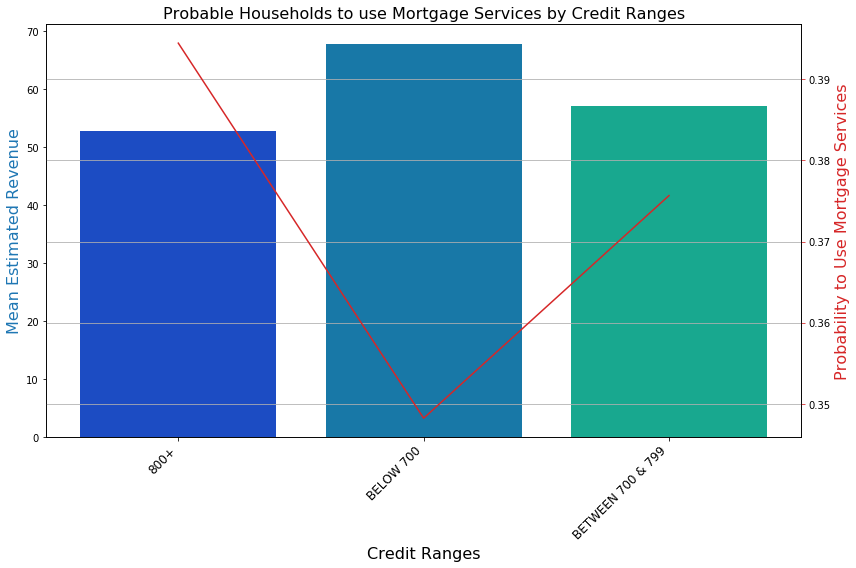

In [275]:
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_mortgage', 'member_status', 
                                            'credit_ranges'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.yes_mortgage != 1)]
t_membership_id = df_ts[(df_ts.credit_ranges != 'UNKNOWN')]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.groupby(by='credit_ranges').mean()
#top_members = top_members.nlargest(30, columns=['yes_mortgage','mean_estimated_revenue'])
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
top_members.rename(columns={'mean_estimated_revenue':'Mean Estimated Revenue', 'credit_ranges':'Credit Ranges',
                            'yes_mortgage':'Probability to Use Mortgage Services'}, 
                   inplace=True)
fig, ax1 = plt.subplots(figsize=(12,8))
color = 'tab:blue'
ax1.set_title("Probable Households to use Mortgage Services by Credit Ranges", loc="center", fontsize=16)
ax1.set_ylabel('Mean Estimated Revenue', fontsize=16, color=color)
ax1.set_xlabel('Credit Ranges', fontsize=16)
ax1 = sns.barplot(x=top_members.index.values, y='Mean Estimated Revenue', data = top_members, palette='winter')
ax1.tick_params(axis='y')
plt.xticks(rotation=45, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Probability to Use Mortgage Services', fontsize=16, color=color)
ax2 = sns.lineplot(x=top_members.index.values, y='Probability to Use Mortgage Services', data = top_members, sort=False, color=color)
ax2.tick_params(axis='y', color=color, which='major')
plt.grid(which='major')
plt.show()

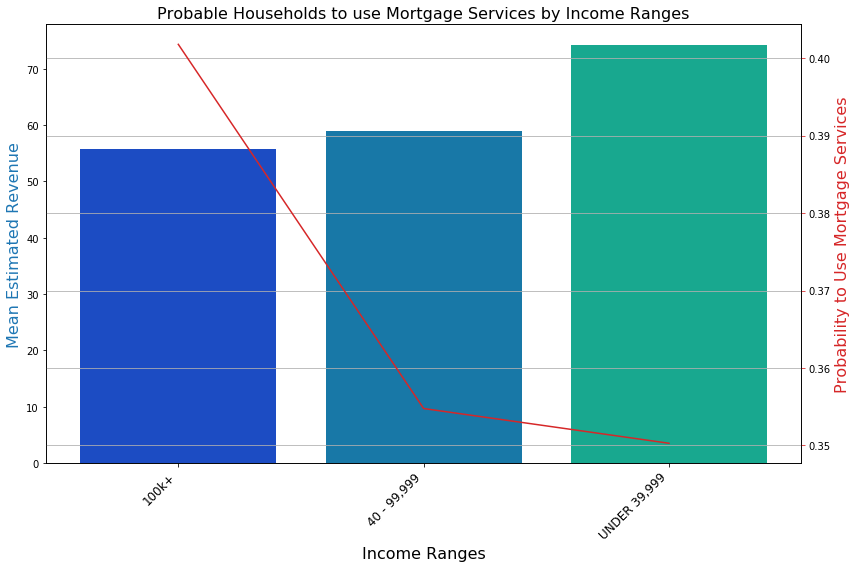

In [276]:
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_mortgage', 'member_status', 
                                            'income'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.yes_mortgage != 1)]
t_membership_id = df_ts[(df_ts.income != 'UNKNOWN')]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.groupby(by='income').mean()
#top_members = top_members.nlargest(30, columns=['yes_mortgage','mean_estimated_revenue'])
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
top_members.rename(columns={'mean_estimated_revenue':'Mean Estimated Revenue', 'income':'Income Ranges',
                            'yes_mortgage':'Probability to Use Mortgage Services'}, 
                   inplace=True)
fig, ax1 = plt.subplots(figsize=(12,8))
color = 'tab:blue'
ax1.set_title("Probable Households to use Mortgage Services by Income Ranges", loc="center", fontsize=16)
ax1.set_ylabel('Mean Estimated Revenue', fontsize=16, color=color)
ax1.set_xlabel('Income Ranges', fontsize=16)
ax1 = sns.barplot(x=top_members.index.values, y='Mean Estimated Revenue', data = top_members, palette='winter')
ax1.tick_params(axis='y')
plt.xticks(rotation=45, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Probability to Use Mortgage Services', fontsize=16, color=color)
ax2 = sns.lineplot(x=top_members.index.values, y='Probability to Use Mortgage Services', data = top_members, sort=False, color=color)
ax2.tick_params(axis='y', color=color, which='major')
plt.grid(which='major')
plt.show()

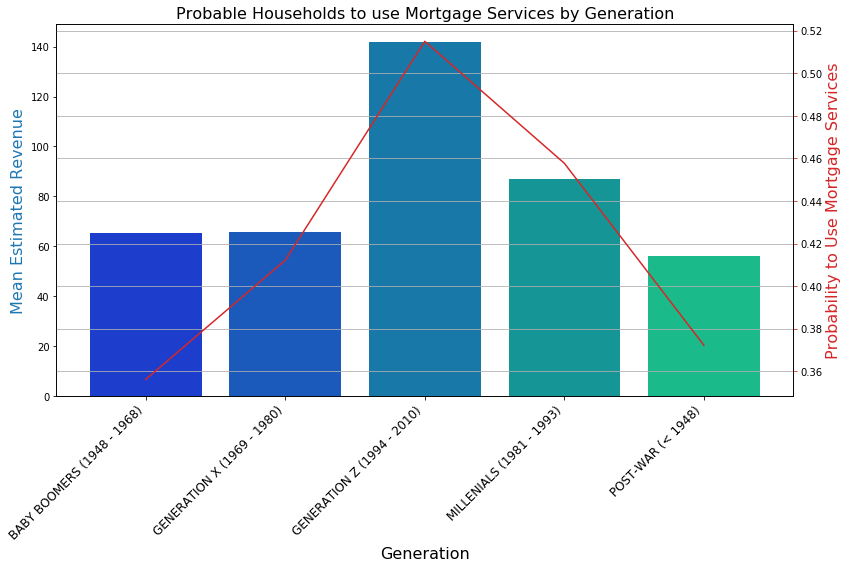

In [280]:
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_mortgage', 'member_status', 
                                            'generation'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.yes_mortgage != 1)]
t_membership_id = df_ts[(df_ts.generation != 'UNKNOWN')]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.groupby(by='generation').mean()
#top_members = top_members.nlargest(30, columns=['yes_mortgage','mean_estimated_revenue'])
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
top_members.rename(columns={'mean_estimated_revenue':'Mean Estimated Revenue', 'generation':'Generation',
                            'yes_mortgage':'Probability to Use Mortgage Services'}, 
                   inplace=True)
fig, ax1 = plt.subplots(figsize=(12,8))
color = 'tab:blue'
ax1.set_title("Probable Households to use Mortgage Services by Generation", loc="center", fontsize=16)
ax1.set_ylabel('Mean Estimated Revenue', fontsize=16, color=color)
ax1.set_xlabel('Generation', fontsize=16)
ax1 = sns.barplot(x=top_members.index.values, y='Mean Estimated Revenue', data = top_members, palette='winter')
ax1.tick_params(axis='y')
plt.xticks(rotation=45, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Probability to Use Mortgage Services', fontsize=16, color=color)
ax2 = sns.lineplot(x=top_members.index.values, y='Probability to Use Mortgage Services', data = top_members, sort=False, color=color)
ax2.tick_params(axis='y', color=color, which='major')
plt.grid(which='major')
plt.show()

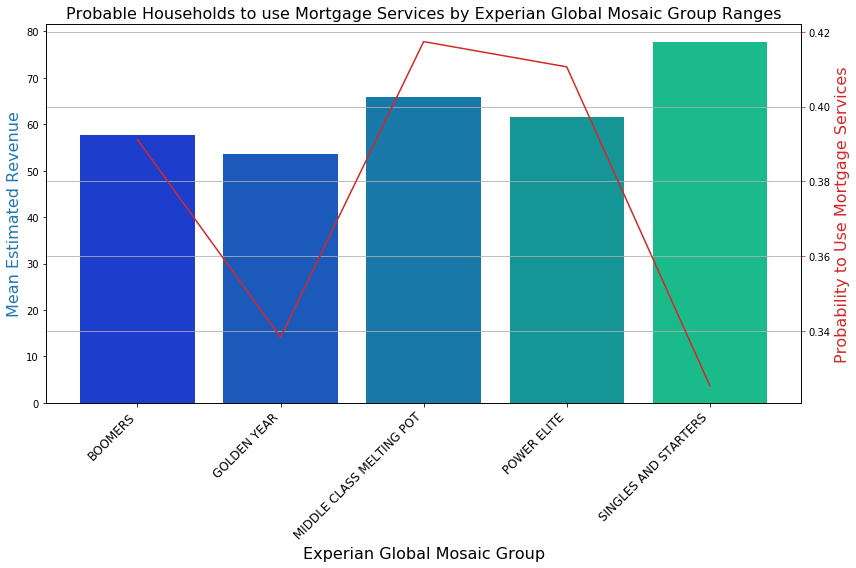

In [279]:
df_ts = pd.DataFrame(df_household, columns=['mean_total_member_cost','mean_total_cost','yes_mortgage', 'member_status', 
                                            'kcl_b_ind_mosaicsgrouping'])
df_ts['mean_estimated_revenue'] = df_ts['mean_total_member_cost'] - df_ts['mean_total_cost']
t_membership_id = df_ts[(df_ts.yes_mortgage != 1)]
t_membership_id = df_ts[(df_ts.kcl_b_ind_mosaicsgrouping != 'UNKNOWN')]
t_membership_id = t_membership_id[(t_membership_id.mean_total_member_cost > 0)]
top_members = t_membership_id.groupby(by='kcl_b_ind_mosaicsgrouping').mean()
#top_members = top_members.nlargest(30, columns=['yes_mortgage','mean_estimated_revenue'])
colors = cm.rainbow(np.linspace(0, 1, top_members.shape[0]))
top_members.rename(columns={'mean_estimated_revenue':'Mean Estimated Revenue', 'kcl_b_ind_mosaicsgrouping':'Experian Global Mosaic Group',
                            'yes_mortgage':'Probability to Use Mortgage Services'}, 
                   inplace=True)
fig, ax1 = plt.subplots(figsize=(12,8))
color = 'tab:blue'
ax1.set_title("Probable Households to use Mortgage Services by Experian Global Mosaic Group Ranges", loc="center", fontsize=16)
ax1.set_ylabel('Mean Estimated Revenue', fontsize=16, color=color)
ax1.set_xlabel('Experian Global Mosaic Group', fontsize=16)
ax1 = sns.barplot(x=top_members.index.values, y='Mean Estimated Revenue', data = top_members, palette='winter')
ax1.tick_params(axis='y')
plt.xticks(rotation=45, 
           horizontalalignment='right',
           fontweight='light',
           fontsize='large')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Probability to Use Mortgage Services', fontsize=16, color=color)
ax2 = sns.lineplot(x=top_members.index.values, y='Probability to Use Mortgage Services', data = top_members, sort=False, color=color)
ax2.tick_params(axis='y', color=color, which='major')
plt.grid(which='major')
plt.show()

In [262]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 153 to 543695
Data columns (total 98 columns):
household_key                        2937 non-null int64
income                               2937 non-null object
member_status                        2937 non-null object
state_grouped                        2937 non-null object
credit_ranges                        2937 non-null object
cancel_reason                        2937 non-null object
renew_method                         2937 non-null object
plus_indicator_description           2937 non-null object
zip                                  2937 non-null int64
sc_vehicle_manufacturer_name         2937 non-null object
sc_vehicle_model_name                2937 non-null object
race                                 2937 non-null object
home_owner                           2937 non-null object
education                            2937 non-null object
dwelling_type                        2937 non-null object
gender               

In [7]:
df_household = re_group(df_household)